<a href="https://colab.research.google.com/github/ChrisZonghaoLi/sky130_ldo_rl/blob/main/ldo_rgcn_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Design and Optimization of Analog LDO with Relational Graph Neural Network and Reinforcement Learning

```
Zonghao Li Team, March 2023
SPDX-License-Identifier: Apache-2.0
```


|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Zonghao Li (Lead) <br /> Email ID: zonghao.li@isl.utoronto.ca|University of Toronto|Yes|Yes|
|Anthony Chan Carusone (Advisor) <br /> Email ID: tony.chan.carusone@isl.utoronto.ca|University of Toronto|Yes|Yes|

## I. Introduction
---

Sizing transistors (and some other circuit components) for a given circuit topology to meet desired specifications is a common task in analog circuit design. This is a challenging problem since the design space can be huge, and simultaneously satisfying many conflicting specifications can involve many design iterations. Techniques exist to design and optimize specific circuits to meet certain specifications (such as those based on transistor gm/Id ratios), but a general analog design methodology elludes us.

Traditionally, evolutionary techniques such as those using a genetic algorithm (GA) and particle swarm optimization (PSO) have been applied to optimize analog circuits, but they can be very sample-inefficient [1][2]. Recently, reinforcement learning (RL) has been introduced as an alternative approach to design and optimize analog circuits [1][3][4]. Some published results show its successful applications in optimizing some basic analog circuit blocks. The trained RL agent showed a vast sample efficiency improvement compared to evolutionary algorithms. In addition, the ability of transfer learning makes RL an attractive candidate to reduce the design overhead of repetitive designs. However, none of the source codes for the commercial process nodes have appeared in the public domain due to their NDAs so far.

In this work, we demonstrate the use of a relational graph neural network (RGCN) and reinforcement learning (RL) to optimize analog LDOs using the open-source [SKY130 PDK](https://github.com/google/skywater-pdk/).






## II. Overview of Reinforcement Learning (RL)
---

Reinforcement learning (RL) is a sub-domain of machine learning (ML) that aims to maximize the reward of an environment based on the actions taken. Actions that increase the reward are encouraged, while those that decrease it are penalized. The agent selects the actions, as shown in the block diagram of a RL algorithm, particularly deep deterministic policy gradient (DDPG), depicted in Figure 1. DDPG utilizes an actor-critic agent structure, where the actor takes observations from the environment and selects actions, and the critic predicts the reward of the action and compares it with the true reward from the environment.

In this work, the environment is the ngspice circuit simulator that simulates LDO circuits. Rewards from the environment are formulated based on the specifications and performance of the LDO simulation results. These will be discussed in detail in the later sections.

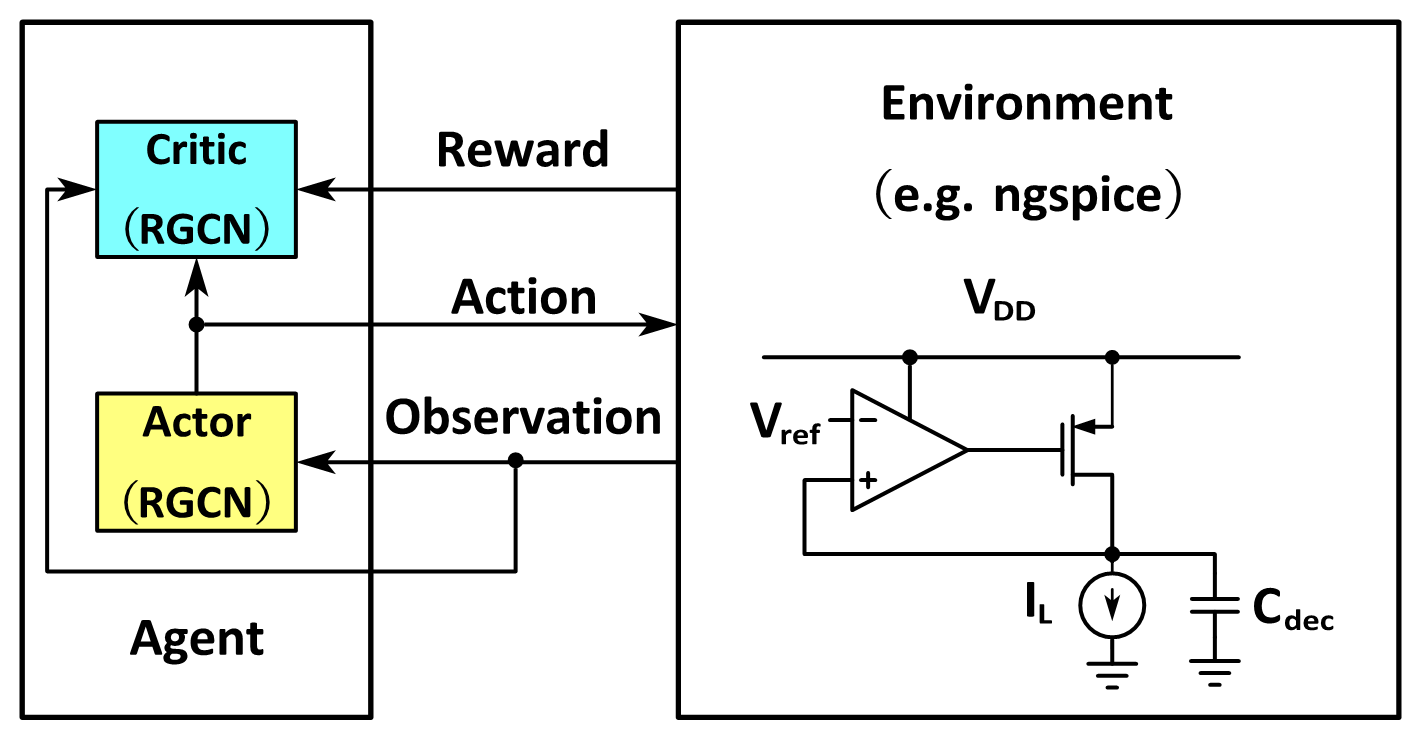

Fig. 1. Block diagram of RL.

### Actor and Critic: Relational Graph Neural Network (RGCN)



In previous work, the authors used graph convolutional neural network (GCN) as the neural network of the actor and critic for the RL. By modeling the circuit netlist as a graph, they demonstrated its superior performance and transfer learning ability compared to conventional RL. A significant advantage of GCN is its node-embedding ability, allowing it to take each node's attributes and aggregate this information with its neighboring nodes.

Mathematically, GCN can be expressed as:

$H^{l+1} = \sigma(\tilde{D}^{-0.5}\tilde{A}\tilde{D}^{-0.5}H^{(l)}W^{(l)})$

where $\tilde{A}$ is the adjacent matrix that describes the topology of the graph, $\tilde{D}$ is the degree matrix, $\sigma$ is the non-linear activation function (such as ReLU), $H^{(l)}$ is the hidden features of layer $l$, and $W$ is the layer $l$ weight shared by all edges.

Converting a circuit netlist to a graph may retain more useful topological information during the learning process. A normal graph consists of two fundamental parts: nodes and edges. However, in a circuit schematic, there are certainly not only one type of edge. For example, there are nets that are primarily DC paths and some nets are small signal AC paths. Alternatively, one can also classify these edges by their connections, such as the ones that are connected to NMOS transistors and PMOS transistors, which could be two different edge types. Inspired by this observation, we applied a heterogeneous graph here to model the circuit. In particular, we used a relational graph neural network (RGCN) in this work to capture different edge types. RGCN can be formulated as [5]:

$h_{i}^{l+1} = σ(Σ_{r𝛜R}Σ_{j𝛜N_{i}^{r}}c^{-1}_{i,r}W_{r}^{(l)}h_{j}^{(l)} + W_{0}^{l}h_{i}^{l})$

The significant difference in RGCN compared to GCN is the introduction of different edge types $r$, where each edge type has an independent learnable weight matrix $W_{r}^{l}$ for layer $l$. Additionally, there is an extra $W_{0}^{l}$ matrix designated for self-connection node's edge. $N_{i}^{r}$ indicates that node $i$ is connected with edge type $r$. Therefore, RGCN was used as our actor and critic networks, and we hope that it can preserve more circuit topological knowledge than GCN.

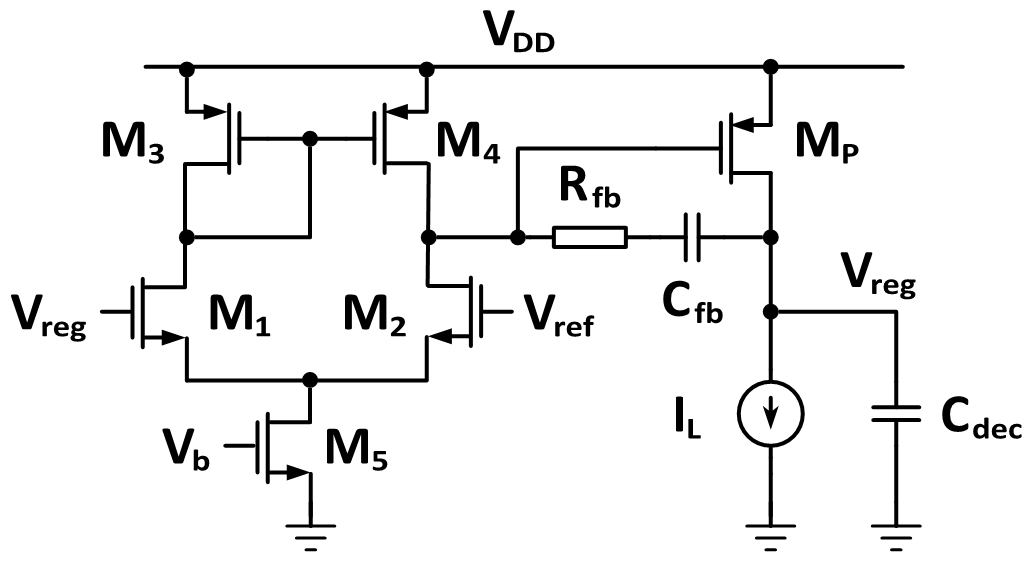

Fig. 2. LDO circuit diagram

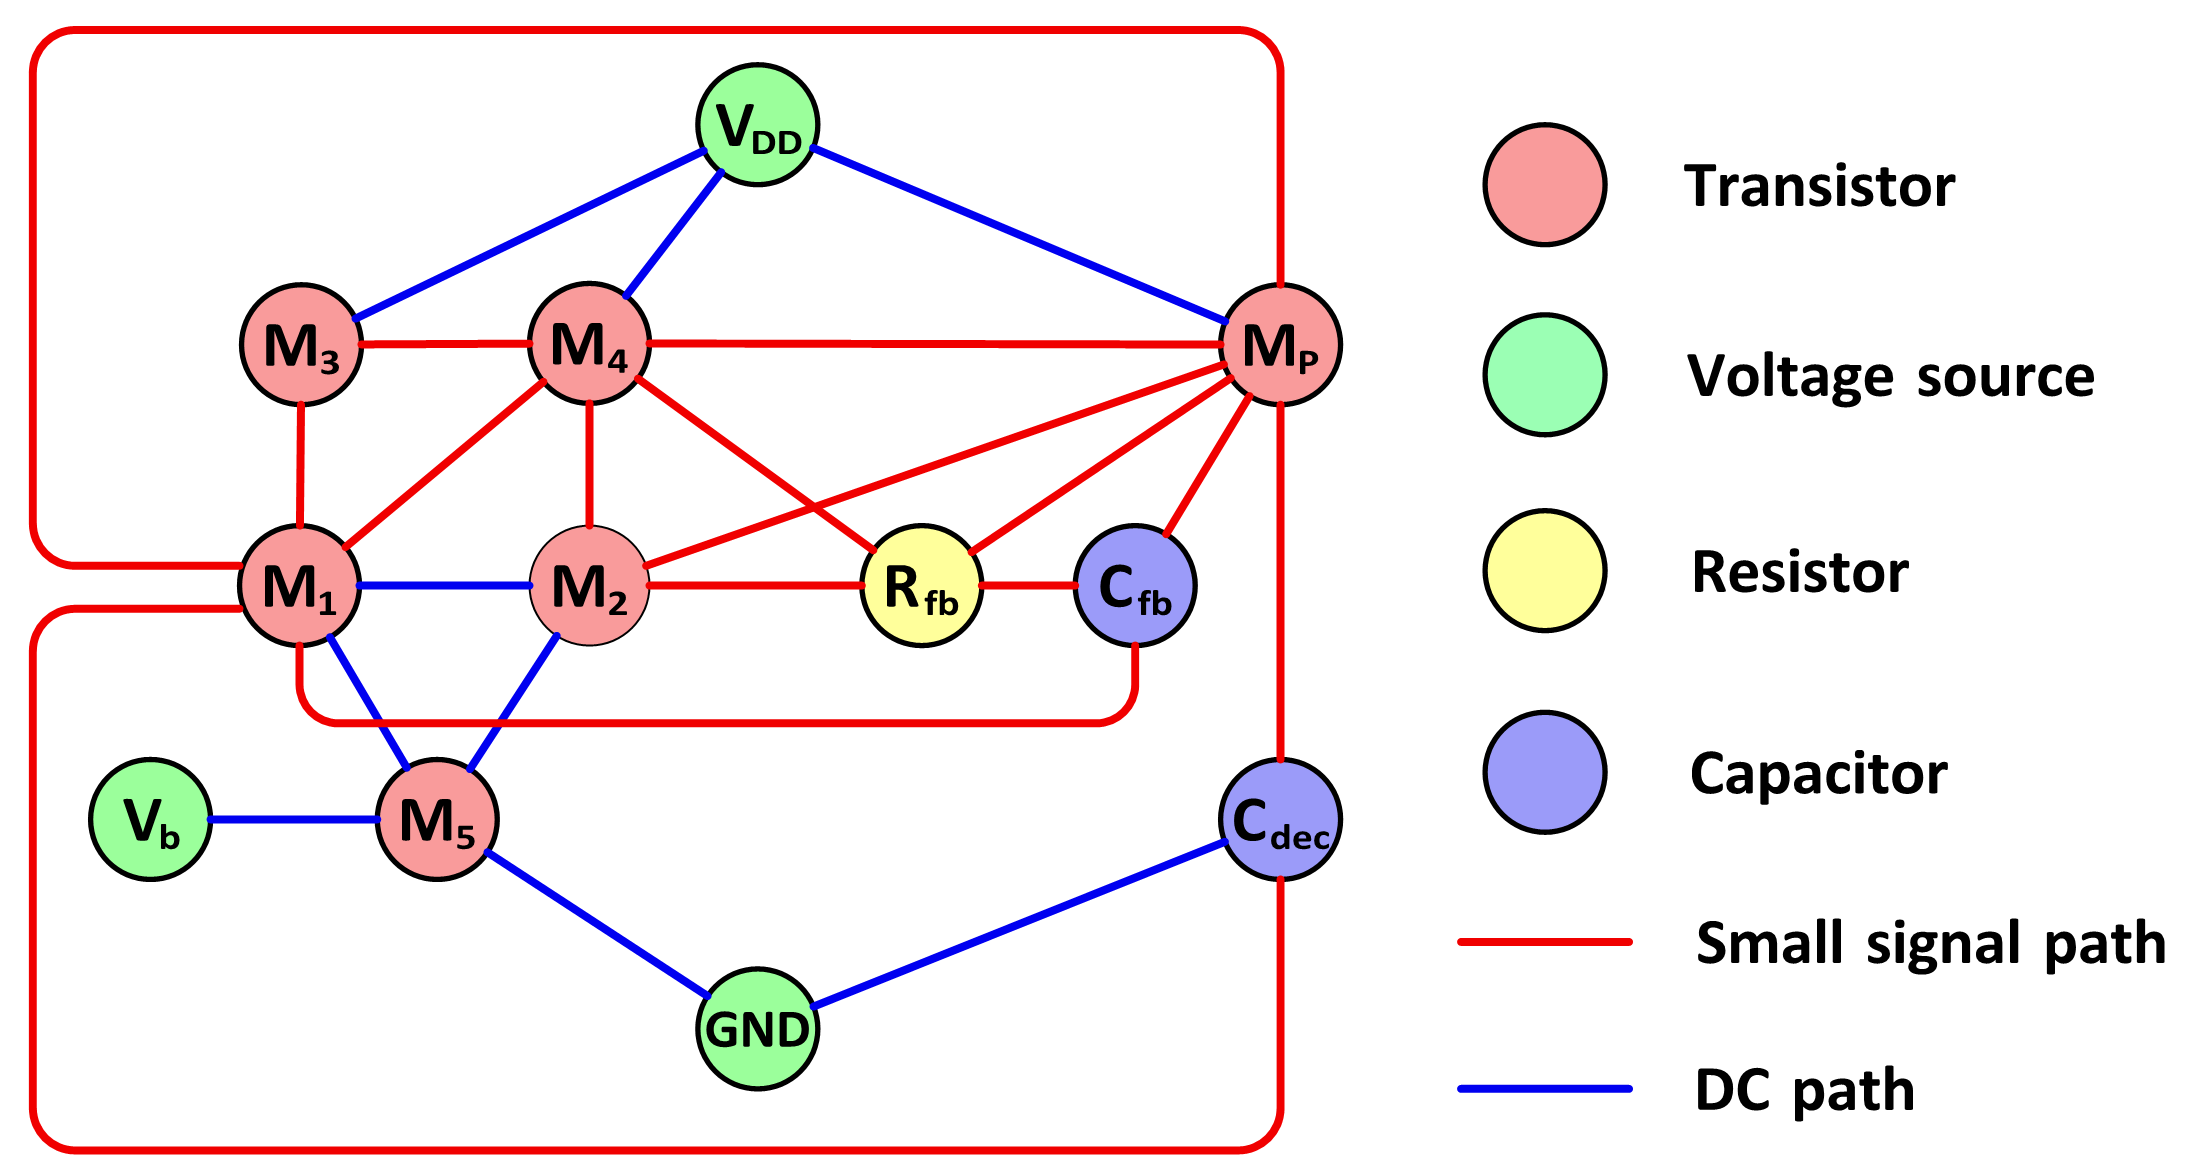

Fig. 3. RGCN representation of the LDO circuit in Fig. 2.

In this work, we defined two edge types: small signal paths which are for the small signal flows, and DC signal paths which are for DC biasings. Figure 2 shows the schematic of the LDO circuit used in this work, which consists of a simple diff-pair error amplifier ($M_{1}-M_{5}$) and a PMOS pass transistor ($M_{P}$). Miller compensation ($R_{fb}$ and $C_{fb}$) was used to improve the stability. Note that in this work, we did not consider the nonidealities in the voltage source for $V_{ref}$. For simplicity, we trained the LDO with $V_{ref}=1.8\,V$ and a feedback factor of $\beta=1$. Additionally, we did not design the biasing circuit and assumed all biasing sources to be ideal. A large on-chip decoupling capacitor $C_{dec}$ was used to filter out high-frequency noise. The power supply $V_{DD}=2\,V$.

Figure 3 shows the RGCN representation of the LDO circuit in Figure 2, where the small signal path and DC path are colored in red and blue, respectively.

### Action



The action taken by the DDPG actor will be the circuit component parameters, forming a vector $a$. Different circuit components have different parameters, but mostly will be the geometric parameters such as length, width, and multiplier. Accordingly, there will be different ranges for each of these parameters depending on the design rules.

We used high voltage transistor `nfet_g5v0d10v5` for all NMOS and `pfet_g5v0d10v5` for all PMOS. A high sheet resistance poly resistor `res_high_po_0p35` was used for $R_{fb}$ in the Miller compensation, where its width is $0.35\,\mu m$ by design rules, and we artificially fixed its length to be $1\,\mu m$ to give a unit resistor with $9355\,\Omega$. Therefore, we narrowed down the search parameter of $R_{fb}$ to its multiplier that goes between $[1, 20]$, which corresponds to a range of resistance $[476.7, 9355]\,\Omega$. The mim cap `cap_mim_m3_1` is used for $C_{fb}$ and $C_{dec}$. For $C_{fb}$, its length and width are fixed at $10\,\mu m$, and its multiplier is within the range $[1, 50]$, yielding a range of capacitance $[0.2076, 10.38]\,pF$. For $C_{dec}$, its length and width are fixed at $30\,\mu m$, and its multiplier is within the range $[10, 300]$, yielding a range of capacitance $[18.23, 546.8]\,pF$. The largest $C_{L}$ occupies $0.27\,mm^{2}$, which is about $2.7\%$ of the total chip area ($10\,mm^{2}$) of the MPW program, so it is reasonable. The ideal biasing voltage $V_{b}$ is set to a range of $[0.9, 1.4]\,V$. We selected this range because the threshold voltage for `nfet_g5v0d10v5` is about $0.8-1.1\,V$. Regarding the parameter range for the transistors, they are summarized in Table I. Note that due to the symmetry of the differential amplifier, $M_{1}$ and $M_{2}$ should match, and $M_{3}$ and $M_{4}$ should match.



<h4><center>Table. I. Actor action range for each circuit component</center></h4>

\begin{array}{|c|c|c|c|c|}
\hline
 & W\,(\mu m) & L\,(\mu m) & M & V\\
\hline
M_{1} - M_{5} & [1,100] & [0.5, 2] & 1 &\\
\hline
M_{P} & [10,100] & [0.5,1] & [100, 2000] &\\
\hline
R_{fb} & 0.35 & 1 & [1,20] &\\
\hline
C_{fb} & 10 & 10 & [1,50] &\\
\hline
C_{dec} & 30 & 30 & [10,300] & \\
\hline
V_{b} & & & & [0.9, 1.4] \\
\hline
\end{array}






Since the action vector $a'$ will be at the output of the actor, whose last layer will have a non-linear activation function (tanh in this case), $a'$ will have a range of $[-1,1]$.

It is important for the DDPG agent to explore before exploiting so that it can discover more diverse action options. To help the agent explore the action space, adding noise to the action output is a common method. It has been shown that uncorrelated Gaussian noise can achieve a nice balance between exploration and exploitation [6]. However, we noticed that in our experiments during the initial stage of exploration where the noise variance is high, the actions are usually clipped to either -1 or 1 since the Gaussian noise has no boundary. Therefore, in this work, we used truncated Gaussian noise bounded by $[-1,1]$ to aid the DDPG agent in exploring the action space. In particular, the mean of this truncated Gaussian noise will be $a'$, and the initial noise standard deviation will be 2 with a decay factor of $\sigma=0.999$.

Afterward, we need to scale this action vector $a'$ back to its normal value. As each entry of $a'$ has been assigned a range, as shown in Table I, we use the following min-max de-normalization:

$a = a'(\frac{a_{max} - a_{min}}{2}) + (\frac{a_{max} + a_{min}}{2})$

Finally, such an action vector $a=[W_{1},L_{1},W_{3},L_{3},W_{5},L_{5},W_{P}, L_{P}, M_{P}, M_{R_{fb}}, M_{C_{fb}}, M_{C_{L}}, V_{b}]$ can then be passed to the environment for simulation.

### Observation



In each step of RL, the environment feeds back the observations to the agent. These observations are the attributes of each node (circuit components). There are four different node types in this circuit: transistor, voltage source, resistor, and capacitor. For transistors, the node attributes will be a vector containing some essential attributes of a transistor:

$[i_{d}, g_{m}, g_{ds}, V_{th}, V_{dsat}, V_{ds}, V_{gs}]$

The observation matrix $X$ will be the input to the agent, and it is generated by concatenating each component's attribute vector row-wise. Note that we padded the attribute vectors with zeros to ensure they are all the same size.

\begin{align}
X = 
        \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & i_{d,M_{1}} & g_{m,M_{1}} & g_{ds,M_{1}} & V_{th,M_{1}} & V_{dsat,M_{1}} & V_{ds,M_{1}} & V_{gs,M_{1}}\\
0 & 0 & 0 & 0 & 0 & i_{d,M_{2}} & g_{m,M_{2}} & g_{ds,M_{2}} & V_{th,M_{2}} & V_{dsat,M_{2}} & V_{ds,M_{2}} & V_{gs,M_{2}}\\
0 & 0 & 0 & 0 & 0 & i_{d,M_{3}} & g_{m,M_{3}} & g_{ds,M_{3}} & V_{th,M_{3}} & V_{dsat,M_{3}} & V_{ds,M_{3}} & V_{gs,M_{2}}\\
0 & 0 & 0 & 0 & 0 & i_{d,M_{4}} & g_{m,M_{4}} & g_{ds,M_{4}} & V_{th,M_{4}} & V_{dsat,M_{4}} & V_{ds,M_{4}} & V_{gs,M_{4}}\\
0 & 0 & 0 & 0 & 0 & i_{d,M_{5}} & g_{m,M_{5}} & g_{ds,M_{5}} & V_{th,M_{5}} & V_{dsat,M_{5}} & V_{ds,M_{5}} & V_{gs,M_{5}}\\
0 & 0 & 0 & 0 & 0 & i_{d,M_{P}} & g_{m,M_{P}} & g_{ds,M_{P}} & V_{th,M_{P}} & V_{dsat,M_{P}} & V_{ds,M_{P}} & V_{gs,M_{P}}\\
V_{b} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & V_{DD} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & GND & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & R_{fb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & C_{fb} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
        \end{pmatrix}
    \end{align}

It is important to normalize these attributes across the RL steps. However, it is hard to precisely tell the lower and upper bound of these transistor attributes. Therefore, we seek to use Z-score standarization to do the feature scaling. To obtain the mean and variance of these attributes, we could first run some (such as 100) cheap operation point `OP` analysis of this circuit in ngspice over some randomly sampled device parameters bounded by certain range. Then we can obtain the mean and variance of these transistor attributes. We did this rather than using techniques such as calculating the moving mean/variance and only calculating the mean and variance over different components in that single RL step, was because we did not want these normalized observations change by the RL step. In addition, since DDPG is an off-policy method, it can be trained with off-line dataset. Therefore, these `OP` simulation results could be reused.

After obtaining the mean and variance infomation of the transistors, Z-score normalization can be applied to these transistor attributes.

$X^{'} = \dfrac{X-\mu}{\sigma}$

For passive components where their resistance or capacitance range are clearly defined, the following min-max normalization is used:

$X^{'} = \dfrac{X_{max} - X_{min}}{2} X + \dfrac{X_{max} + X_{min}}{2}$

Finally, we will clip all the input feature to be within $[-5,5]$. 

### Reward



The design of the reward function is critical to the performance of RL since it guides the agent to explore the design space. The reward function $R$ will depend on the specifications of the circuit. Table II summarizes the desired specifications that we may want from the LDO circuit in Figure 2. Note that the PSRR and PM requirements are posed for $I_{L,min}$ and $I_{L,max}$ since the loop-gain and stability of the LDO depend on the load conditions. Since different specifications have different scales and units, the following potential-based reward function is a popular choice:

$R = \sum_{i=1}^N w_{i}\beta_{i} min\{\dfrac{O_{i}-O_{i}^{*}}{O_{i}+O_{i}^{*}},0\}$

The simulation results are denoted as $O$, and the desired specifications are denoted as $O^{*}$. Depending on whether the optimization task for a specification is a minimization or a maximization job, $\beta$ would be either -1 or 1, respectively. With this reward normalization, the score for each specification will be bounded by $[-1,0]$, and once a specification is met, no more extra score will be given towards that specification so that overdesign is avoided. In this work, we aim to achieve reasonably good PSRR over a wide bandwidth for the LDO rather than spending too much attention on optimizing PSRR at DC since more noise is present around the MHz-GHz range in reality [7]. Therefore, we assign a weight of 0.5 for $PSRR_{\leq10kHz}$ and a weight of 1 for the rest. In addition, we introduce some clipped penalties for certain specifications so that the RL agent can rule out designs that are not valid. For instance, we do not want any LDO design to have a positive PSRR value at any frequency point, and any design that violates this rule will receive a -1 score for the PSRR reward. The same rule applies to the PM, which determines the stability of the LDO. We impose a strict rule on the LDO PM that any design whose loop-gain PM is below 45 degrees will receive a -2 reward, so that no matter how good the PSRR performance is, the design will be deemed unacceptable. Finally, we also would like to have the decoupling capacitor $C_{dec}$ be small once all the rest specifications are met. The reason behind this decision is that it is pointless to focus on decreasing the size of $C_{dec}$ if other hard performance specifications are not satisfied yet.

<h4><center>Table. II. Desired specifications for the LDO</center></h4>

\begin{array}{|c|c|c|c|c|c|c|}
\hline
V_{DD}\,(V) & V_{reg}\,(V) & V_{drop}\,(mV) & I_{L} & PSRR_{\leq10kHz}\,(dB) & PSRR_{\leq1MHz}\,(dB) & PSRR_{\geq1MHz}\,(dB) & PM\,(deg) & I_{q}\,(\mu A) & ΔV_{reg}\,(mV)\\
\hline
2 & 1.8 & \leq200 & [10\,\mu A,10\,mA] & \leq-30 & \leq-20 & \leq-5 & \geq60 & \leq200 & \leq36\\
\hline
\end{array}

## III. Run Experiments
---


### Install dependencies (SKY130 PDK, Ngspice, Conda, Pytorch, PyG, Gymnasium, and tabulate)

Noted that after the installation of these packages, **you may need to restart the runtime to use these newly installed packages**.

In [ ]:
import os

# install conda.
CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

# install sky130a
!conda install -c litex-hub open_pdks.sky130a

# install ngspice
!conda install -c conda-forge ngspice

# Install Pytorch with cpu-only option.
!conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 cpuonly -c pytorch

# Check the version of Python (should be larger than 3.7) and Pytorch.
import torch
import sys
print("Python version")
print (sys.version)

!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"

# Install PyG to enable graph neural networks. We need to manually guide Colab to install the correct version of PyG based on which Pytorch version we have installed 
# (https://colab.research.google.com/drive/17VFsRZeZa7rgtrQ39-RMiYIE0ePrSlgN?authuser=1#scrollTo=rFwf_0DrvXLv). In this case it is 1.13.1 with cpu-only option.
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cpu.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cpu.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.13.1+cpu.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.13.1+cpu.html
!pip install torch-geometric

# Check the version of PyG.
import torch_geometric
print(torch_geometric.__version__)

# Install Gymnasium for the RL environment.
!pip install gymnasium

# Check Gymnasium version.
import gymnasium as gym
print(gym.__version__)

# Install tabulate for showing simulation results nicely during the runtime later.
!pip install tabulate

# Similarly, check tabulate version.
import tabulate
print(tabulate.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:25
🔁 Restarting kernel...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - open_pdks.sky130a


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-23.1.0               |   py39hf3d152e_0         906 KB  conda-forge
    open_pdks.sky130a-1.0.403_0_g12df12e|  20230225_164303       121.9 MB  litex-hub
    openssl-3.1.0              |       h0b41bf4_0      

2.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.4 MB/s eta 0:00:00


0.27.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0.9.0


### Setting up SKY130 circuit simulation environment


Create some directory to organize files.

In [ ]:
!mkdir sky130_ldo 
!mkdir sky130_ldo/simulations
!mkdir sky130_ldo/saved_weights
!mkdir sky130_ldo/saved_memories

Setting up Ngspice initialization for SKY130. Also do use 8 threads to speed up simulations.

In [ ]:
%%writefile /content/sky130_ldo/simulations/.spiceinit
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
set ngbehavior=hsa
* "nomodcheck" speeds up loading time
set ng_nomodcheck
set num_threads=8

Writing /content/sky130_ldo/simulations/.spiceinit


Write LDO netlist. Noticed that it calls the analysis and variables of the netlist from another two spice scripts (`ldo_tb_analysis.spice` and `ldo_tb_vars.spice`). We will include them later.

In [ ]:
%%writefile /content/sky130_ldo/simulations/ldo_tb.spice
** sch_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/ldo_tb.sch
**.subckt ldo_tb Vreg Vreg1
*.opin Vreg
*.opin Vreg1
Vref Vref GND Vref
.save i(vref)
Vb net1 GND Vb
.save i(vb)
IL Vreg net2 dc IL PULSE(10u IL 0 10n 10n 50u 100u 0)
Vdd Vdd GND ac 1 dc Vdd
.save i(vdd)
x1 Vdd Vreg Vref net1 GND Vreg ldo
XCL Vreg GND sky130_fd_pr__cap_mim_m3_1 W=30 L=30 MF=M_CL m=M_CL
Rdummy net2 GND 1 m=1
Vref1 Vref1 GND Vref
.save i(vref1)
Vb1 net3 GND Vb
.save i(vb1)
IL1 Vreg1 GND IL
Vdd1 Vdd1 GND Vdd
.save i(vdd1)
x2 Vdd1 net4 Vref1 net3 GND Vreg1 ldo
XCL1 Vreg1 GND sky130_fd_pr__cap_mim_m3_1 W=30 L=30 MF=M_CL m=M_CL
Vprobe2 probe net4 dc 0
.save i(vprobe2)
Vprobe1 probe Vreg1 dc 0 ac 1
.save i(vprobe1)
Iprobe1 GND probe dc 0 ac 0
**** begin user architecture code

* Not loading the entire design corner which takes too long
*.lib /usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice tt

* Instead just load tt corner which is faster
.param mc_mm_switch=0
.param mc_pr_switch=0
.include /usr/local/share/pdk/sky130A/libs.tech/ngspice/corners/tt.spice
.include /usr/local/share/pdk/sky130A/libs.tech/ngspice/r+c/res_typical__cap_typical.spice
.include /usr/local/share/pdk/sky130A/libs.tech/ngspice/r+c/res_typical__cap_typical__lin.spice
.include /usr/local/share/pdk/sky130A/libs.tech/ngspice/corners/tt/specialized_cells.spice

.control
* save all voltage and current
save all
.options savecurrents 
set filetype=ascii
set units=degrees

.include /content/sky130_ldo/simulations/ldo_tb_analysis.spice
.endc

.include /content/sky130_ldo/simulations/ldo_tb_vars.spice

**** end user architecture code
**.ends

* expanding   symbol:  ldo.sym # of pins=6
** sym_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/ldo.sym
** sch_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/ldo.sch
.subckt ldo Vdd Vfb Vref Vb Vss Vreg
*.iopin Vb
*.iopin Vss
*.opin Vreg
*.iopin Vref
*.ipin Vdd
*.iopin Vfb
x1 Vdd net1 Vfb Vref Vb Vss diff_pair
XM6 Vreg net1 Vdd Vdd sky130_fd_pr__pfet_g5v0d10v5 L=L_pass W=W_pass nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=M_pass m=M_pass
XCfb net2 Vreg sky130_fd_pr__cap_mim_m3_1 W=10 L=10 MF=M_Cfb m=M_Cfb
XRfb net2 net1 Vss sky130_fd_pr__res_high_po_0p35 L=3 mult=M_Rfb m=M_Rfb
.ends


* expanding   symbol:  diff_pair.sym # of pins=6
** sym_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/diff_pair.sym
** sch_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/diff_pair.sch
.subckt diff_pair Vdd vout vinp vinm Vb Vss
*.iopin Vdd
*.ipin vinm
*.ipin vinp
*.iopin Vb
*.opin vout
*.iopin Vss
XM1 net1 vinp net2 Vss sky130_fd_pr__nfet_g5v0d10v5 L=L_M1 W=W_M1 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM2 vout vinm net2 Vss sky130_fd_pr__nfet_g5v0d10v5 L=L_M2 W=W_M2 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM3 vout net1 Vdd Vdd sky130_fd_pr__pfet_g5v0d10v5 L=L_M3 W=W_M3 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM4 net1 net1 Vdd Vdd sky130_fd_pr__pfet_g5v0d10v5 L=L_M4 W=W_M4 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM5 net2 Vb Vss Vss sky130_fd_pr__nfet_g5v0d10v5 L=L_M5 W=W_M5 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
.ends

.GLOBAL GND
.end


Writing /content/sky130_ldo/simulations/ldo_tb.spice


Write the netlist parameters to `ldo_tb_vars.spice`. Noted that the numbers we provided here are final optimization results given by the DDPG. These numbers can be some randomly sampled values within the action range.

In [ ]:
%%writefile /content/sky130_ldo/simulations/ldo_tb_vars.spice
.param W_M1=4.46430629491806 L_M1=1.8920334428548813
.param W_M2=W_M1 L_M2=L_M1
.param W_M3=93.04434376955032 L_M3=0.5856720358133316
.param W_M4=W_M3 L_M4=L_M3
.param W_M5=57.478344298899174 L_M5=0.6933765411376953
.param W_pass=24.390239119529724 L_pass=0.5027270913124084 M_pass=300
.param Vb=1.1678232248872518
.param M_Rfb=1 M_Cfb=1
.param M_CL=257
.param Vdd=2
.param Vref=1.8
.param IL=10m

Writing /content/sky130_ldo/simulations/ldo_tb_vars.spice


Write the testbench analysis to `ldo_tb_analysis.spice`. Noticed that we commented out line regulation simulations to save simulation time. We did not embed any line regulation specifications in our reward function yet, but you can run the simulations afterward with line regulation test to see how it performs.

In [ ]:
%%writefile /content/sky130_ldo/simulations/ldo_tb_analysis.spice
* high precision simulation
*.OPTIONS maxord=1
.OPTIONS itl1=200
.OPTIONS itl2=200
.OPTIONS itl4=200

* Loop stability
* http://education.ingenazure.com/ac-stability-analysis-ngspice/
alter IL1 dc=10u
let runs=2
let run=0

alter @Vprobe1[acmag]=1
alter @Iprobe1[acmag]=0

dowhile run<runs
set run=$&run
set temp=27

ac dec 10 1 10G

alter @Vprobe1[acmag]=0
alter @Iprobe1[acmag]=1

let run=run+1
end

let ip11 = ac1.i(Vprobe1)
let ip12 = ac1.i(Vprobe2)
let ip21 = ac2.i(Vprobe1)
let ip22 = ac2.i(Vprobe2)
let vprb1 = ac1.v(probe)
let vprb2 = ac2.v(probe)

*** Middlebrook
let mb = 1/(vprb1+ip22)-1
*** Tian that is preferred
let av = 1/(1/(2*(ip11*vprb2-vprb1*ip21)+vprb1+ip21)-1)

plot vdb(mb) vp(mb)
plot vdb(av) vp(av)

wrdata /content/sky130_ldo/simulations/ldo_tb_loop_gain_minload mag(av) vp(av)

* at max load
reset all
alter IL1 dc=10m
let runs=2
let run=0

alter @Vprobe1[acmag]=1
alter @Iprobe1[acmag]=0

dowhile run<runs
set run=$&run
set temp=27

ac dec 10 1 10G

alter @Vprobe1[acmag]=0
alter @Iprobe1[acmag]=1

let run=run+1
end

let ip11 = ac3.i(Vprobe1)
let ip12 = ac3.i(Vprobe2)
let ip21 = ac4.i(Vprobe1)
let ip22 = ac4.i(Vprobe2)
let vprb1 = ac3.v(probe)
let vprb2 = ac4.v(probe)

*** Middlebrook
let mb = 1/(vprb1+ip22)-1
*** Tian that is preferred
let av = 1/(1/(2*(ip11*vprb2-vprb1*ip21)+vprb1+ip21)-1)

plot vdb(mb) vp(mb)
plot vdb(av) vp(av)

wrdata /content/sky130_ldo/simulations/ldo_tb_loop_gain_maxload mag(av) vp(av)

* DC sweep
dc Vdd 1 3 0.01
plot v(Vdd) v(Vreg)
wrdata /content/sky130_ldo/simulations/ldo_tb_dc v(Vreg)

* Transient analysis with load regulation
* do not miss the space between the square bracket and number
tran 10n 100u
plot @Rdummy[i]
plot Vreg
wrdata /content/sky130_ldo/simulations/ldo_tb_load_reg Vreg
wrdata /content/sky130_ldo/simulations/ldo_tb_load_reg_current @Rdummy[i] 

* Transient analysis with line regulation
* at minimum load current 10uA
*alter @IL[PULSE] [ 10u 10u 0 10n 10n 100u 100u 0 ]
*alter @Vdd[PULSE] [ 2 3 0 1u 1u 25u 50u 0 ]
*tran 10n 100u
*plot Vdd
*plot @Rdummy[i]
*plot Vreg
*wrdata /content/sky130_ldo/simulations/ldo_tb_line_reg_minload Vreg
*wrdata /content/sky130_ldo/simulations/ldo_tb_line_reg_Vdd Vdd

* at maximum load current 10mA
*alter @IL[PULSE] [ 10m 10m 0 10n 10n 100u 100u 0 ]
*tran 10n 100u
*plot @Rdummy[i]
*plot Vreg
*wrdata /content/sky130_ldo/simulations/ldo_tb_line_reg_maxload Vreg

* PSRR with max load
ac dec 10 1 10G
plot vdb(Vreg)
wrdata /content/sky130_ldo/simulations/ldo_tb_psrr_maxload mag(Vreg) vp(Vreg)

* PSRR with min load
alter IL dc=10u
ac dec 10 1 10G
plot vdb(Vreg)
wrdata /content/sky130_ldo/simulations/ldo_tb_psrr_minload mag(Vreg) vp(Vreg)

* OP
op
alter IL dc=10u 
.include /content/sky130_ldo/simulations/ldo_tb_dev_params.spice




Writing /content/sky130_ldo/simulations/ldo_tb_analysis.spice


If you examine the `ldo_tb_analysis.spice` file, you will notice that we need to incorporate a file named `ldo_tb_dev_params.spice` in it. This is a script that assists in the extraction of all potentially useful device attributes during `OP` analysis. To automate the generation of this file, we have created some scripts that will be presented subsequently.

Initially, we require a script that can describe a circuit topology and its constituent circuit components, along with all other electrical properties and specifications that we desire. `ckt_graphs.py` fulfills this role. We utilize `ckt_hierarchy` to describe the circuit components, except for resistors, as we were unable to extract the resistance value directly from the resistor model in this PDK after the OP analysis. Instead, we calculate the resistance values using the sheet resistance and resistor geometric parameters. Class attributes such as `edge_type` and `edge_index` are used to construct the RGCN. `action_space_low` and `action_space_high` define the action space. Finally, the desirable circuit specifications are included at the end.

In [ ]:
''' ckt_graphs.py '''

import torch
import numpy as np

class GraphLDO:
    """

        Here is a graph discription for the simple LDO:


                       Vdd 
             _______________________________________
             |            |                         |
           M4____________M3                         |
             |____|       |                         |
             |            |-------------------------M6
             |            |           |_Rfb__Cfb____|
           Vreg-M1_____M2-Vref                      |_______________Vreg
                 |                                        |        |
            Vb---M5                             |--------------|   |
                 |                              |       CL     |   IL
                 |                              |    decap     |   |
                 |                              |--------------|   |
                  -------------------------------------------------------
                        GND

    node 0 will be M1
    node 1 will be M2
    node 2 will be M3
    node 3 will be M4
    node 4 will be M5
    node 5 will be M6
    node 6 will be Vb
    node 7 will be Vdd
    node 8 will be GND
    node 9 will be Rfb
    node 10 will be Cfb
    node 11 will be CL decap

    """
    def __init__(self):
        
        self.device = torch.device(
           "cpu"
        )

        # we do not include R here since, it is not straght forward to get the resistance from resistor
        # in SKY130 PDK
        self.ckt_hierarchy = (('M1','x1.x1.XM1','nfet_g5v0d10v5','m'),
                      ('M2','x1.x1.XM2','nfet_g5v0d10v5','m'),
                      ('M3','x1.x1.XM3','pfet_g5v0d10v5','m'),
                      ('M4','x1.x1.XM4','pfet_g5v0d10v5','m'),
                      ('M5','x1.x1.XM5','nfet_g5v0d10v5','m'),
                      ('M6','x1.XM6','pfet_g5v0d10v5','m'),
                      ('Vb','','Vb','v'),
                      
                      ('Cfb','x1.XCfb','cap_mim_m3_1','c'),
                      ('CL','XCL','cap_mim_m3_1','c')
                     )    

        self.op = {'M1':{},
                'M2':{},
                'M3':{},
                'M4':{},
                'M5':{},
                'M6':{},
                'Vb':{},
                'Cfb':{},
                'CL':{}
                 }

        self.edge_index = torch.tensor([
            [0,1], [1,0], [0,2], [2,0], [0,3], [3,0], [0,4], [4,0], [0,5], [5,0], [0,10], [10,0], [0,11], [11,0],    
            [1,2], [2,1], [1,4], [4,1], [1,5], [5,1], [1,9], [9,1],
            [2,3], [3,2], [2,5], [5,2], [2,7], [7,2], [2,9], [9,2],
            [3,7], [7,3],
            [4,6], [6,4], [4,8], [8,4],
            [5,7], [7,5], [5,9], [9,5],
            [5,10], [10,5], [5,11], [11,5],
            [9,10], [10,9],
            [10,11], [11,10],
            [11,8], [8,11]
            ], dtype=torch.long).t().to(self.device)
        
        # sorted based on if it is the small signal path
        # small signal path: 0; biasing path: 1
        self.edge_type = torch.tensor([
            0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 1, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 1, 0, 0,
            1, 1,
            1, 1, 1, 1, 
            1, 1, 0, 0, 0, 0, 0, 0, 
            0, 0,
            0, 0,
            1, 1,
            ]).to(self.device)
        
        self.num_relations = 2
        self.num_nodes = 12
        self.num_node_features = 13
        self.obs_shape = (self.num_nodes, self.num_node_features)
        
        """Select an action from the input state."""
        L_CL = 30 # each unit cap is 30um by 30um
        W_CL = 30
        M_CL_low = 10
        M_CL_high = 300 # copies of unit cap
        self.CL_low = M_CL_low * (L_CL*W_CL*2e-15+(L_CL+W_CL)*0.38e-15)
        self.CL_high = M_CL_high * (L_CL*W_CL*2e-15+(L_CL+W_CL)*0.38e-15)
       
        self.W_Rfb = 0.35 # W: 0.35um
        self.L_Rfb = 3 # L: 3um
        M_Rfb_low = 1
        M_Rfb_high = 20
        self.Rsheet = 1112.4
        self.Rfb_low =  self.Rsheet * self.L_Rfb / self.W_Rfb / M_Rfb_high  
        self.Rfb_high = self.Rsheet * self.L_Rfb / self.W_Rfb / M_Rfb_low 
        
        W_Cfb = 10
        L_Cfb = 10
        M_Cfb_low = 1
        M_Cfb_high = 50
        self.Cfb_low = M_Cfb_low * (L_Cfb*W_Cfb*2e-15+(L_Cfb+W_Cfb)*0.38e-15)
        self.Cfb_high = M_Cfb_high * (L_Cfb*W_Cfb*2e-15+(L_Cfb+W_Cfb)*0.38e-15)
 
        self.action_space_low = np.array([ 1, 0.5, 
                                            1, 0.5,
                                            1, 0.5,
                                            10, 0.5, 100,
                                            0.9,
                                            M_Rfb_low, #Rfb
                                            M_Cfb_low, #Cfb
                                            M_CL_low, # CL
                                            ]) 
        
        self.action_space_high = np.array([100, 2,
                                            100, 2,
                                            100, 2,
                                            100, 1, 2000,
                                            1.4,
                                            M_Rfb_high, #Rfb
                                            M_Cfb_high, #Cfb
                                            M_CL_high, # CL
                                            ]) 
        
        self.action_dim =len(self.action_space_low)
        self.action_shape = (self.action_dim,)    
        
        """Some target specifications for the final design"""
        self.Vdrop_target = 0.22  # drop-out voltage
        
        self.PSRR_target_1kHz = 10**(-30/20) # in linear scale, equals -30dB
        self.PSRR_target_10kHz = 10**(-30/20) # in linear scale, equals -30dB
        self.PSRR_target_1MHz =  10**(-20/20) # in linear scale, equals -20dB
        self.PSRR_target_above_1MHz =  10**(-5/20) # in linear scale, equals -5dB
        self.PSRR_1kHz = 1e3 #  from DC to 1kHz
        self.PSRR_10kHz = 1e4 #  from DC to 10kHz
        self.PSRR_1MHz = 1e6  # from DC to 1 MHz
        
        self.phase_margin_target = 60 # 60 degree PM minimum, this is for the loop-gain
        self.Vreg = 1.8 # regulated output
        self.Vref = 1.8 # reference voltage
        self.GND = 0
        self.Vdd = 2
        
        self.Vload_reg_delta_target = self.Vreg * 0.02 # load regulartion variation is at most 2% of Vreg when it is switched from ILmin to ILmax
        self.Iq_target = 200e-6 #200uA quiescent current maximum
        self.Vline_reg_delta_target =  self.Vreg * 0.02  # line reg voltage to be around at most 2% of Vreg when it is at both ILmin and ILmax
        

Now, let's go back and introduce `dev_params.py`, which is capable of automatically generating the script `ldo_tb_dev_params.spice` based on the ckt_hierarchy defined in `ckt_graphs.py`. After the OP analysis is done, all the device parameters will be saved to a file called `ldo_tb_op`. Now, we can run `dev_params.py` to generate `ldo_tb_dev_params.spice`.

In [ ]:
''' dev_params.py '''

SPICE_NETLIST_DIR = '/content/sky130_ldo/simulations'

class DeviceParams(object):
    def __init__(self, ckt_hierarchy, warning_msg=False):
        self.ckt_hierarchy = ckt_hierarchy
        self.dev_names_mos = (
            'nfet3_01v8',
            'nfet3_01v8_lvt',
            'nfet3_03v3_nvt',
            'nfet3_05v0_nvt',
            'nfet3_20v0',
            'nfet3_g5v0d10v5',
            'nfet3_g5v0d16v0',
            'nfet_01v8',
            'nfet_01v8_esd',
            'nfet_01v8_lvt',
            'nfet_01v8lvt_nf'
            'nfet_01v8_nf',
            'nfet_03v3_nvt',
            'nfet_03v3_nvt_nf',
            'nfet_05v0_nvt',
            'nfet_05v0_nvt_nf',
            'nfet_20v0_iso',
            'nfet_20v0_nvt',
            'nfet_20v0_zvt',
            'nfet_g5v0d10v5',
            'nfet_g5v0d10v5_esd',
            'nfet_g5v0d10v5_nf',
            'nfet_g5v0d10v5_nvt_esd',
            'nfet_g5v0d16v0',
            'nfet_g5v0d16v0_nf',
            'pfet3_01v8',
            'pfet3_01v8',
            'pfet3_01v8',
            'pfet3_20v0',
            'pfet3_g5v0d10v5',
            'pfet3_g5v0d16v0',
            'pfet_01v8',
            'pfet_01v8_hvt',
            'pfet_01v8_hvt_nf',
            'pfet_01v8_lvt',
            'pfet_01v8_lvt_nf',
            'pfet_01v8_nf',
            'pfet_20v0',
            'pfet_g5v0d10v5',
            'pfet_g5v0d10v5_nf',
            'pfet_g5v0d16v0',
            'pfet_g5v0d16v0_nf'
            )
        self.dev_names_r = (
            'res_generic_l1',
            'res_generic_m1',
            'res_generic_m2',
            'res_generic_m3',
            'res_generic_m4',
            'res_generic_m5',
            'res_generic_nd',
            'res_generic_pd',
            'res_generic_po',
            'res_high_po',
            'res_high_po_0p35',
            'res_high_po_0p69',
            'res_high_po_1p41',
            'res_high_po_2p85',
            'res_high_po_5p73',
            'res_iso_pw',
            'res_xhigh_po',
            'res_xhigh_po_0p35',
            'res_xhigh_po_0p69',
            'res_xhigh_po_1p41',
            'res_xhigh_po_2p85',
            'res_xhigh_po_5p73'
            )
        self.dev_names_c = (
            'cap_mim_m3_1',
            'cap_mim_m3_2',
            'cap_var_hvt',
            'cap_var_lvt',
            'vpp_cap'
            )
        
        if warning_msg == True:
            for i in self.ckt_hierarchy:
                dev_name = i[2]
                dev_type = i[3]
                if dev_type == 'm' or dev_type == 'M':
                    if dev_name not in self.dev_names_mos:
                        print(f'This MOS is not in sky130 PDK. A valid device name can be {self.dev_names_mos}.')    
                elif dev_type == 'r' or dev_type == 'R':
                    if dev_name not in self.dev_names_r:
                        print(f'This resistor is not in sky130 PDK. A valid device name can be {self.dev_names_r}.')    
                elif dev_type == 'c' or dev_type == 'C':
                    if dev_name not in self.dev_names_c:
                        print(f'This capacitor is not in sky130 PDK. A valid device name can be {self.dev_names_c}.')    
                elif dev_type == 'i' or dev_type == 'I':
                    None
                elif dev_type == 'v' or dev_type == 'V':
                    None
                else:
                    print('You have a device type that cannot be found here...')

        # 45 attributes for mos
        self.params_mos = (
            'gmbs',
            'gm',
            'gds',
            'vdsat',
            'vth',
            'id',
            'ibd',
            'ibs',
            'gbd',
            'gbs',
            'isub',
            'igidl',
            'igisl',
            'igs',
            'igd',
            'igb',
            'igcs',
            'vbs',
            'vgs',
            'vds',
            'cgg',
            'cgs',
            'cgd',
            'cbg',
            'cbd',
            'cbs',
            'cdg',
            'cdd',
            'cds',
            'csg',
            'csd',
            'css',
            'cgb',
            'cdb',
            'csb',
            'cbb',
            'capbd',
            'capbs',
            'qg',
            'qb',
            'qs',
            'qinv',
            'qdef',
            'gcrg',
            'gtau'
            )
        # 20 attributes for r
        self.params_r = (
            'r',
            'ac',
            'temp',
            'dtemp',
            'l',
            'w',
            'm',
            'tc',
            'tc1',
            'tc2',
            'scale',
            'noise',
            'i',
            'p',
            'sens_dc',
            'sens_real',
            'sens_imag',
            'sens_mag',
            'sens_ph',
            'sens_cplx'
            )
        # 18 attributes for c
        self.params_c = (
            'capacitance',
            'cap',
            'c',
            'ic',
            'temp',
            'dtemp',
            'w',
            'l',
            'm',
            'scale',
            'i',
            'p',
            'sens_dc',
            'sens_real',
            'sens_imag',
            'sens_mag',
            'sens_ph',
            'sens_cplx'
            )
        # 8 attributes for i source
        self.params_i = (
            'dc',
            'acmag',
            'acphase',
            'acreal',
            'acimag',
            'v',
            'p',
            'current'
            )
        # 7 attributes for v source
        self.params_v = (
            'dc',
            'acmag',
            'acphase',
            'acreal',
            'acimag',
            'i',
            'p',
            )
        
    def gen_dev_params(self, file_name):
        lines = []
        write_file = ''
        for i in self.ckt_hierarchy:
            symbol_name = i[0]
            subckt = i[1]
            dev_name = i[2]
            dev_type = i[3]

            if dev_type == 'm' or dev_type == 'M':
                for param in self.params_mos:
                    if subckt == '':
                        line = f'let {param}_{symbol_name}=@{dev_name}[{param}]'
                    else:
                        if dev_name in self.dev_names_mos:
                            line = f'let {param}_{symbol_name}=@m.{subckt}.msky130_fd_pr__{dev_name}[{param}]'
                        else:
                            line = f'let {param}_{symbol_name}=@m.{subckt}.{dev_name}[{param}]'
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')
            elif dev_type == 'r' or dev_type == 'R':
                for param in self.params_r:
                    if subckt == '':
                        line = f'let {param}_{symbol_name}=@{dev_name}[{param}]'
                    else:               
                        if dev_name in self.dev_names_r:
                            raise ValueError('it is not straightforward to extract resistance info from this PDK, \
                                             so for resistance just use Rsheet * L / W for approximation. Remove the resistors from the ckt_hierarchy.')
                        else:
                            line = f'let {param}_{symbol_name}=@r.{subckt}.{dev_name}[{param}]'
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')    
            elif dev_type == 'c' or dev_type == 'C':
                for param in self.params_c:
                    if subckt == '':
                        line = f'let {param}_{symbol_name}=@{dev_name}[{param}]'
                    else:
                        if dev_name in self.dev_names_c:
                            line = f'let {param}_{symbol_name}=@c.{subckt}.c1[{param}]'
                        else:
                            line = f'let {param}_{symbol_name}=@c.{subckt}.{dev_name}[{param}]'
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')    
            elif dev_type == 'i' or dev_type == 'I':
                for param in self.params_i:
                    if subckt == '':
                        line = f'let {param}_{symbol_name}=@{dev_name}[{param}]'
                    else:
                        line = f'let {param}_{symbol_name}=@i.{subckt}.{dev_name}[{param}]'
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')    
            elif dev_type == 'v' or dev_type == 'V':
                for param in self.params_v:
                    if subckt == '':
                        line = f'let {param}_{symbol_name}=@{dev_name}[{param}]'
                    else:
                        line = f'let {param}_{symbol_name}=@v.{subckt}.{dev_name}[{param}]'
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')           
            else:
                None
                
        lines.append(f'write {file_name} ' + write_file)
        
        return lines  
            

            
if __name__ == '__main__':
    ckt_hierarchy = GraphLDO().ckt_hierarchy      
    dev_params_script = DeviceParams(ckt_hierarchy).gen_dev_params(file_name=f'{SPICE_NETLIST_DIR}/ldo_tb_op')
    
    with open(f'{SPICE_NETLIST_DIR}/ldo_tb_dev_params.spice', 'w') as f:
        for line in dev_params_script:
            f.write(f'{line}\n')    
    

The last piece we need to have is a parser that is able to quickly extract all the simulation results that we need. The following class `OutputParser` does this job.

In [ ]:
class OutputParser(DeviceParams):
    
    def __init__(self, CktGraph):
        self.ckt_hierarchy = CktGraph.ckt_hierarchy
        self.op = CktGraph.op
        super().__init__(self.ckt_hierarchy)

    def ac(self, file_name):
        # AC analysis result parser
        try:
            ldo_tb_ac = open(f'{SPICE_NETLIST_DIR}/{file_name}', 'r')
            lines_ac = ldo_tb_ac.readlines()
            freq = []
            Vout_mag = []
            Vout_ph = []
            for line in lines_ac:
                Vac = line.split(' ')
                Vac = [i for i in Vac if i != '']
                freq.append(float(Vac[0]))
                Vout_mag.append(float(Vac[1]))
                Vout_ph.append(float(Vac[3]))
            return freq, Vout_mag, Vout_ph
        except:
            print("Simulation errors, no .AC simulation results.")
            
    def dc(self, file_name):
        # DC analysis result parser
        try:
            ldo_tb_dc = open(f'{SPICE_NETLIST_DIR}/{file_name}', 'r')
            lines_dc = ldo_tb_dc.readlines()
            Vin_dc = []
            Vout_dc = []
            for line in lines_dc:
                Vdc = line.split(' ')
                Vdc = [i for i in Vdc if i != '']
                Vin_dc.append(float(Vdc[0]))
                Vout_dc.append(float(Vdc[1])) 
    
            dx = Vin_dc[1] - Vin_dc[0]
            dydx = np.gradient(Vout_dc, dx)
            
            return Vin_dc, Vout_dc
        except:
            print("Simulation errors, no .OP simulation results.")
      
    def tran(self, file_name):
        # Transient analysis result parser
        try:
            ldo_tb_tran = open(f'{SPICE_NETLIST_DIR}/{file_name}', 'r')
            lines_tran = ldo_tb_tran.readlines()
            time = []
            Vout_tran = []
            for line in lines_tran:
                line = line.split(' ')
                line = [i for i in line if i != '']
                time.append(float(line[0]))
                Vout_tran.append(float(line[1])) 
            
            return time, Vout_tran
        except:
                print("Simulation errors, no .TRAN simulation results.")

            
    def dcop(self, file_name):
        # DCOP analysis result parser
        try:
            ldo_tb_op = open(f'{SPICE_NETLIST_DIR}/{file_name}', 'r')
            # ldo_tb_op = open(f'{file_dir}', 'r')
            lines_op = ldo_tb_op.readlines()
            for index, line in enumerate(lines_op):
                if line == "Values:\n":
                    # print(f"{index}") # catch the index where the dcop values start
                    start_idx = index
            _lines_op = lines_op[start_idx+2:-1] 
            lines_op = []
            for _line in _lines_op:
                lines_op.append(float(_line.split('\n')[0].split('\t')[1]))
            
            num_dev = len(self.ckt_hierarchy)
            num_dev_params_mos = len(self.params_mos)
            num_dev_params_r = len(self.params_r)
            num_dev_params_c = len(self.params_c)
            num_dev_params_i = len(self.params_i)
            num_dev_params_v = len(self.params_v)
            
            idx = 0
            for i in range(num_dev):
                dev_type = self.ckt_hierarchy[i][3]
                if dev_type == 'm' or dev_type == 'M':
                    for j in range(num_dev_params_mos):
                        param = self.params_mos[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_mos
                elif dev_type == 'r' or dev_type == 'R':
                    for j in range(num_dev_params_r):
                        param = self.params_r[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_r
                elif dev_type == 'c' or dev_type == 'C':
                    for j in range(num_dev_params_c):
                        param = self.params_c[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_c
                elif dev_type == 'i' or dev_type == 'I':
                    for j in range(num_dev_params_i):
                        param = self.params_i[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_i
                elif dev_type == 'v' or dev_type == 'V':
                    for j in range(num_dev_params_v):
                        param = self.params_v[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_v
                else:
                    None
            
            return self.op
        except:
            print("Simulation errors, no .OP simulation results.")

With this been done, we should be able to at least run the circuit simulations on Colab (please ignore the displaying error as in Colab no plots will be shown from ngspice).

In [ ]:
!ngspice -b /content/sky130_ldo/simulations/ldo_tb.spice


Note: No compatibility mode selected!


Circuit: ** sch_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/ldo_tb.sch

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: il: dc value used for op instead of transient time=0 value.

No. of Data Rows : 101
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: il: dc value used for op instead of transient time=0 value.

No. of Data Rows : 101
ERROR: (internal)  This operation is not defined for display type PrinterOnly.
Can't open viewport for graphics.
ERROR: (internal)  This operation is not defined for display type PrinterOnly.
Can't open viewport for graphics.
reset: too many args.
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: il: dc value used for op instead of transient time=0 value.

No. of Data Rows : 101
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: il: dc value used for op instead of transient time=0 value.

No. of Data Rows : 101
ERROR: (internal)  This operation is not defined

To visualize the final simulation results, the `OutputParser` becomes very handy here.

Text(0.5, 0, 'Time ($\\mathbf{\\mu s}$)')

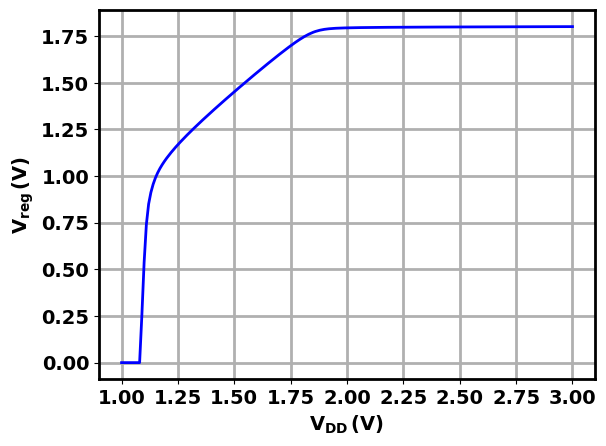

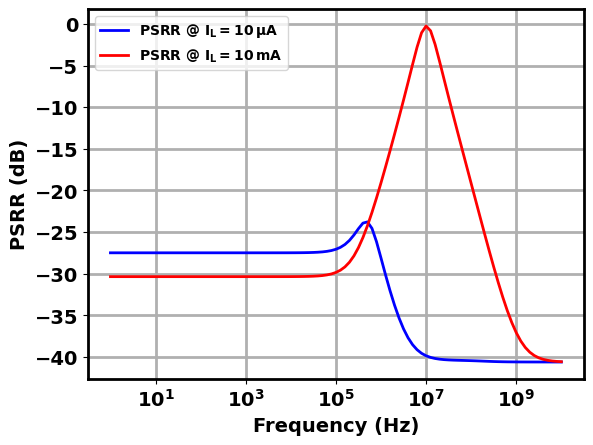

<Figure size 640x480 with 0 Axes>

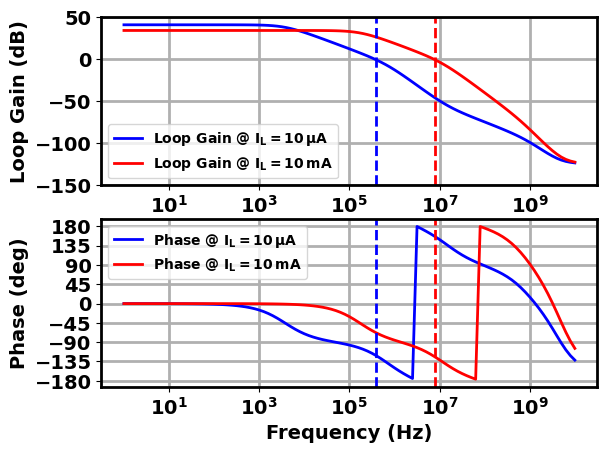

<Figure size 640x480 with 0 Axes>

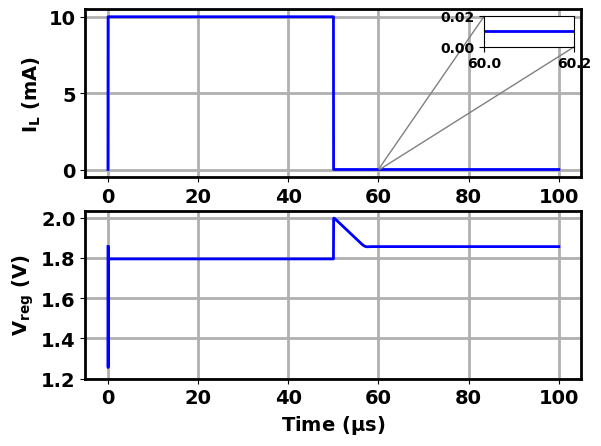

In [ ]:
import matplotlib.pyplot as plt
plt.style.use(style='default')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

sim_results = OutputParser(GraphLDO())
dc_results = sim_results.dc(file_name='ldo_tb_dc')

# plot DC response
plt.figure('DC')
Vin = dc_results[0]
Vout = [max(dc_results[1][i], 0) for i in range(len(dc_results[1]))]
plt.plot(Vin, Vout, 'b')
plt.xlabel('$\mathbf{V_{DD}\,(V)}$', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('$\mathbf{V_{reg}\,(V)}$', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(linewidth=2)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

# plot PSRR AC response
psrr_results_minload = sim_results.ac(file_name='ldo_tb_psrr_minload')
psrr_results_maxload = sim_results.ac(file_name='ldo_tb_psrr_maxload')
freq = psrr_results_minload[0]
psrr_minload = 20*np.log10(psrr_results_minload[1])
psrr_maxload = 20*np.log10(psrr_results_maxload[1])

plt.figure('PSRR')
plt.plot(freq, psrr_minload, 'b', label='PSRR @ $\mathbf{I_{L}=10\,\mu A}$')
plt.plot(freq, psrr_maxload, 'r', label='PSRR @ $\mathbf{I_{L}=10\,mA}$')
plt.xlabel('Frequency (Hz)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('PSRR (dB)', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='upper left', prop=dict(weight='bold'))
plt.grid(linewidth=2)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.set_xscale('log')

# plot loop stability
loop_gain_minload_results = sim_results.ac(file_name='ldo_tb_loop_gain_minload')
freq = loop_gain_minload_results[0]
loop_gain_minload = 20*np.log10(loop_gain_minload_results[1])
loop_gain_phase_minload = loop_gain_minload_results[2]
loop_gain_maxload_results = sim_results.ac(file_name='ldo_tb_loop_gain_maxload')
loop_gain_maxload = 20*np.log10(loop_gain_maxload_results[1])
loop_gain_phase_maxload = loop_gain_maxload_results[2]

plt.figure('Loop Gain')
fig, axs = plt.subplots(2)
axs[0].plot(freq, loop_gain_minload, 'b', label='Loop Gain @ $\mathbf{I_{L}=10\,\mu A}$')
axs[0].plot(freq, loop_gain_maxload, 'r', label='Loop Gain @ $\mathbf{I_{L}=10\,mA}$')
axs[0].set_ylabel('Loop Gain (dB)', fontweight='bold', fontsize=14)
axs[0].xaxis.set_tick_params(labelsize='14')
axs[0].yaxis.set_tick_params(labelsize='14')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_linewidth(2)
axs[0].spines['top'].set_linewidth(2)
axs[0].grid(linewidth=2)
axs[0].legend(loc='lower left', prop=dict(weight='bold'))
axs[0].set_yticks(axs[0].get_yticks()[::1])
idx_minload = [i for i in range(len(loop_gain_minload)) if loop_gain_minload[i] <=0][0]
idx_maxload = [i for i in range(len(loop_gain_maxload)) if loop_gain_maxload[i] <=0][0]
axs[0].axvline(x=freq[idx_minload], ls='--', color='b')
axs[0].axvline(x=freq[idx_maxload], ls='--', color='r')
axs[0].set_xscale('log')

axs[1].plot(freq, loop_gain_phase_minload, 'b', label='Phase @ $\mathbf{I_{L}=10\,\mu A}$')
axs[1].plot(freq, loop_gain_phase_maxload, 'r', label='Phase @ $\mathbf{I_{L}=10\,mA}$')
axs[1].set_ylabel('Phase (deg)', fontweight='bold', fontsize=14)
axs[1].xaxis.set_tick_params(labelsize='14')
axs[1].yaxis.set_tick_params(labelsize='14')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_linewidth(2)
axs[1].spines['top'].set_linewidth(2)
axs[1].grid(linewidth=2)
axs[1].legend(loc='upper left', prop=dict(weight='bold'))
axs[1].set_yticks(np.array([-180, -135, -90, -45, 0, 45, 90, 135, 180]))
axs[1].axvline(x=freq[idx_minload], ls='--', color='b')
axs[1].axvline(x=freq[idx_maxload], ls='--', color='r')
axs[1].set_xscale('log')
axs[1].set_xlabel('Frequency (Hz)', fontweight='bold', fontsize=14)

# load regulation
load_reg_results = sim_results.tran(file_name='ldo_tb_load_reg')
time = 1e6 * np.array(load_reg_results[0])
load_reg = load_reg_results[1]
load_reg_current_results = sim_results.tran(file_name='ldo_tb_load_reg_current')
load_reg_current = 1e3 * np.array(load_reg_current_results[1])

plt.figure('Load Reg')
fig, axs = plt.subplots(2)
axs[0].plot(time, load_reg_current, 'b', label='Load current')
axs[0].set_ylabel('$\mathbf{I_{L}}$ (mA)', fontweight='bold', fontsize=14)
axs[0].xaxis.set_tick_params(labelsize='14')
axs[0].yaxis.set_tick_params(labelsize='14')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_linewidth(2)
axs[0].spines['top'].set_linewidth(2)
axs[0].grid(linewidth=2)
axins = zoomed_inset_axes(axs[0], 100, loc=1) # zoom = 100
axins.plot(time, load_reg_current, color='b')
axins.set_xlim(60, 60.2) # Limit the region for zoom
axins.set_ylim(0, 0.02)
mark_inset(axs[0], axins, loc1=2, loc2=4, fc="none", ec="0.5")

axs[1].plot(time, load_reg, 'b', label='Vreg')
axs[1].set_ylabel('$\mathbf{V_{reg}}$ (V)', fontweight='bold', fontsize=14)
axs[1].xaxis.set_tick_params(labelsize='14')
axs[1].yaxis.set_tick_params(labelsize='14')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_linewidth(2)
axs[1].spines['top'].set_linewidth(2)
axs[1].grid(linewidth=2)
axs[1].set_yticks(np.array([1.2, 1.4, 1.6, 1.8, 2.0]))
axs[1].set_xlabel('Time ($\mathbf{\mu s}$)', fontweight='bold', fontsize=14)



### Setting up RL environment


Shown below are the RGCN architecture of the actor and critic of DDPG agent. We used 4 layers of RGCN in both actor and critic followed by a linear layer to generate the output.

In [ ]:
import torch
from torch.nn import LazyLinear
from torch_geometric.nn import RGCNConv
import torch.nn.functional as F

class Actor(torch.nn.Module):
    def __init__(self, CktGraph):
        super().__init__()
        self.num_node_features = CktGraph.num_node_features
        self.action_dim = CktGraph.action_dim
        self.device = CktGraph.device
        self.edge_index = CktGraph.edge_index
        self.edge_type = CktGraph.edge_type
        self.num_nodes = CktGraph.num_nodes
        self.num_relations = CktGraph.num_relations

        self.in_channels = self.num_node_features
        self.out_channels = self.action_dim
        self.conv1 = RGCNConv(self.in_channels, 32, self.num_relations,
                              num_bases=32)
        self.conv2 = RGCNConv(32, 32, self.num_relations,
                              num_bases=32)
        self.conv3 = RGCNConv(32, 16, self.num_relations,
                              num_bases=32)
        self.conv4 = RGCNConv(16, 16, self.num_relations,
                              num_bases=32)
        self.lin1 = LazyLinear(self.out_channels)

    def forward(self, state):
        if len(state.shape) == 2:  # if it is not batched graph data (only one data)
            state = state.reshape(1, state.shape[0], state.shape[1])

        batch_size = state.shape[0]
        edge_index = self.edge_index
        edge_type = self.edge_type
        device = self.device

        actions = torch.tensor(()).to(device)
        for i in range(batch_size):
            x = state[i]
            x = F.relu(self.conv1(x, edge_index, edge_type))
            x = F.relu(self.conv2(x, edge_index, edge_type))
            x = F.relu(self.conv3(x, edge_index, edge_type))
            x = F.relu(self.conv4(x, edge_index, edge_type))
            x = self.lin1(torch.flatten(x))
            x = torch.tanh(x).reshape(1, -1)
            actions = torch.cat((actions, x), axis=0)

        return actions


class Critic(torch.nn.Module):
    def __init__(self, CktGraph):
        super().__init__()
        self.num_node_features = CktGraph.num_node_features
        self.action_dim = CktGraph.action_dim
        self.device = CktGraph.device
        self.edge_index = CktGraph.edge_index
        self.edge_type = CktGraph.edge_type
        self.num_nodes = CktGraph.num_nodes
        self.num_relations = CktGraph.num_relations

        self.in_channels = self.num_node_features + self.action_dim
        self.out_channels = 1
        self.conv1 = RGCNConv(self.in_channels, 32, self.num_relations,
                              num_bases=32)
        self.conv2 = RGCNConv(32, 32, self.num_relations,
                              num_bases=32)
        self.conv3 = RGCNConv(32, 16, self.num_relations,
                              num_bases=32)
        self.conv4 = RGCNConv(16, 16, self.num_relations,
                              num_bases=32)
        self.lin1 = LazyLinear(self.out_channels)

    def forward(self, state, action):
        batch_size = state.shape[0]
        edge_index = self.edge_index
        edge_type = self.edge_type
        device = self.device

        action = action.repeat_interleave(self.num_nodes, 0).reshape(
            batch_size, self.num_nodes, -1)
        data = torch.cat((state, action), axis=2)

        values = torch.tensor(()).to(device)
        for i in range(batch_size):
            x = data[i]
            x = F.relu(self.conv1(x, edge_index, edge_type))
            x = F.relu(self.conv2(x, edge_index, edge_type))
            x = F.relu(self.conv3(x, edge_index, edge_type))
            x = F.relu(self.conv4(x, edge_index, edge_type))
            x = self.lin1(torch.flatten(x)).reshape(1, -1)
            values = torch.cat((values, x), axis=0)

        return values


As we mentioned early, the performance of ML is very sensitive to the scaling of the input. The following class `ActionNormalizer` will do the min-max normalization and de-normalization.

In [ ]:
class ActionNormalizer():
    """Rescale and relocate the actions."""
    def __init__(self, action_space_low, action_space_high):
        
        self.action_space_low = action_space_low
        self.action_space_high = action_space_high

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space_low
        high = self.action_space_high 

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space_low
        high = self.action_space_high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

Another important building block of DDPG is the replay buffer. Past experiences of the agent are important to guide exploration. It is not always good to use only recent experience. Ideally, it is beneficial to have the agent learn from more past experience in each step. However, a larger batch size may lead to a slower learning process. In this work, we chose a batch size of 128 and a total memory size of 1e5.

In [ ]:
from typing import List, Tuple, Dict

class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, CktGraph, size: int, batch_size: int = 32):

        self.num_node_features = CktGraph.num_node_features
        self.action_dim = CktGraph.action_dim
        self.num_nodes = CktGraph.num_nodes

        """Initializate."""
        self.obs_buf = np.zeros(
            [size, self.num_nodes, self.num_node_features], dtype=np.float32)
        self.next_obs_buf = np.zeros(
            [size, self.num_nodes, self.num_node_features], dtype=np.float32)
        self.acts_buf = np.zeros([size, self.action_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

As discussed previously, the truncated Gaussian noise is used to help DDPG agent explore the action space. `trunc_normal` is the final wrapper function that we will use.

In [ ]:
import math
from torch import Tensor

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    # Code adapted from https://zhuanlan.zhihu.com/p/521318833
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / np.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor

def trunc_normal_(tensor: Tensor, mean: float = 0., std: float = 1., a: float = -2., b: float = 2.) -> Tensor:
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value

    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

def trunc_normal(mean, std, a=-1, b=1):
    """
    wrapper of <trunc_normal_> to work with np.array

    """
    
    output = np.zeros(len(mean))
    
    for i in range(len(mean)):
        output[i] = trunc_normal_(torch.empty(1), mean[i], std, a, b)[0]

    return output

Now, we put everything together as the DDPG agent, which is primarily based on the code here: https://github.com/MrSyee/pg-is-all-you-need/blob/master/03.DDPG.ipynb

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.optim as optim

class DDPGAgent:
    """DDPGAgent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise: noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(
        self,
        env,
        CktGraph,
        memory_size: int,
        batch_size: int,
        noise_sigma: float,
        noise_sigma_min: float,
        noise_sigma_decay: float,
        noise_type: str,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
    ):
        super().__init__()
        """Initialize."""
        self.noise_sigma = noise_sigma
        self.noise_sigma_min = noise_sigma_min
        self.noise_sigma_decay = noise_sigma_decay

        self.action_dim = CktGraph.action_dim

        self.env = env
        self.memory = ReplayBuffer(CktGraph, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps

        self.episode = 0

        self.device = CktGraph.device
        print(self.device)

        # networks
        self.actor = Actor(CktGraph).to(self.device)
        self.actor_target = Actor(CktGraph).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic = Critic(CktGraph).to(self.device)
        self.critic_target = Critic(CktGraph).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(
            self.actor.parameters(), lr=3e-4, weight_decay=1e-4)
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(), lr=3e-4, weight_decay=1e-4)

        # transition to store in memory
        self.transition = list()

        # total steps count
        self.total_step = 0

        self.noise_type = noise_type

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""

        if self.is_test == False:

            if self.total_step < self.initial_random_steps: # if initial random action should be conducted
                print('*** Random actions ***')
                # in (-1, 1)
                selected_action = np.random.uniform(-1, 1, self.action_dim)
            else:
                print(f'*** Actions with Noise sigma = {self.noise_sigma} ***')

                selected_action = self.actor(
                    torch.FloatTensor(state).to(self.device)
                ).detach().cpu().numpy()  # in (-1, 1)
                selected_action = selected_action.flatten()

                # add noise for exploration during training (also testing)
                if self.noise_type == 'uniform':
                    print(""" uniform distribution noise """)
                    selected_action = np.random.uniform(np.clip(
                        selected_action-self.noise_sigma, -1, 1), np.clip(selected_action+self.noise_sigma, -1, 1))

                if self.noise_type == 'truncnorm':
                    print(""" truncated normal distribution noise """)
                    selected_action = trunc_normal(selected_action, self.noise_sigma)
                    selected_action = np.clip(selected_action, -1, 1)

                self.noise_sigma = max(
                    self.noise_sigma_min, self.noise_sigma*self.noise_sigma_decay)

        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()  # in (-1, 1)
            selected_action = selected_action.flatten()

        print(f'selected action: {selected_action}')
        self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)

        if self.is_test == False:
            self.transition += [reward, next_state, terminated]
            self.memory.store(*self.transition)

        return next_state, reward, terminated, truncated, _

    def update_model(self) -> torch.Tensor:
        print("*** Update the model by gradient descent. ***")
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks

        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # target update
        self._target_soft_update()

        return actor_loss.data, critic_loss.data

    def train(self, num_steps: int, plotting_interval: int = 10):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0

        for self.total_step in range(1, num_steps + 1):
            print(f'*** Step: {self.total_step} | Episode: {self.episode} ***')

            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = self.step(action)

            state = next_state
            score += reward

            if terminated or truncated:
                state, _ = self.env.reset()
                self.episode = self.episode + 1
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)

            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step,
                    scores,
                    actor_losses,
                    critic_losses,
                )

        self.env.close()

    def test(self):
        """Test the agent."""
        self.is_test = True

        state, info = self.env.reset()
        truncated = False
        terminated = False
        score = 0

        performance_list = []
        while truncated == False or terminated == False:
            action = self.select_action(state)
            next_state, reward, terminated, truncated, info = self.step(action)
            performance_list.append([action, info])

            state = next_state
            score += reward

        print(f"score: {score}")
        print(f"info: {info}")
        self.env.close()

        return performance_list

    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau

        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

    def _plot(
        self,
        step: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"step {step}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()


After we finalize the DDPG agent, we can define our LDO circuit environment with `gymnasium`. The following class `LDOEnv` strictly follows the `gymnasium` API and could be easily integrated with other baseline RL algorithms. 

Noted that we need to have the mean and std to normalize transistor's attributes used in the observation matrix $X$. In the code below, you can run some initial experiments with class method `_init_random_sim` to obatin such information. To save your time, we have provided them here in the following and saved it as the file `ldo_tb_op_mean_std.json`.

In [ ]:
%%writefile /content/sky130_ldo/simulations/ldo_tb_op_mean_std.json
{"OP_M_mean": {"gmbs": 0.00025193620694663964, "gm": 0.0007470884447514287, "gds": 0.15955492259158777, "vdsat": 0.30224245936007293, "vth": 0.9545911425579414, "id": 0.00013245487950278235, "ibd": -1.5136372609244624e-11, "ibs": -1.5258342672942113e-13, "gbd": 1.7989840393783074e-10, "gbs": 1.8093982855125826e-10, "isub": 5.3876366651014213e-08, "igidl": 0.0, "igisl": 0.0, "igs": 0.0, "igd": 0.0, "igb": 0.0, "igcs": 0.0, "vbs": -0.15092105898442346, "vgs": 1.3170085079744986, "vds": 0.6036861237364942, "cgg": 1.1501217816935506e-11, "cgs": -5.22280196825814e-12, "cgd": -4.0138097213820005e-12, "cbg": -2.5448338736961174e-12, "cbd": -2.5179305489729453e-12, "cbs": -4.340246130689528e-13, "cdg": -4.325562394919275e-12, "cdd": 4.3683752086402425e-12, "cds": 1.5072135236944852e-12, "csg": -4.630821548320106e-12, "csd": 2.1633650617147026e-12, "css": 4.149613057632612e-12, "cgb": -2.264606127295359e-12, "cdb": -1.5500263374154512e-12, "csb": -1.6821565710272068e-12, "cbb": 5.4967890357380175e-12, "capbd": 4.7069365387383105e-12, "capbs": 4.8420442331780094e-12, "qg": 1.3568161412268715e-11, "qb": -8.921092804261997e-12, "qs": -2.3578417490488778e-12, "qinv": 0.0, "qdef": 0.0, "gcrg": 0.0, "gtau": 0.0}, "OP_M_std": {"gmbs": 0.00024756528858728226, "gm": 0.0007104729511229423, "gds": 0.7435683027401271, "vdsat": 0.17774585049215175, "vth": 0.07721630119732137, "id": 0.00010601762366679949, "ibd": 5.5977070406135605e-11, "ibs": 2.480654087132613e-13, "gbd": 4.583141589747594e-10, "gbs": 4.609714372874302e-10, "isub": 4.377011636129801e-07, "igidl": 0.0, "igisl": 0.0, "igs": 0.0, "igd": 0.0, "igb": 0.0, "igcs": 0.0, "vbs": 0.24566216639057203, "vgs": 0.2868046916634973, "vds": 0.5628339054400677, "cgg": 3.516490616546036e-11, "cgs": 1.6528188234740815e-11, "cgd": 1.6745457268941073e-11, "cbg": 9.833992879396874e-12, "cbd": 1.0439776215575249e-11, "cbs": 2.486132451535244e-12, "cdg": 1.5747257535240447e-11, "cdd": 1.8124817907704897e-11, "cds": 4.8886254868342284e-12, "csg": 1.593060616028576e-11, "csd": 9.049686590881142e-12, "css": 1.2977744677620661e-11, "cgb": 9.303863546928554e-12, "cdb": 5.441803240158292e-12, "csb": 5.554343862856118e-12, "cbb": 1.5861121684998846e-11, "capbd": 1.3441506544889565e-11, "capbs": 1.3829506492223675e-11, "qg": 4.115533040610482e-11, "qb": 2.560137375304168e-11, "qs": 9.931024926599959e-12, "qinv": 0.0, "qdef": 0.0, "gcrg": 0.0, "gtau": 0.0}}

Writing /content/sky130_ldo/simulations/ldo_tb_op_mean_std.json


In [ ]:
import torch
import numpy as np
import os
import json
from tabulate import tabulate
import gymnasium as gym
from gymnasium import spaces

CktGraph = GraphLDO

class LDOEnv(gym.Env, CktGraph, DeviceParams):

    def __init__(self):
        gym.Env.__init__(self)
        CktGraph.__init__(self)
        DeviceParams.__init__(self, self.ckt_hierarchy)

        self.CktGraph = CktGraph()
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.obs_shape, dtype=np.float64)
        self.action_space = spaces.Box(low=-1, high=1, shape=self.action_shape, dtype=np.float64)
        
    def _initialize_simulation(self):
        self.W_M1, self.L_M1, \
        self.W_M3, self.L_M3, \
        self.W_M5, self.L_M5, \
        self.W_pass, self.L_pass, self.M_pass, \
        self.Vb, \
        self.M_Rfb, self.M_Cfb, \
        self.M_CL, = \
        np.array([44.47075700387359, 1.618438869714737, 
                  77.25937259197235, 0.5010918378829956,
                  30.432650923728943, 0.5906739979982376,
                  53.32021648064256, 0.5122907906770706, 125,
                  1.1166186541318894,
                  1,
                  48,
                  173])        

        """Run the initial simulations."""  
        action = np.array([self.W_M1, self.L_M1, \
                          self.W_M3, self.L_M3, \
                          self.W_M5, self.L_M5, \
                          self.W_pass, self.L_pass, self.M_pass, \
                          self.Vb, \
                          self.M_Rfb, \
                          self.M_Cfb, \
                          self.M_CL])
        
        self.do_simulation(action)
        
    def _do_simulation(self, action: np.array):
        """
         W_M1 = W_M2, L_M1 = L_M2
         W_M3 = W_M4, L_M3 = L_M4
              
        """ 
        W_M1, L_M1, \
        W_M3, L_M3, \
        W_M5, L_M5,  \
        W_pass, L_pass, M_pass, \
        Vb, \
        M_Rfb, M_Cfb, \
        M_CL = action 
        
        M_pass = int(M_pass)
        M_Rfb = int(M_Rfb)
        M_Cfb = int(M_Cfb)
        M_CL = int(M_CL)
        
        # update netlist
        try:
            # open the netlist of the testbench
            ldo_tb_vars = open(f'{SPICE_NETLIST_DIR}/ldo_tb_vars.spice', 'r')
            lines = ldo_tb_vars.readlines()
            
            lines[0] = f'.param W_M1={W_M1} L_M1={L_M1}\n'
            lines[1] = f'.param W_M2=W_M1 L_M2=L_M1\n'
            lines[2] = f'.param W_M3={W_M3} L_M3={L_M3}\n'
            lines[3] = f'.param W_M4=W_M3 L_M4=L_M3\n'
            lines[4] = f'.param W_M5={W_M5} L_M5={L_M5}\n'
            lines[5] = f'.param W_pass={W_pass} L_pass={L_pass} M_pass={M_pass}\n'
            lines[6] = f'.param Vb={Vb}\n'
            lines[7] = f'.param M_Rfb={M_Rfb} M_Cfb={M_Cfb}\n'
            lines[8] = f'.param M_CL={M_CL}\n'
                    
            ldo_tb_vars = open(f'{SPICE_NETLIST_DIR}/ldo_tb_vars.spice', 'w')
            ldo_tb_vars.writelines(lines)
            ldo_tb_vars.close()
            
            print('*** Simulations for Loop Stability, load regulation, DC and PSRR ***')
            os.system(f'cd {SPICE_NETLIST_DIR}; ngspice -b -o ldo_tb.log ldo_tb.spice')
            print('*** Simulations Done! ***')
        except:
            print('ERROR')

    def do_simulation(self, action):
        self._do_simulation(action)
        self.sim_results = OutputParser(self.CktGraph)
        self.op_results = self.sim_results.dcop(file_name='ldo_tb_op')

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._initialize_simulation()
        observation = self._get_obs()
        info = self._get_info()
        return observation, info
    
    def close(self):
        return None
    
    def step(self, action):
        action = ActionNormalizer(action_space_low=self.action_space_low, action_space_high = \
                                       self.action_space_high).action(action) # convert [-1.1] range back to normal range
        action = action.astype(object)
        
        print(f"action: {action}")
        
        self.W_M1, self.L_M1, \
        self.W_M3, self.L_M3, \
        self.W_M5, self.L_M5, \
        self.W_pass, self.L_pass, self.M_pass, \
        self.Vb, \
        self.M_Rfb, self.M_Cfb, \
        self.M_CL  = action
        
        ''' run simulations '''
        self.do_simulation(action)
        
        ''' get observation '''
        observation = self._get_obs()
        info = self._get_info()

        reward = self.reward
        
        terminated = False
            
        print(tabulate(
            [
                ['Drop-out voltage (mV)', self.Vdrop*1e3, self.Vdrop_target*1e3],
                ['Load regulation (mV)', self.Vload_reg_delta*1e3, self.Vload_reg_delta_target*1e3],
                
                ['PSRR worst maxload (dB) < 10kHz', 20*np.log10(self.PSRR_maxload_worst_10kHz), 20*np.log10(self.PSRR_target_10kHz)],
                ['PSRR worst maxload (dB) < 1MHz', 20*np.log10(self.PSRR_maxload_worst_1MHz), 20*np.log10(self.PSRR_target_1MHz)],
                ['PSRR worst maxload (dB) > 1MHz', 20*np.log10(self.PSRR_maxload_worst_above_1MHz), 20*np.log10(self.PSRR_target_above_1MHz)],
                
                ['PSRR worst minload (dB) < 10kHz', 20*np.log10(self.PSRR_minload_worst_10kHz), 20*np.log10(self.PSRR_target_10kHz)],
                ['PSRR worst minload (dB) < 1MHz', 20*np.log10(self.PSRR_minload_worst_1MHz), 20*np.log10(self.PSRR_target_1MHz)],
                ['PSRR worst minload (dB) > 1MHz', 20*np.log10(self.PSRR_minload_worst_above_1MHz), 20*np.log10(self.PSRR_target_above_1MHz)],
                
                ['Loop-gain PM (deg) at max load', self.phase_margin_maxload, self.phase_margin_target],
                ['Loop-gain PM (deg) at min load', self.phase_margin_minload, self.phase_margin_target],
                
                ['Iq (uA)', self.Iq*1e6, self.Iq_target*1e6],
                ['CL (pF)', self.op_results['CL']['c']*1e12, ''],
                
                ['Vdrop score', self.Vdrop_score, 0],
                ['Load regulation score', self.load_reg_score, 0],
                
                ['PSRR worst maxload (dB) < 10kHz score', self.PSRR_maxload_worst_10kHz_score, 0],
                ['PSRR worst maxload (dB) < 1MHz score', self.PSRR_maxload_worst_1MHz_score, 0],
                ['PSRR worst maxload (dB) > 1MHz score', self.PSRR_maxload_worst_above_1MHz_score, 0],
                
                ['PSRR worst minload (dB) < 10kHz score', self.PSRR_minload_worst_10kHz_score, 0],
                ['PSRR worst minload (dB) < 1MHz score', self.PSRR_minload_worst_1MHz_score, 0],
                ['PSRR worst minload (dB) > 1MHz score', self.PSRR_minload_worst_above_1MHz_score, 0],
                
                ['PM score minload', self.phase_margin_minload_score, 0],
                ['PM score maxload', self.phase_margin_maxload_score, 0],
                ['Iq score', self.Iq_score, 0],
                
                ['CL area score', self.CL_area_score, 0],
                ['Reward', reward, 10]
                ],
            headers=['param', 'num', 'target'], tablefmt='orgtbl', numalign='right', floatfmt=".2f"
            ))

        return observation, reward, terminated, False, info
        
    def _get_obs(self):
        # pick some .OP params from the dict:
        try:
            f = open(f'{SPICE_NETLIST_DIR}/ldo_tb_op_mean_std.json')
            self.op_mean_std = json.load(f)
            self.op_mean = self.op_mean_std['OP_M_mean']
            self.op_std = self.op_mean_std['OP_M_std']
            self.op_mean = np.array([self.op_mean['id'], self.op_mean['gm'], self.op_mean['gds'], self.op_mean['vth'], self.op_mean['vdsat'], self.op_mean['vds'], self.op_mean['vgs']])
            self.op_std = np.array([self.op_std['id'], self.op_std['gm'], self.op_std['gds'], self.op_std['vth'], self.op_std['vdsat'], self.op_std['vds'], self.op_std['vgs']])
        except:
            print('You need to run <_random_op_sims> to generate mean and std for transistor .OP parameters')
        
        self.OP_M1 = self.op_results['M1']
        self.OP_M1_norm = (np.array([self.OP_M1['id'],
                                self.OP_M1['gm'],
                                self.OP_M1['gds'],
                                self.OP_M1['vth'],
                                self.OP_M1['vdsat'],
                                self.OP_M1['vds'],
                                self.OP_M1['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M2 = self.op_results['M2']
        self.OP_M2_norm = (np.array([self.OP_M2['id'],
                                self.OP_M2['gm'],
                                self.OP_M2['gds'],
                                self.OP_M2['vth'],
                                self.OP_M2['vdsat'],
                                self.OP_M2['vds'],
                                self.OP_M2['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M3 = self.op_results['M3']
        self.OP_M3_norm = (np.abs([self.OP_M3['id'],
                                self.OP_M3['gm'],
                                self.OP_M3['gds'],
                                self.OP_M3['vth'],
                                self.OP_M3['vdsat'],
                                self.OP_M3['vds'],
                                self.OP_M3['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M4 = self.op_results['M4']
        self.OP_M4_norm = (np.abs([self.OP_M4['id'],
                                self.OP_M4['gm'],
                                self.OP_M4['gds'],
                                self.OP_M4['vth'],
                                self.OP_M4['vdsat'],
                                self.OP_M4['vds'],
                                self.OP_M4['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M5 = self.op_results['M5']
        self.OP_M5_norm = (np.abs([self.OP_M5['id'],
                                self.OP_M5['gm'],
                                self.OP_M5['gds'],
                                self.OP_M5['vth'],
                                self.OP_M5['vdsat'],
                                self.OP_M5['vds'],
                                self.OP_M5['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M6 = self.op_results['M6']
        self.OP_M6_norm = (np.array([self.OP_M6['id'],
                                self.OP_M6['gm'],
                                self.OP_M6['gds'],
                                self.OP_M6['vth'],
                                self.OP_M6['vdsat'],
                                self.OP_M6['vds'],
                                self.OP_M6['vgs']
                                ]) - self.op_mean)/self.op_std
        
        self.OP_Vb = self.op_results['Vb']['dc']
        
        # normalize all passive components
        self.Rfb =  self.Rsheet * self.L_Rfb / self.W_Rfb / self.M_Rfb  
        self.OP_Rfb_norm = ActionNormalizer(action_space_low=self.Rfb_low, action_space_high=self.Rfb_high).reverse_action(self.Rfb) # convert to (-1, 1)
        
        self.OP_Cfb_norm = ActionNormalizer(action_space_low=self.Cfb_low, action_space_high=self.Cfb_high).reverse_action(self.op_results['Cfb']['c']) # convert to (-1, 1)
        self.OP_CL_norm = ActionNormalizer(action_space_low=self.CL_low, action_space_high=self.CL_high).reverse_action(self.op_results['CL']['c']) # convert to (-1, 1)
        
        # state shall be in the order of node (node0, node1, ...)
        observation = np.array([
                               [0,0,0,      0,0,0,      self.OP_M1_norm[0],self.OP_M1_norm[1],self.OP_M1_norm[2],self.OP_M1_norm[3],self.OP_M1_norm[4],self.OP_M1_norm[5],self.OP_M1_norm[6]],
                               [0,0,0,      0,0,0,      self.OP_M2_norm[0],self.OP_M2_norm[1],self.OP_M2_norm[2],self.OP_M2_norm[3],self.OP_M2_norm[4],self.OP_M2_norm[5],self.OP_M2_norm[6]],
                               [0,0,0,      0,0,0,      self.OP_M3_norm[0],self.OP_M3_norm[1],self.OP_M3_norm[2],self.OP_M3_norm[3],self.OP_M3_norm[4],self.OP_M3_norm[5],self.OP_M3_norm[6]],
                               [0,0,0,      0,0,0,      self.OP_M4_norm[0],self.OP_M4_norm[1],self.OP_M4_norm[2],self.OP_M4_norm[3],self.OP_M4_norm[4],self.OP_M4_norm[5],self.OP_M4_norm[6]],
                               [0,0,0,      0,0,0,      self.OP_M5_norm[0],self.OP_M5_norm[1],self.OP_M5_norm[2],self.OP_M5_norm[3],self.OP_M5_norm[4],self.OP_M5_norm[5],self.OP_M5_norm[6]],
                               [0,0,0,      0,0,0,      self.OP_M6_norm[0],self.OP_M6_norm[1],self.OP_M6_norm[2],self.OP_M6_norm[3],self.OP_M6_norm[4],self.OP_M6_norm[5],self.OP_M6_norm[6]],
                               [self.Vb,0,0,        0,0,0,      0,0,0,0,0,0,0],
                               [0,self.Vdd,0,       0,0,0,      0,0,0,0,0,0,0],
                               [0,0,self.GND,       0,0,0,      0,0,0,0,0,0,0],
                               [0,0,0,      self.OP_Rfb_norm,0,0,        0,0,0,0,0,0,0],
                               [0,0,0,      0,self.OP_Cfb_norm,0,        0,0,0,0,0,0,0],
                               [0,0,0,      0,0,self.OP_CL_norm,      0,0,0,0,0,0,0],
                               ])
        # clip the obs for better regularization
        observation = np.clip(observation, -5, 5)
        
        return observation
        
    def _get_info(self):
        '''Evaluate the performance'''
        ''' DC performance '''
        self.dc_results = self.sim_results.dc(file_name='ldo_tb_dc')
        idx = int(self.Vdd/0.01 - 1/0.01) # since I sweep Vdc from 1V - 3V to avoid some bad DC points 
        self.Vdrop =  abs(self.Vdd - self.dc_results[1][idx])
        
        self.Vdrop_score = np.min([(self.Vdrop_target - self.Vdrop) / (self.Vdrop_target + self.Vdrop), 0])
    
        """ Load regulation """
        _, self.load_reg = self.sim_results.tran(file_name='ldo_tb_load_reg')
        idx_1 = int(len(self.load_reg)/4)
        idx_2 = len(self.load_reg) - 1
        self.Vload_reg_delta = abs(self.load_reg[idx_2] - self.load_reg[idx_1])
        
        self.load_reg_score = np.min([(self.Vload_reg_delta_target - self.Vload_reg_delta) / (self.Vload_reg_delta_target + self.Vload_reg_delta), 0])
    
        ''' PSRR performance at max load current '''
        self.psrr_results_maxload = self.sim_results.ac(file_name='ldo_tb_psrr_maxload')
        freq = self.psrr_results_maxload[0]
        # @ 10 kHz
        idx_10kHz = int(10 * np.log10(self.PSRR_10kHz))
        # @ 1 MHz
        idx_1MHz = int(10 * np.log10(self.PSRR_1MHz))
        self.PSRR_maxload_worst_10kHz = max(self.psrr_results_maxload[1][:idx_10kHz]) # in linear scale
        self.PSRR_maxload_worst_1MHz = max(self.psrr_results_maxload[1][:idx_1MHz]) # in linear scale
        self.PSRR_maxload_worst_above_1MHz = max(self.psrr_results_maxload[1][idx_1MHz:]) # in linear scale
    
        # @ 10 kHz
        if 20*np.log10(self.PSRR_maxload_worst_10kHz) > 0:
            self.PSRR_maxload_worst_10kHz_score = -1
        else:
            self.PSRR_maxload_worst_10kHz_score =  np.min([(self.PSRR_target_10kHz - self.PSRR_maxload_worst_10kHz) / (self.PSRR_maxload_worst_10kHz + self.PSRR_target_10kHz), 0])
            self.PSRR_maxload_worst_10kHz_score =  self.PSRR_maxload_worst_10kHz_score * 0.5 # give a weights
        
    
        # @ 1MHz
        if 20*np.log10(self.PSRR_maxload_worst_1MHz) > 0:
            self.PSRR_maxload_worst_1MHz_score = -1
        else:
            self.PSRR_maxload_worst_1MHz_score =  np.min([(self.PSRR_target_1MHz - self.PSRR_maxload_worst_1MHz) / (self.PSRR_maxload_worst_1MHz + self.PSRR_target_1MHz), 0])
    
        # beyond 1 MHz
        if 20*np.log10(self.PSRR_maxload_worst_above_1MHz) > 0:
            self.PSRR_maxload_worst_above_1MHz_score = -1
        else:
            self.PSRR_maxload_worst_above_1MHz_score =  np.min([(self.PSRR_target_above_1MHz - self.PSRR_maxload_worst_above_1MHz) / (self.PSRR_maxload_worst_above_1MHz + self.PSRR_target_above_1MHz), 0])
        
        ''' PSRR performance at min load current '''
        self.psrr_results_minload = self.sim_results.ac(file_name='ldo_tb_psrr_minload')
        freq = self.psrr_results_minload[0]

        # @ 10 kHz
        idx_10kHz = int(10 * np.log10(self.PSRR_10kHz))
        # @ 1 MHz
        idx_1MHz = int(10 * np.log10(self.PSRR_1MHz))
        self.PSRR_minload_worst_10kHz = max(self.psrr_results_minload[1][:idx_10kHz]) # in linear scale
        self.PSRR_minload_worst_1MHz = max(self.psrr_results_minload[1][:idx_1MHz]) # in linear scale
        self.PSRR_minload_worst_above_1MHz = max(self.psrr_results_minload[1][idx_1MHz:]) # in linear scale
        
        # @ 10 kHz
        if 20*np.log10(self.PSRR_minload_worst_10kHz) > 0:
            self.PSRR_minload_worst_10kHz_score = -1
        else:
            self.PSRR_minload_worst_10kHz_score =  np.min([(self.PSRR_target_10kHz - self.PSRR_minload_worst_10kHz) / (self.PSRR_minload_worst_10kHz + self.PSRR_target_10kHz), 0])
            self.PSRR_minload_worst_10kHz_score =  self.PSRR_minload_worst_10kHz_score * 0.5 # give a weights

        # @ 1MHz
        if 20*np.log10(self.PSRR_minload_worst_1MHz) > 0:
            self.PSRR_minload_worst_1MHz_score = -1
        else:
            self.PSRR_minload_worst_1MHz_score =  np.min([(self.PSRR_target_1MHz - self.PSRR_minload_worst_1MHz) / (self.PSRR_minload_worst_1MHz + self.PSRR_target_1MHz), 0])
    
        # beyond 1 MHz
        if 20*np.log10(self.PSRR_minload_worst_above_1MHz) > 0:
            self.PSRR_minload_worst_above_1MHz_score = -1
        else:
            self.PSRR_minload_worst_above_1MHz_score =  np.min([(self.PSRR_target_above_1MHz - self.PSRR_minload_worst_above_1MHz) / (self.PSRR_minload_worst_above_1MHz + self.PSRR_target_above_1MHz), 0])
    
        ''' Loop-gain phase margin at max load current'''
        self.loop_gain_results_maxload = self.sim_results.ac(file_name='ldo_tb_loop_gain_maxload')
        freq = self.loop_gain_results_maxload[0]
        self.loop_gain_mag_maxload = 20*np.log10(self.loop_gain_results_maxload[1])
        self.loop_gain_phase_maxload = self.loop_gain_results_maxload[2] # in degree
        if self.loop_gain_mag_maxload[0] < 0: # if DC gain is smaller than 0 dB
            self.phase_margin_maxload = 0 # phase margin becomes meaningless 
        else:  
            try:
                idx = [i for i,j in enumerate(self.loop_gain_mag_maxload[:-1] * self.loop_gain_mag_maxload[1:]) if j<0][0]+1 
                phase_margin_maxload = np.min(self.loop_gain_phase_maxload[:idx]) + 180
            except: # this rarely happens: unity gain is larger than the frequency sweep
                idx = len(self.loop_gain_phase_maxload)
                phase_margin_maxload = np.min(self.loop_gain_phase_maxload[:idx]) + 180
            if phase_margin_maxload > 180 or phase_margin_maxload < 0:
                self.phase_margin_maxload = 0
            else:
                self.phase_margin_maxload = phase_margin_maxload
        
        ''' Loop-gain phase margin at min load current'''
        self.loop_gain_results_minload = self.sim_results.ac(file_name='ldo_tb_loop_gain_minload')
        freq = self.loop_gain_results_minload[0]
        self.loop_gain_mag_minload = 20*np.log10(self.loop_gain_results_minload[1])
        self.loop_gain_phase_minload = self.loop_gain_results_minload[2] # in degree
        if self.loop_gain_mag_minload[0] < 0: # if DC gain is smaller than 0 dB
            self.phase_margin_minload = 0 # phase margin becomes meaningless 
        else:  
            try:
                idx = [i for i,j in enumerate(self.loop_gain_mag_minload[:-1] * self.loop_gain_mag_minload[1:]) if j<0][0]+1 
                phase_margin_minload = np.min(self.loop_gain_phase_minload[:idx]) + 180
            except: # this rarely happens: unity gain is larger than the frequency sweep
                idx = len(self.loop_gain_phase_minload)
                phase_margin_minload = np.min(self.loop_gain_phase_minload[:idx]) + 180
            if phase_margin_minload > 180 or phase_margin_minload < 0:
                self.phase_margin_minload = 0
            else:
                self.phase_margin_minload = phase_margin_minload
        
        if self.phase_margin_minload < 45:
            self.phase_margin_minload_score = -2 # fight against the PSRR
        else:
            self.phase_margin_minload_score = np.min([(self.phase_margin_minload - self.phase_margin_target) / (self.phase_margin_minload + self.phase_margin_target), 0]) # larger PM is better    
            
        if self.phase_margin_maxload < 45:
            self.phase_margin_maxload_score = -2
        else:
            self.phase_margin_maxload_score = np.min([(self.phase_margin_maxload - self.phase_margin_target) / (self.phase_margin_maxload + self.phase_margin_target), 0]) # larger PM is better
    
        """ Quiescent current exclude load current """
        self.Iq = self.OP_M3['id'] + self.OP_M4['id']
        self.Iq_score = np.min([(self.Iq_target - self.Iq) / (self.Iq_target + self.Iq), 0]) # smaller Iq is better
        
        """ Decap score """
        self.CL_area_score = (self.CL_low - self.op_results['CL']['c']) / (self.CL_low + self.op_results['CL']['c'])
    
        """ Total reward """
        self.reward = self.PSRR_maxload_worst_10kHz_score + self.PSRR_maxload_worst_1MHz_score + self.PSRR_maxload_worst_above_1MHz_score + \
            self.PSRR_minload_worst_10kHz_score +  self.PSRR_minload_worst_1MHz_score + self.PSRR_minload_worst_above_1MHz_score + \
                self.phase_margin_minload_score + self.phase_margin_maxload_score + \
                self.Iq_score + self.load_reg_score 
                
        if self.reward >= 0:
            self.reward = self.reward + self.CL_area_score + 10
                    
        return {
                'Drop-out voltage (mV)': self.Vdrop*1e3,
                'Load regulation (mV)': self.Vload_reg_delta*1e3,
                
                'PSRR worst maxload (dB) < 10kHz': 20*np.log10(self.PSRR_maxload_worst_10kHz),
                'PSRR worst maxload (dB) < 1MHz': 20*np.log10(self.PSRR_maxload_worst_1MHz),
                'PSRR worst maxload (dB) > 1MHz': 20*np.log10(self.PSRR_maxload_worst_above_1MHz),
                
                'PSRR worst minload (dB) < 10kHz': 20*np.log10(self.PSRR_minload_worst_10kHz),
                'PSRR worst minload (dB) < 1MHz': 20*np.log10(self.PSRR_minload_worst_1MHz),
                'PSRR worst minload (dB) > 1MHz': 20*np.log10(self.PSRR_minload_worst_above_1MHz),
                
                'Loop-gain PM (deg) at max load': self.phase_margin_maxload, 
                'Loop-gain PM (deg) at min load': self.phase_margin_minload, 
                'Iq (uA)': self.Iq*1e6, 
                'CL (pF)': self.op_results['CL']['c']*1e12
            }


    def _init_random_sim(self, max_sims=100):
        '''
        
        This is NOT the same as the random step in the agent, here is basically 
        doing some completely random design variables selection for generating
        some device parameters for calculating the mean and variance for each
        .OP device parameters (getting a statistical idea of, how each ckt parameter's range is like'), 
        so that you can do the normalization for the state representations later.
    
        '''

        random_op_count = 0
        OP_M_lists = []
        OP_R_lists = []
        OP_C_lists = []
        OP_V_lists = []
        
        while random_op_count <= max_sims :
            print(f'* simulation #{random_op_count} *')
            action = np.random.uniform(self.action_space_low, self.action_space_high, self.action_dim) 
            print(f'action: {action}')
            self._do_simulation(action)
    
            sim_results = OutputParser(self.CktGraph)
            op_results = sim_results.dcop(file_name='ldo_tb_op')
            
            OP_M_list = []
            OP_R_list = []
            OP_C_list = []
            OP_V_list = []

            for key in list(op_results):
                if key[0] == 'M' or key[0] == 'm':
                    OP_M = np.array([op_results[key][f'{item}'] for item in list(op_results[key])])    
                    OP_M_list.append(OP_M)
                elif key[0] == 'R' or key[0] == 'r':
                    OP_R = np.array([op_results[key][f'{item}'] for item in list(op_results[key])])    
                    OP_R_list.append(OP_R)
                elif key[0] == 'C' or key[0] == 'c':
                    OP_C = np.array([op_results[key][f'{item}'] for item in list(op_results[key])])    
                    OP_C_list.append(OP_C)   
                elif key[0] == 'V' or key[0] == 'v':
                    OP_V = np.array([op_results[key][f'{item}'] for item in list(op_results[key])])    
                    OP_V_list.append(OP_V)   
                else:
                    None
                    
            OP_M_list = np.array(OP_M_list)
            OP_R_list = np.array(OP_R_list)
            OP_C_list = np.array(OP_C_list)
            OP_V_list = np.array(OP_V_list)
                        
            OP_M_lists.append(OP_M_list)
            OP_R_lists.append(OP_R_list)
            OP_C_lists.append(OP_C_list)
            OP_V_lists.append(OP_V_list)
            
            random_op_count = random_op_count + 1

        OP_M_lists = np.array(OP_M_lists)
        OP_R_lists = np.array(OP_R_lists)
        OP_C_lists = np.array(OP_C_lists)
        OP_V_lists = np.array(OP_V_lists)
        
        if OP_M_lists.size != 0:
            OP_M_mean = np.mean(OP_M_lists.reshape(-1, OP_M_lists.shape[-1]), axis=0)
            OP_M_std = np.std(OP_M_lists.reshape(-1, OP_M_lists.shape[-1]),axis=0)
            OP_M_mean_dict = {}
            OP_M_std_dict = {}
            for idx, key in enumerate(self.params_mos):
                OP_M_mean_dict[key] = OP_M_mean[idx]
                OP_M_std_dict[key] = OP_M_std[idx]
        
        if OP_R_lists.size != 0:
            OP_R_mean = np.mean(OP_R_lists.reshape(-1, OP_R_lists.shape[-1]), axis=0)
            OP_R_std = np.std(OP_R_lists.reshape(-1, OP_R_lists.shape[-1]),axis=0)
            OP_R_mean_dict = {}
            OP_R_std_dict = {}
            for idx, key in enumerate(self. params_r):
                OP_R_mean_dict[key] = OP_R_mean[idx]
                OP_R_std_dict[key] = OP_R_std[idx]
                
        if OP_C_lists.size != 0:
            OP_C_mean = np.mean(OP_C_lists.reshape(-1, OP_C_lists.shape[-1]), axis=0)
            OP_C_std = np.std(OP_C_lists.reshape(-1, OP_C_lists.shape[-1]),axis=0)
            OP_C_mean_dict = {}
            OP_C_std_dict = {}
            for idx, key in enumerate(self.params_c):
                OP_C_mean_dict[key] = OP_C_mean[idx]
                OP_C_std_dict[key] = OP_C_std[idx]     
                
        if OP_V_lists.size != 0:
            OP_V_mean = np.mean(OP_V_lists.reshape(-1, OP_V_lists.shape[-1]), axis=0)
            OP_V_std = np.std(OP_V_lists.reshape(-1, OP_V_lists.shape[-1]),axis=0)
            OP_V_mean_dict = {}
            OP_V_std_dict = {}
            for idx, key in enumerate(self.params_v):
                OP_V_mean_dict[key] = OP_V_mean[idx]
                OP_V_std_dict[key] = OP_V_std[idx]

        self.OP_M_mean_std = {
            'OP_M_mean': OP_M_mean_dict,         
            'OP_M_std': OP_M_std_dict
            }

        with open(f'{SPICE_NETLIST_DIR}/ldo_tb_op_mean_std.json','w') as file:
            json.dump(self.OP_M_mean_std, file)



After we defined our `gymnasium` environment, we need to register it. It is fine to ignore the warning regarding the observation shape here since what we have is a matrix not a vector.



In [ ]:
""" Regsiter the environemnt to gymnasium """

from gymnasium.envs.registration import register

env_id = 'sky130ldo-v0'

env_dict = gym.envs.registration.registry.copy()

for env in env_dict:
    if env_id in env:
        print("Remove {} from registry".format(env))
        del gym.envs.registration.registry[env]

print("Register the environment")
register(
        id = env_id,
        entry_point = '__main__:LDOEnv',
        max_episode_steps = 50,
        )
env = gym.make(env_id)  


Register the environment


/usr/local/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (12, 13)
  logger.warn(


### Start training

After all of these setups, we can finally run our experiments.

**WARNING: too large `num_steps` is going to take a substantial amount of training time. We do not encourage you to run long experiment here. For your reference, we used AMD Ryzen Threadripper 3970X 32-Core, 64-Thread with 256GB RAM to run 5000 simulations, and it took about 6-7 hours (wall-clock time) to finish. With the current hyperparameters we have, you are not going to see obvious convergence until around 3000 steps. Also, regular Colab user has a maximum runtime of 12 hours only.**

In [ ]:
""" Do the training """
# parameters
num_steps = 5 # increase this to 5000 if you want to duplicate the results we have
memory_size = 100000
batch_size = 128
noise_sigma = 2 # noise volume
noise_sigma_min = 0.01
noise_sigma_decay = 0.999 # if 1 means no decay
initial_random_steps = 0

agent = DDPGAgent(
    env, 
    CktGraph(),
    memory_size, 
    batch_size,
    noise_sigma,
    noise_sigma_min,
    noise_sigma_decay,
    initial_random_steps=initial_random_steps,
    noise_type='truncnorm',
)

# train the agent
agent.train(num_steps)

cpu
*** Simulations for Loop Stability, load regulation, DC and PSRR ***


/usr/local/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


*** Simulations Done! ***
*** Step: 1 | Episode: 0 ***
*** Actions with Noise sigma = 2 ***
 truncated normal distribution noise 
selected action: [-0.64606464 -0.14554009 -0.24045938  0.26573235 -0.29926124 -0.98990792
  0.29808122  0.42511743  0.57683408 -0.2625224  -0.12311369 -0.80534148
 -0.32265788]
action: [18.51980036497116 1.1408449336886406 38.59726056456566 1.4492992609739304
 35.68656851351261 0.5075690597295761 68.41365486383438 0.8562793582677841
 1597.9923784732819 1.0843694001436233 9.330419927835464 5.769133687019348
 108.21460694074631]
*** Simulations for Loop Stability, load regulation, DC and PSRR ***
*** Simulations Done! ***
| param                                 |    num | target            |
|---------------------------------------+--------+-------------------|
| Drop-out voltage (mV)                 |   3.43 | 220.0             |
| Load regulation (mV)                  |   3.42 | 36.00000000000001 |
| PSRR worst maxload (dB) < 10kHz       |  -0.01 | -30.0    

After you finish the simulations, you can save the actor and critic RGCN, and the entire reward buffer so that you can view the improvement of reward over simulations.

In [ ]:
import pickle
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

""" Replay the best results """
memory = agent.memory
rews_buf = memory.rews_buf[:num_steps]
best_design = np.argmax(rews_buf)
best_action = memory.acts_buf[best_design]
best_reward = np.max(rews_buf)
agent.env.step(best_action) # run the simulations

ckt_hierarchy = CktGraph().ckt_hierarchy
results = OutputParser(CktGraph())
op_results = results.dcop('ldo_tb_op')

# save agent's actor and critic network, and save reward buffer 
save = True
if save == True:
    model_weight_actor = agent.actor.state_dict()
    save_name_actor = f"Actor_{CktGraph().__class__.__name__}_{date}_reward={best_reward:.2f}.pth"
      
    model_weight_critic = agent.critic.state_dict()
    save_name_critic = f"Critic_{CktGraph().__class__.__name__}_{date}_reward={best_reward:2f}.pth"
      
    torch.save(model_weight_actor, f'/content/sky130_ldo/saved_weights/{save_name_actor}')
    torch.save(model_weight_critic, f'/content/sky130_ldo/saved_weights/{save_name_critic}')
    print("Actor and Critic weights have been saved!")

    # save rews_buf
    np.save(f'/content/sky130_ldo/saved_memories/rews_buf_{CktGraph().__class__.__name__}_{date}_reward={best_reward:.2f}', rews_buf)

    print("reward buffers have been saved!")


action: [90.62726897001266 1.7529495060443878 26.21415278315544 0.5329929143190384
 7.2679877281188965 0.7157786637544632 94.74832594394684
 0.5743881613016129 486.1639976501465 1.2792816549539565 3.534915268421173
 29.152044743299484 194.0814046561718]
*** Simulations for Loop Stability, load regulation, DC and PSRR ***
*** Simulations Done! ***
| param                                 |    num | target            |
|---------------------------------------+--------+-------------------|
| Drop-out voltage (mV)                 | 192.11 | 220.0             |
| Load regulation (mV)                  |  10.17 | 36.00000000000001 |
| PSRR worst maxload (dB) < 10kHz       | -23.46 | -30.0             |
| PSRR worst maxload (dB) < 1MHz        | -16.13 | -20.0             |
| PSRR worst maxload (dB) > 1MHz        |  -0.05 | -5.0              |
| PSRR worst minload (dB) < 10kHz       | -20.13 | -30.0             |
| PSRR worst minload (dB) < 1MHz        |   0.78 | -20.0             |
| PSRR worst

We also provide our trained actor and critic RGCN here for your reference. We also provided the reward buffer of our training process so that you can see how the reward improves with respect to the simulations.

* Actor RGCN: ``` https://drive.google.com/file/d/1tSbzBG5baVxhjtULVBgBqRINQ5f7L-cB/view?usp=sharing ```

* Critic RGCN: ``` https://drive.google.com/file/d/1Oa0ZV1SNJgHLRlZmDavI1ZL1T6pprnUH/view?usp=sharing ```

* Reward buffer: ```https://drive.google.com/file/d/1yIcaBt7vE4jnc2mXagrE_MEbZiUOnHNr/view?usp=sharing ```

Alternatively, you can run the following code to download them to the Colab.

In [ ]:
!pip uninstall gdown -y && pip install gdown
!gdown -V

import gdown

# download the trained actor neural network
url = 'https://drive.google.com/uc?id=1tSbzBG5baVxhjtULVBgBqRINQ5f7L-cB'
output = '/content/sky130_ldo/saved_weights/Actor_LDO.pth'
gdown.download(url, output, quiet=False)

# download the trained actor neural network
url = 'https://drive.google.com/uc?id=1Oa0ZV1SNJgHLRlZmDavI1ZL1T6pprnUH'
output = '/content/sky130_ldo/saved_weights/Critic_LDO.pth'
gdown.download(url, output, quiet=False)

# download the memory buffer of the training process, was saved by using pickle
url = 'https://drive.google.com/uc?id=1yIcaBt7vE4jnc2mXagrE_MEbZiUOnHNr'
output = '/content/sky130_ldo/saved_memories/rews_buf_LDO.npy'
gdown.download(url, output, quiet=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 kB 7.4 MB/s eta 0:00:00
gdown 4.6.4 at /usr/local/lib/python3.9/site-packages


Downloading...
From: https://drive.google.com/uc?id=1tSbzBG5baVxhjtULVBgBqRINQ5f7L-cB
To: /content/sky130_ldo/saved_weights/Actor_LDO.pth
100%|██████████| 309k/309k [00:00<00:00, 72.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oa0ZV1SNJgHLRlZmDavI1ZL1T6pprnUH
To: /content/sky130_ldo/saved_weights/Critic_LDO.pth
100%|██████████| 355k/355k [00:00<00:00, 76.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yIcaBt7vE4jnc2mXagrE_MEbZiUOnHNr
To: /content/sky130_ldo/saved_memories/rews_buf_LDO.npy
100%|██████████| 20.1k/20.1k [00:00<00:00, 9.99MB/s]


'/content/sky130_ldo/saved_memories/rews_buf_LDO.npy'

If you run the above code and have the memory saved to your Colab, you can run the following code to see how the reward improves with respect to the simulations.

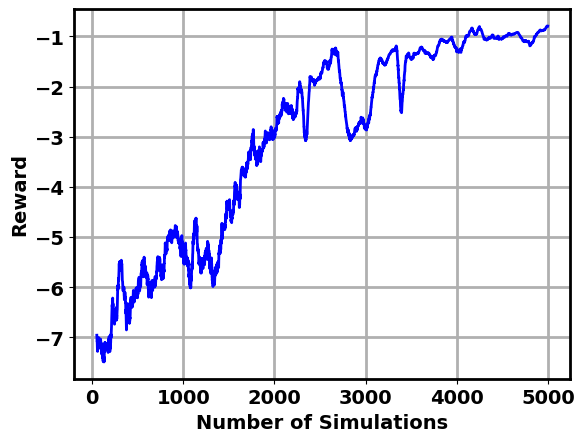

In [ ]:
""" Load reward buffer to plot reward vs simulations """
num_steps = 5000

with open('/content/sky130_ldo/saved_memories/rews_buf_LDO.npy', 'rb') as memory_file:
    rews_buf = np.load(memory_file)
    
rews_buf = rews_buf[:num_steps]

""" Result visualizations and save these as pictures """
# plot average reward
window = 50
avg_rewards=[]
for k in range(len(rews_buf)):
    if k >= window:
        avg_reward = np.mean(rews_buf[k-window:k])
    else:
        avg_reward = np.inf
    avg_rewards.append(avg_reward)
    
plt.figure('Reward')
plt.plot(avg_rewards, 'b')
plt.xlabel('Number of Simulations', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('Reward', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(linewidth=2)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

## IV. Results and Discussion
---


As you may have seen in the figure earlier, the reward versus simulation plot is shown below in Figure 3. The reward, in general, improves monotonically with respect to the simulation runs. There is a dip in the reward when the training was at around 3000 simulation runs, which is possibly due to catastrophic forgetting, a common RL issue that remains a challenging problem [8]. Methods to mitigate this issue include hyperparameter tuning and different memory buffer sampling methods. The agent seems to pick up the training quickly afterward and finally the reward converges at around -1, which means not all the specifications have been satisfied. This is fine since, first, there is no guarantee by far that for this LDO topology, all these specifications in Table II are feasible; second, it is possible that by increasing the number of steps and noise volume during the exploration process, a better design may be found; third, the intention of this work is not to find the design that meets all the specifications, but to introduce an RL framework to automate circuit design and optimization in general.

We can find out the best design by looking at which action achieved the highest reward in the reward buffer. In our training process, the circuit variables provided in `ldo_tb_vars.spice` above in Section III have the best performance. Table III summarizes these parameters plus the simulation results.

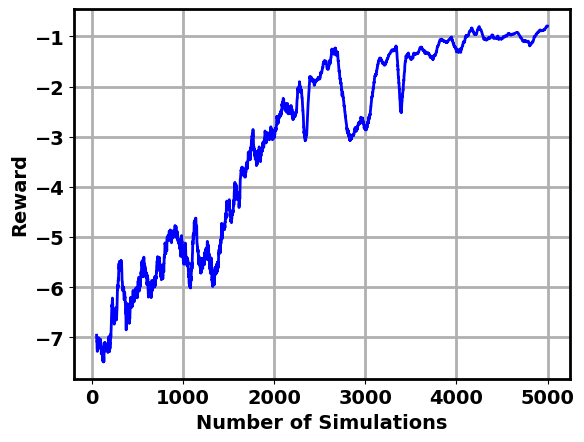

Fig. 3. Reward versus simulations.

<h4><center>Table. II. Desired specifications versus optimized simulation results of the LDO</center></h4>

\begin{array}{|c|c|c|c|c|c|c|c|}
\hline
 W_{M1}\,(μm) & L_{M1}\,(μm) & W_{M3}\,(μm) & L_{M3}\,(μm) & W_{M5}\,(μm) & L_{M5}\,(μm) & W_{MP}\,(μm) & L_{MP}\,(μm) & M_{MP} & M_{Rfb} & M_{Cfb} & M_{Cdec}& V_{b}\,(V) \\
\hline
 4.5 & 1.9 & 93 & 0.6 & 57.5 & 0.7 & 24.4 & 0.5 & 300 & 1\,(9535\,Ω) & 1\,(207\,fF) & 257\,(468.5\,pF) & 1.17\\
\hline
\end{array}

\begin{array}{|c|c|c|c|c|c|c|c|}
\hline
& V_{DD}\,(V) & V_{reg}\,(V) & V_{drop}\,(mV) & I_{L} & PSRR_{\leq10kHz}\,(dB) & PSRR_{\leq1MHz}\,(dB) & PSRR_{\geq1MHz}\,(dB) & PM\,(deg) & I_{q}\,(\mu A) & ΔV_{reg}\,(mV)\\
\hline
Specs. & 2 & 1.8 & \leq200 & [10\,\mu A,10\,mA] & \leq-30 & \leq-20 & \leq-5 & \geq60 & \leq200 & \leq36\\
\hline
Opt. & 2 & 1.85 @ I_{L,min}, 1.8 @ I_{L,max} & 205 & [10\,\mu A, 10\,mA] & -27.5 @ I_{L,min}, -30.35 @ I_{L,max} & -23.78 @ I_{L,min}, -20.91 @ I_{L,max} & -28.12 @ I_{L,min}, \bf{-0.25} @ I_{L,max} & 64.19 @ I_{L,min}, 61.98 @ I_{L,max} & 191.14 & \bf{61}\\ 
\hline
\end{array}


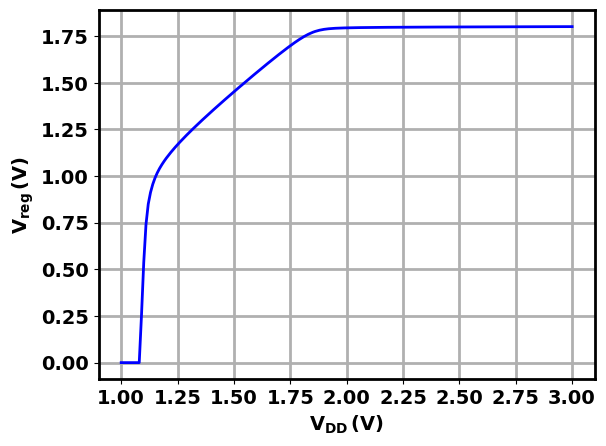

Fig. 4. $V_{reg}$ versus $V_{DD}$ when $I_{L}=10\,mA$.

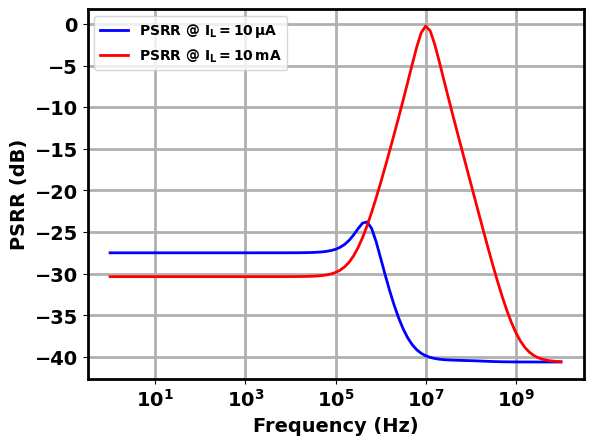

Fig. 5. PSRR at minimum and maximum load current conditions.

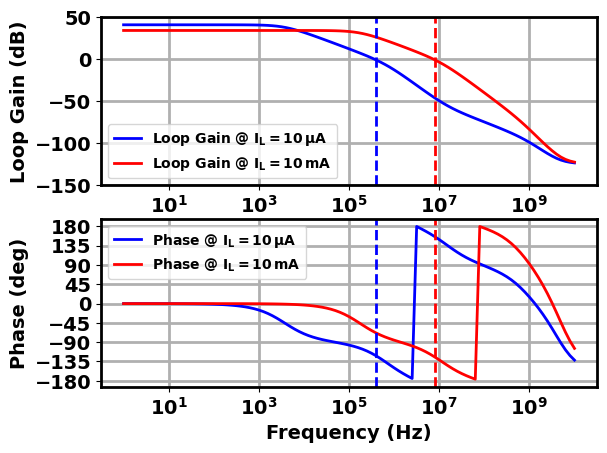

Fig. 6. LDO loop-gain and phase margin at minimum and maximum load current conditions.

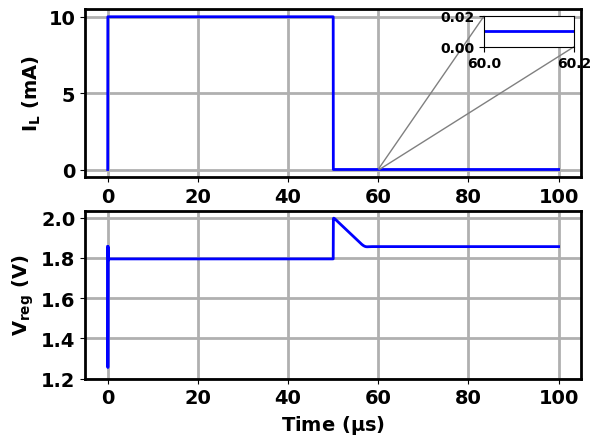

Fig. 7. Load regulation test, where the load current $I_{L}$ increases from 10 μA to 10 mA and back to 10 μA with a rise/fall time of 10 ns.


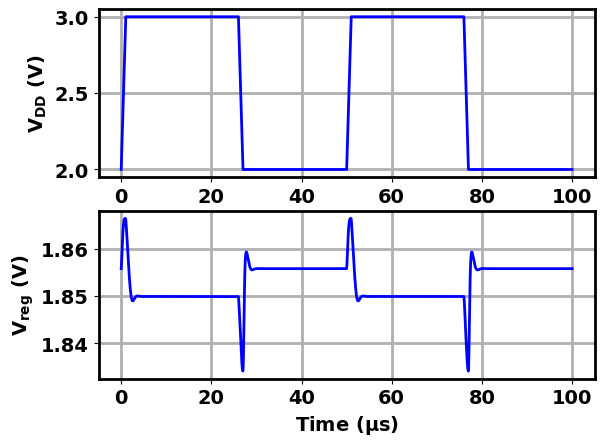

Fig. 8. Line regulation test at $I_{L}=10\,μA$, where the supply voltage $V_{DD}$ switches between 2 V and 3 V with a rise/fall time of 1 μs and frequency of 20 kHz.

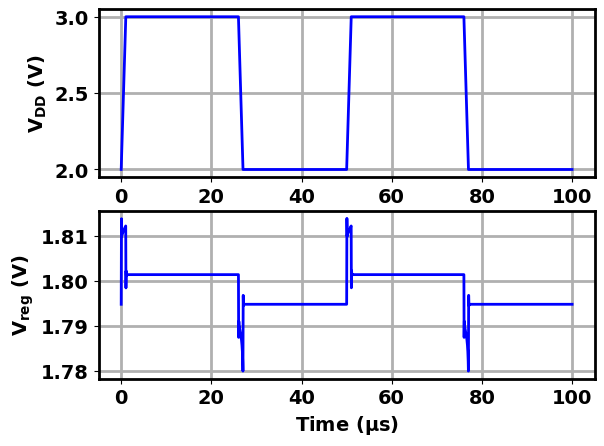

Fig. 9. Line regulation test at $I_{L}=10\,mA$, where the supply voltage $V_{DD}$ switches between 2 V and 3 V with a rise/fall time of 1 μs and frequency of 20 kHz.

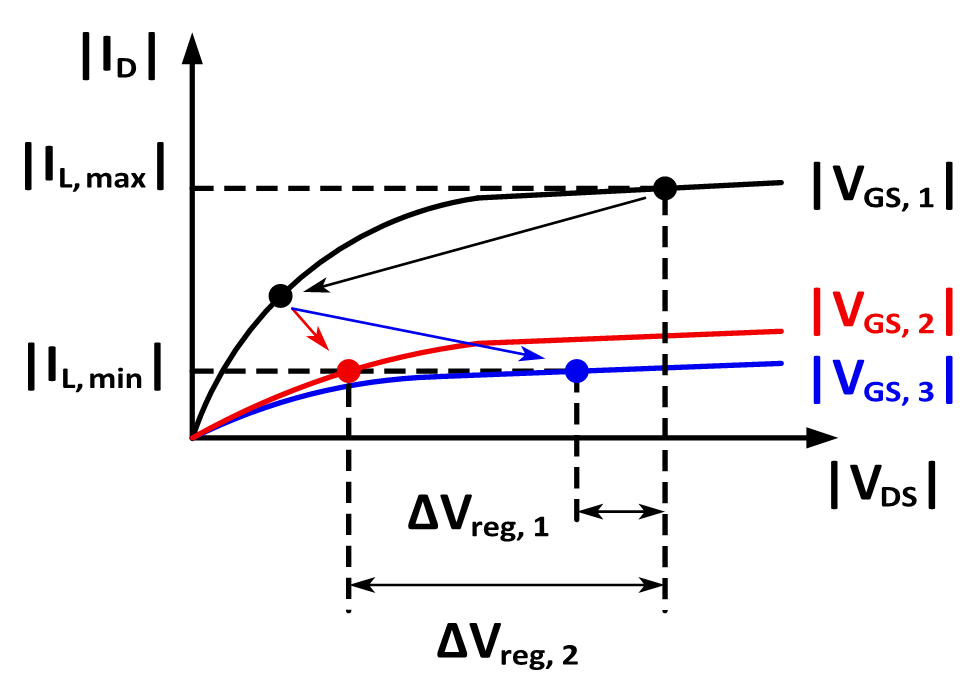

Fig. 10. This figure depiects a senario when there is a sudden change of $I_{L}$ from its maximum to minimum. By having different biasing voltage $|V_{GS}|$ across the pass PMOS, different $ΔV_{reg}$ may achieve by the circuit.

Figures 4-9 show the simulation results that were optimized by our RL framework, registering a -0.6 reward. Notably, we did not include line regulation in our reward function to save simulation time, but we included the line regulation simulation results for confirmation purposes. It can be seen that most of the specifications were successfully met. However, we noticed that for $PSRR_{\leq10kHz}$ when $I_{L}=10\,μA$, $PSRR_{\geq10MHz}$ when $I_{L}=10\,mA$, and $ΔV_{reg}$ during the load regulation test, the specifications were not met (an extra 5 mV of $V_{drop}$ is acceptable). Possible explanations for these issues are provided below.

First, to provide good PSRR performance over a wide bandwidth (1 MHz in this case), the optimizer trades gain for higher bandwidth, resulting in lower PSRR performance at low frequencies. This was intentional since we gave lower weight to PSRR at low frequency in our reward function. Second, the peak in the PSRR is due to the pole separation of the EA's output pole and LDO's output pole. Ideally, PSRR performance is ensured by the loop gain in the low-to-moderate frequency range, and decap $C_{dec}$ is engaged at high frequencies to filter out high-frequency noise. A smoother PSRR can be achieved when $C_{dec}$ starts to function at which the loop gain begins to lose control over PSRR. However, placing two poles too close to each other leads to poor phase margin and potentially leads to instability. We gave a very strict penalty towards poor phase margin designs in our reward function. Additionlly, the conventional LDO usually has a worst case PSRR around 0 dB [9]. Third, regarding load regulation, the sudden change in $I_{L}$ leads to overshoot and undershoot of $V_{reg}$, which may be caused by the limited bandwidth of the negative feedback. Increasing the loop-gain bandwidth may mitigate this issue by burning more power, allowing for quicker tracking of changes in $I_{L}$. The difference in $V_{reg}$ between the regulated state at the minimum and maximum load current, $ΔV_{reg}$, is probably caused by the inappropriate $|V_{GS}|$ of the pass PMOS, as shown in Figure 10. Here, we assume that there is a sudden decrease in $I_{L}$. Due to the limited bandwidth of the negative feedback, the $|V_{DS}|$ of the pass PMOS will first decrease, followed by the black arrow. When the feedback loop starts to pick up the change, depending on the value of $V_{GS}$ of the pass PMOS, different $ΔV_{reg}$ is obtained. In this exaggerated figure, clearly $|V_{GS,3}|$ achieves a smaller $ΔV_{reg}$ than $|V_{GS,2}|$ [10].

In conclusion, we have demonstrated a DDPG+RGCN RL framework for designing and optimizing vanilla LDO circuits conditioned on a series of specifications. Simulation results have shown that most specifications were met after 5000 simulation runs, with a few outliers possibly due to the limitations of the circuit topology. We believe that our proposed framework, with certain reward engineering and hyperparameter modifications, can be generalized to other analog circuit types. In the future, we plan to expand our model to include post-layout simulation inside the optimization loop to deliver an end-to-end solution. Furthermore, by leveraging the ability of transfer learning, we aim to explore how the trained RL agent could be applied to other technology nodes.

## V. References

[1] K. Settaluri, A. Haj-Ali, Q. Huang, K. Hakhamaneshi and B. Nikolic, "AutoCkt: Deep Reinforcement Learning of Analog Circuit Designs," 2020 Design, Automation & Test in Europe Conference & Exhibition (DATE), Grenoble, France, 2020, pp. 490-495, doi: 10.23919/DATE48585.2020.9116200.

[2] J. Lopez-Arredondo, E. Tlelo-Cuautle, and R. Trejo-Guerra, “Optimizing an ldo voltage regulator by evolutionary algorithms considering tolerances of the circuit elements,” in 2015 16th Latin-American Test Symposium (LATS), 2015, pp. 1–5

[3] H. Wang et al., “Learning to design circuits,” in NeurIPS Machine Learning for Systems Workshop, 2018.

[4] H. Wang et al., "GCN-RL Circuit Designer: Transferable Transistor Sizing with Graph Neural Networks and Reinforcement Learning," 2020 57th ACM/IEEE Design Automation Conference (DAC), San Francisco, CA, USA, 2020, pp. 1-6, doi: 10.1109/DAC18072.2020.9218757.

[5] M. Schlichtkrull, T. N. Kipf, P. Bloem, R. van den Berg, I. Titov,
and M. Welling, “Modeling relational data with graph convolutional
networks,” 2017

[6] M. Andrychowicz et al., “Hindsight Experience Replay,” in NeurIPS Machine Learning for Systems Workshop, 2017.

[7] S. Shahramian, “Chip-level Power Integrity Methodology
for High-speed Serial Links,” Proc. of DesignCon, 2018.

[8] C. Atkinson, B. McCane, L. Szymanski and A. Robins, "Pseudo-rehearsal: Achieving deep reinforcement learning without catastrophic forgetting," Neurocomputing, vol. 428, pp. 291-307, Mar. 2021. doi: 10.1016/j.neucom.2020.11.050.

[9] Y. Yin, “The Role of Voltage Regulation in Power Integraty for mMlti-Gbps Parallel I/O Interfaces,” master thesis, The Edward S. Rogers Sr. Department of Electrical & Computer Engineering, University of Torotno, Toronto, ON, Canada, 2017.

[10] Toshiba Semiconductor & Storage Corporation, "Load Transient Response Improvement Techniques for Low-Dropout Voltage Regulators," Mar. 2021. [Online]. Available: https://toshiba.semicon-storage.com/info/application_note_en_20210326_AKX00312.pdf?did=66268#:~:text=Summary%20of%20load%20transient%20response%20improvement,-From%20the%20equation&text=T%20can%20be%20reduced%20by,capacitor%20in%20the%20error%20amplifier. [Accessed: Mar. 21, 2023].


## Appendix: applying the same framework to optimize a folded-cascode EA based LDO

folded-cascode EA based LDO netlist `ldo_folded_cascode_tb.spice`.

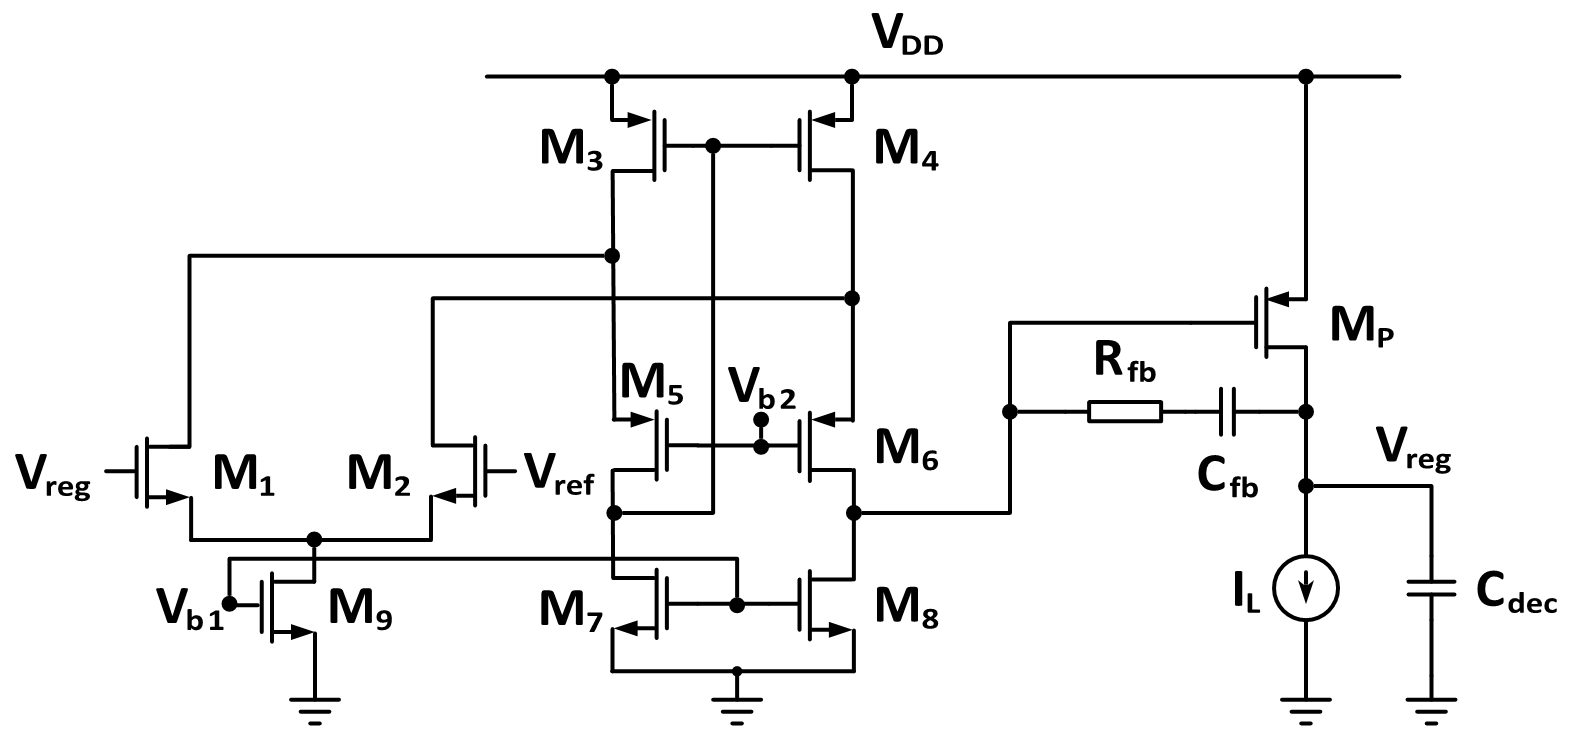

In [ ]:
%%writefile /content/sky130_ldo/simulations/ldo_folded_cascode_tb.spice
** sch_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/ldo_folded_cascode_tb.sch
**.subckt ldo_folded_cascode_tb Vreg Vreg1
*.opin Vreg
*.opin Vreg1
Vref Vref GND Vref
.save i(vref)
IL Vreg net2 dc IL PULSE(10u IL 0 10n 10n 50u 100u 0)
Vdd Vdd GND ac 1 dc Vdd
.save i(vdd)
XCL Vreg GND sky130_fd_pr__cap_mim_m3_1 W=30 L=30 MF=M_CL m=M_CL
Rdummy net2 GND 1 m=1
x1 Vdd Vreg net1 Vref net5 GND Vreg ldo_folded_cascode
Vref1 Vref1 GND Vref
.save i(vref1)
IL1 Vreg1 net3 dc IL PULSE(10u IL 0 10n 10n 50u 100u 0)
Vdd2 Vdd1 GND Vdd
.save i(vdd2)
XCL1 Vreg1 GND sky130_fd_pr__cap_mim_m3_1 W=30 L=30 MF=M_CL m=M_CL
Rdummy1 net3 GND 1 m=1
x2 Vdd1 net4 net6 Vref1 net7 GND Vreg1 ldo_folded_cascode
Vprobe2 probe net4 dc 0
.save i(vprobe2)
Vprobe1 probe Vreg1 dc 0 ac 1
.save i(vprobe1)
Iprobe1 GND probe dc 0 ac 0
Vb2 net1 GND Vb2
.save i(vb2)
Vb1 net5 GND Vb1
.save i(vb1)
Vb4 net6 GND Vb2
.save i(vb4)
Vb3 net7 GND Vb1
.save i(vb3)
**** begin user architecture code

.include /content/sky130_ldo/simulations/ldo_folded_cascode_tb_vars.spice

.nodeset v(Vreg)=1.8
.nodeset v(Vreg1)=1.8

.control
* save all voltage and current
save all
.options savecurrents 
set filetype=ascii
set units=degrees

.include /content/sky130_ldo/simulations/ldo_folded_cascode_tb_analysis.spice
.endc

.param mc_mm_switch=0
.param mc_pr_switch=0
.include /usr/local/share/pdk/sky130A/libs.tech/ngspice/corners/tt.spice
.include /usr/local/share/pdk/sky130A/libs.tech/ngspice/r+c/res_typical__cap_typical.spice
.include /usr/local/share/pdk/sky130A/libs.tech/ngspice/r+c/res_typical__cap_typical__lin.spice
.include /usr/local/share/pdk/sky130A/libs.tech/ngspice/corners/tt/specialized_cells.spice

**** end user architecture code
**.ends

* expanding   symbol:  ldo_folded_cascode.sym # of pins=7
** sym_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/ldo_folded_cascode.sym
** sch_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/ldo_folded_cascode.sch
.subckt ldo_folded_cascode Vdd Vfb Vb2 Vref Vb1 Vss Vreg
*.iopin Vss
*.opin Vreg
*.iopin Vref
*.ipin Vdd
*.iopin Vfb
*.iopin Vb2
*.iopin Vb1
XM10 Vreg net1 Vdd Vdd sky130_fd_pr__pfet_g5v0d10v5 L=L_pass W=W_pass nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=M_pass m=M_pass
x1 Vdd Vb2 Vfb Vref net1 Vb1 Vss diff_pair_folded_cascode
XCfb net2 Vreg sky130_fd_pr__cap_mim_m3_1 W=10 L=10 MF=M_Cfb m=M_Cfb
XRfb net2 net1 Vss sky130_fd_pr__res_high_po_0p35 L=3 mult=M_Rfb m=M_Rfb
.ends


* expanding   symbol:  diff_pair_folded_cascode.sym # of pins=7
** sym_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/diff_pair_folded_cascode.sym
** sch_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/diff_pair_folded_cascode.sch
.subckt diff_pair_folded_cascode Vdd Vb2 vinp vinm vout Vb1 Vss
*.iopin Vdd
*.ipin vinm
*.ipin vinp
*.iopin Vb1
*.iopin Vss
*.iopin Vb2
*.opin vout
XM1 net2 vinp net4 Vss sky130_fd_pr__nfet_g5v0d10v5 L=L_M1 W=W_M1 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM2 net3 vinm net4 Vss sky130_fd_pr__nfet_g5v0d10v5 L=L_M2 W=W_M2 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM4 net3 net1 Vdd Vdd sky130_fd_pr__pfet_g5v0d10v5 L=L_M4 W=W_M4 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM3 net2 net1 Vdd Vdd sky130_fd_pr__pfet_g5v0d10v5 L=L_M3 W=W_M3 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM9 net4 Vb1 Vss Vss sky130_fd_pr__nfet_g5v0d10v5 L=L_M9 W=W_M9 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM6 vout Vb2 net3 Vdd sky130_fd_pr__pfet_g5v0d10v5 L=L_M6 W=W_M6 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM5 net1 Vb2 net2 Vdd sky130_fd_pr__pfet_g5v0d10v5 L=L_M5 W=W_M5 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM7 net1 Vb1 Vss Vss sky130_fd_pr__nfet_g5v0d10v5 L=L_M7 W=W_M7 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
XM8 vout Vb1 Vss Vss sky130_fd_pr__nfet_g5v0d10v5 L=L_M8 W=W_M8 nf=1 ad='int((nf+1)/2) * W/nf * 0.29'
+ as='int((nf+2)/2) * W/nf * 0.29' pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)'
+ nrd='0.29 / W' nrs='0.29 / W' sa=0 sb=0 sd=0 mult=1 m=1
.ends

.GLOBAL GND
.end


Writing /content/sky130_ldo/simulations/ldo_folded_cascode_tb.spice


Circuit variables `ldo_folded_cascode_tb_analysis.spice`. The number provided below is the optimal design generated from our training, you may have a different optimal design generated from your training session.

In [ ]:
%%writefile /content/sky130_ldo/simulations/ldo_folded_cascode_tb_vars.spice
.param W_M1=11.542582392692566 L_M1=0.5095086991786957
.param W_M2=W_M1 L_M2=L_M1
.param W_M3=53.55864467844367 L_M3=0.6479280740022659
.param W_M4=W_M3 L_M4=L_M3
.param W_M5=37.08990952372551 L_M5=0.5966911762952805
.param W_M6=W_M5 L_M6=L_M5
.param W_M7=65.89017415046692 L_M7=1.1224756687879562
.param W_M8=W_M7 L_M8=L_M7
.param W_M9=93.58850041031837 L_M9=0.5009907186031342
.param W_pass=13.717968165874481 L_pass=0.5010222643613815 M_pass=439
.param Vb1=0.9811389386653899
.param Vb2=0.023122012615203857
.param M_Rfb=14
.param M_Cfb=41
.param M_CL=288
.param Vdd=2
.param Vref=1.8
.param IL=10m


Writing /content/sky130_ldo/simulations/ldo_folded_cascode_tb_vars.spice


Simulation setups for the circuit `ldo_folded_cascode_tb_analysis.spice`.

In [ ]:
%%writefile /content/sky130_ldo/simulations/ldo_folded_cascode_tb_analysis.spice
* high precision simulation
*.OPTIONS maxord=1
.OPTIONS itl1=200
.OPTIONS itl2=200
.OPTIONS itl4=200

* Loop stability
* http://education.ingenazure.com/ac-stability-analysis-ngspice/
alter IL1 dc=10u
let runs=2
let run=0

alter @Vprobe1[acmag]=1
alter @Iprobe1[acmag]=0

dowhile run<runs
set run=$&run
set temp=27

ac dec 10 1 10G

alter @Vprobe1[acmag]=0
alter @Iprobe1[acmag]=1

let run=run+1
end

let ip11 = ac1.i(Vprobe1)
let ip12 = ac1.i(Vprobe2)
let ip21 = ac2.i(Vprobe1)
let ip22 = ac2.i(Vprobe2)
let vprb1 = ac1.v(probe)
let vprb2 = ac2.v(probe)

*** Middlebrook
let mb = 1/(vprb1+ip22)-1
*** Tian that is preferred
let av = 1/(1/(2*(ip11*vprb2-vprb1*ip21)+vprb1+ip21)-1)

plot vdb(mb) vp(mb)
plot vdb(av) vp(av)

wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_loop_gain_minload mag(av) vp(av)

* at max load
reset all
alter IL1 dc=10m
let runs=2
let run=0

alter @Vprobe1[acmag]=1
alter @Iprobe1[acmag]=0

dowhile run<runs
set run=$&run
set temp=27

ac dec 10 1 10G

alter @Vprobe1[acmag]=0
alter @Iprobe1[acmag]=1

let run=run+1
end

let ip11 = ac3.i(Vprobe1)
let ip12 = ac3.i(Vprobe2)
let ip21 = ac4.i(Vprobe1)
let ip22 = ac4.i(Vprobe2)
let vprb1 = ac3.v(probe)
let vprb2 = ac4.v(probe)

*** Middlebrook
let mb = 1/(vprb1+ip22)-1
*** Tian that is preferred
let av = 1/(1/(2*(ip11*vprb2-vprb1*ip21)+vprb1+ip21)-1)

plot vdb(mb) vp(mb)
plot vdb(av) vp(av)

wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_loop_gain_maxload mag(av) vp(av)

* DC sweep
dc Vdd 1 3 0.01
plot v(Vdd) v(Vreg)
wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_dc v(Vreg)

* Transient analysis with load regulation
* do not miss the space between the square bracket and number
tran 10n 100u
plot @Rdummy[i]
plot Vreg
wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_load_reg Vreg
wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_load_reg_current @Rdummy[i] 


* Transient analysis with line regulation
* at minimum load current 10uA
*alter @IL[PULSE] [ 10u 10u 0 10n 10n 100u 100u 0 ]
*alter @Vdd[PULSE] [ 2 3 0 1u 1u 25u 50u 0 ]
*tran 10n 100u
*plot Vdd
*plot @Rdummy[i]
*plot Vreg
*wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_line_reg_minload Vreg
*wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_line_reg_Vdd Vdd

* at maximum load current 10mA
*alter @IL[PULSE] [ 10m 10m 0 10n 10n 100u 100u 0 ]
*tran 10n 100u
*plot @Rdummy[i]
*plot Vreg
*wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_line_reg_maxload Vreg

* PSRR with max load
alter Vdd ac=1
alter Vprobe1 ac=0
ac dec 10 1 10G
plot vdb(Vreg)
wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_psrr_maxload mag(Vreg) vp(Vreg)

* PSRR with min load
alter IL dc=10u
ac dec 10 1 10G
plot vdb(Vreg)
wrdata /content/sky130_ldo/simulations/ldo_folded_cascode_tb_psrr_minload mag(Vreg) vp(Vreg)

* OP
op
alter IL dc=10u
.include /content/sky130_ldo/simulations/ldo_folded_cascode_tb_dev_params.spice

Writing /content/sky130_ldo/simulations/ldo_folded_cascode_tb_analysis.spice


Class `GraphLDOFoldedCascode` to define the circuit and specifications. We used the same reward and specifications for this LDO.

In [ ]:
class GraphLDOFoldedCascode:
    # here is the description for the two-stage op-amp
    """

        Here is a graph discription for the folded cascode EA LDO:


                                     Vdd 
      ___________________________________________________________________________________________________________________
                                                                            |                |                          |                                                          
                                                                            |                |                          |                                                          
                                                                            M3---------------M4                         |
                             |----------------------------------------------|     |          |                          |
                             |             |--------------------------------|-----|----------|                          |
                             |             |                               M5-----|---Vb2---M6                          |
                             |             |                                |_____|          |                          |
                        Vreg-M1__________M2-Vref                            |                |-------------------------M10
                                     |                                      M7------Vb1-----M8       |_Rfb__Cfb__|--------------------------------Vreg
          Vb1-----------------------M9                                      |                |                                |            |                        
                                     |                                      |                |                                CL          IL                       
      ----------------------------------------------------------------------------------------------------------------------------------------------                      
                                      GND                                                                                                                                  
                                                                                                                                                                                 
                                                                                                                                                                                  
                                                                                                                                                                                 
    node 0 will be M1
    node 1 will be M2
    node 2 will be M3
    node 3 will be M4
    node 4 will be M5
    node 5 will be M6
    node 6 will be M7
    node 7 will be M8
    node 8 will be M9
    node 9 will be M10
    node 10 will be Vb1
    node 11 will be Vb2
    node 12 will be Rfb
    node 13 will be Cfb
    node 14 will be CL decap
    node 15 will be Vdd
    node 16 will be GND

    """
    def __init__(self):
        # self.device = torch.device(
        #     "cuda:0" if torch.cuda.is_available() else "cpu"
        # )
        
        self.device = torch.device(
           "cpu"
        )

        self.ckt_hierarchy = (('M1','x1.x1.XM1','nfet_g5v0d10v5','m'),
                      ('M2','x1.x1.XM2','nfet_g5v0d10v5','m'),
                      ('M3','x1.x1.XM3','pfet_g5v0d10v5','m'),
                      ('M4','x1.x1.XM4','pfet_g5v0d10v5','m'),
                      ('M5','x1.x1.XM5','pfet_g5v0d10v5','m'),
                      ('M6','x1.x1.XM6','pfet_g5v0d10v5','m'),
                      ('M7','x1.x1.XM7','nfet_g5v0d10v5','m'),
                      ('M8','x1.x1.XM8','nfet_g5v0d10v5','m'),
                      ('M9','x1.x1.XM9','nfet_g5v0d10v5','m'),
                      ('M10','x1.XM10','pfet_g5v0d10v5','m'),
                      ('Vb1','','Vb1','v'),
                      ('Vb2','','Vb2','v'),
                      
                      ('Cfb','x1.XCfb','cap_mim_m3_1','c'),
                      ('CL','XCL','cap_mim_m3_1','c')
                     )    

        self.op = {'M1':{},
                'M2':{},
                'M3':{},
                'M4':{},
                'M5':{},
                'M6':{},
                'M7':{},
                'M8':{},           
                'M9':{},
                'M10':{},
                'Vb1':{},
                'Vb2':{},

                'Cfb':{},
                'CL':{}
                 }

        self.edge_index = torch.tensor([
          [0,1], [1,0], [0,2], [2,0], [0,4], [4,0], [0,8], [8,0], [0,9], [9,0], [0,13], [13,0], [0,14], [14,0],
          [1,3], [3,1], [1,5], [5,1], [1,8], [8,1], 
          [2,3], [3,2], [2,4], [4,2], [2,6], [6,2], [2,15], [15,2],
          [3,4], [4,3], [3,5], [5,3], [3,6], [6,3], [3,15], [15,3],
          [4,5], [5,4], [4,6], [6,4], [4,11], [11,4],
          [5,7], [7,5], [5,9], [9,5], [5,11], [11,5], [5,12], [12,5],
          [6,7], [7,6], [6,8], [8,6], [6,10], [10,6], [6,16], [16,6],
          [7,9], [9,7], [7,12], [12,7], [7,8], [8,7], [7,16], [16,7],
          [8,10], [10,8], [8,16], [16,8],
          [9,12], [12,9], [9,13], [13,9], [9,14], [14,9], [9,15], [15,9], 
          [12,13], [13,12],
          [13,14], [14,13], 
          [14,16], [16,14],
            ], dtype=torch.long).t().to(self.device)
        
        # sorted based on if it is the small signal path
        # small signal path: 0; biasing path: 1
        self.edge_type = torch.tensor([
            0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 1, 
            0, 0, 0, 0, 0, 0, 1, 1,
            0, 0, 0, 0, 0, 0, 1, 1,
            1, 1, 0, 0, 1, 1,
            0, 0, 0, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 1, 1, 1,
            0, 0, 0, 0, 1, 1, 1, 1,
            1, 1, 1, 1,
            0, 0, 0, 0, 0, 0, 1, 1,
            0, 0,
            0, 0, 
            1, 1,
            ]).to(self.device)
        
        self.num_relations = 2
        self.num_nodes = 17
        self.num_node_features = 14
        self.obs_shape = (self.num_nodes, self.num_node_features)
        
        """Select an action from the input state."""

        L_CL = 30 # each unit cap is 30um by 30um
        W_CL = 30
        M_CL_low = 10
        M_CL_high = 300 # copies of unit cap
        self.CL_low = M_CL_low * (L_CL*W_CL*2e-15+(L_CL+W_CL)*0.38e-15)
        self.CL_high = M_CL_high * (L_CL*W_CL*2e-15+(L_CL+W_CL)*0.38e-15)

        self.W_Rfb = 0.35 # W: 5um
        self.L_Rfb = 3 # L: 3um
        M_Rfb_low = 1
        M_Rfb_high = 20
        self.Rsheet = 1112.4
        self.Rfb_low =  self.Rsheet * self.L_Rfb / self.W_Rfb / M_Rfb_high  
        self.Rfb_high = self.Rsheet * self.L_Rfb / self.W_Rfb / M_Rfb_low 
        
        W_Cfb = 10
        L_Cfb = 10
        M_Cfb_low = 1
        M_Cfb_high = 100
        self.Cfb_low = M_Cfb_low * (L_Cfb*W_Cfb*2e-15+(L_Cfb+W_Cfb)*0.38e-15)
        self.Cfb_high = M_Cfb_high * (L_Cfb*W_Cfb*2e-15+(L_Cfb+W_Cfb)*0.38e-15)
        
        self.action_space_low = np.array([ 1, 0.5, #M1
                                          1, 0.5, #M3
                                          1, 0.5, #M5
                                          1, 0.5, #M7
                                          1, 0.5, #M9
                                          10, 0.5, 100, #M10
                                          0.9, 0.0, # Vb1, Vb2,
                                          M_Rfb_low, #Rfb
                                          M_Cfb_low, #Cfb
                                          M_CL_low]) # CL
        
        self.action_space_high = np.array([100, 2, 
                                          100, 2,    
                                          100, 2,  
                                          100, 2,
                                          100, 2,   
                                          100, 1, 2000,   
                                          1.4, 1,
                                          M_Rfb_high,  
                                          M_Cfb_high,
                                          M_CL_high])
        
        self.action_dim = len(self.action_space_low)
        self.action_shape = (self.action_dim,)    

        """Some target specifications for the final design"""
        self.Vdrop_target = 0.22  # drop-out voltage
        
        self.PSRR_target_1kHz = 10**(-30/20) # in linear scale, equals -30dB
        self.PSRR_target_10kHz = 10**(-30/20) # in linear scale, equals -30dB
        self.PSRR_target_1MHz =  10**(-20/20) # in linear scale, equals -20dB
        self.PSRR_target_above_1MHz =  10**(-5/20) # in linear scale, equals -5dB
        self.PSRR_1kHz = 1e3 #  from DC to 1kHz
        self.PSRR_10kHz = 1e4 #  from DC to 10kHz
        self.PSRR_1MHz = 1e6  # from DC to 1 MHz
        
        self.phase_margin_target = 60 # 60 degree PM minimum, this is for the loop-gain
        self.Vreg = 1.8 # regulated output
        self.Vref = 1.8
        self.GND = 0
        self.Vdd = 2

        self.Vload_reg_delta_target = self.Vreg * 0.02 # load regulartion variation is at most 2% of Vreg when it is switched from ILmin to ILmax
        self.Iq_target = 200e-6 #200uA quiescent current maximum
        self.Vline_reg_delta_target =  self.Vreg * 0.02  # line reg voltage to be around at most 2% of Vreg when it is at both ILmin and ILmax

Generate the scripts to automatically extrac transistor's attributes during the `OP` analysis. 

In [ ]:
ckt_hierarchy = GraphLDOFoldedCascode().ckt_hierarchy      
dev_params_script = DeviceParams(ckt_hierarchy).gen_dev_params(file_name=f'{SPICE_NETLIST_DIR}/ldo_folded_cascode_tb_op')

with open(f'{SPICE_NETLIST_DIR}/ldo_folded_cascode_tb_dev_params.spice', 'w') as f:
    for line in dev_params_script:
        f.write(f'{line}\n')    

You can run the simulation of this LDO in ngspice now.

In [ ]:
!ngspice -b /content/sky130_ldo/simulations/ldo_folded_cascode_tb.spice


Note: No compatibility mode selected!


Circuit: ** sch_path: /fs1/eecg/tcc/lizongh2/sky130_ldo/xschem/ldo_folded_cascode_tb.sch

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: il: dc value used for op instead of transient time=0 value.
 Reference value :  1.00000e+00
No. of Data Rows : 101
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: il: dc value used for op instead of transient time=0 value.

No. of Data Rows : 101
ERROR: (internal)  This operation is not defined for display type PrinterOnly.
Can't open viewport for graphics.
ERROR: (internal)  This operation is not defined for display type PrinterOnly.
Can't open viewport for graphics.
reset: too many args.
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: il1: dc value used for op instead of transient time=0 value.
Note: il: dc value used for op instead of transient time=0 value.

No. of Data Rows : 101
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: il1: dc value used 

View the simulation results. This design gives a reward of -0.93. The major concern is the power consumption, consuming a quiscent current of $783.26\,μA$.

"\nline_reg_minload_results = sim_results.tran(file_name='ldo_folded_cascode_tb_line_reg_minload')\nline_reg_maxload_results = sim_results.tran(file_name='ldo_folded_cascode_tb_line_reg_maxload')\nline_reg_Vdd_results = sim_results.tran(file_name='ldo_folded_cascode_tb_line_reg_Vdd')\n\ntime = 1e6 * np.array(line_reg_minload_results[0])\nload_reg_minload = line_reg_minload_results[1]\nload_reg_maxload = line_reg_maxload_results[1]\nline_reg_Vdd = line_reg_Vdd_results[1]\n\nplt.figure('Line Reg Minload')\nfig, axs = plt.subplots(2)\naxs[0].plot(time, line_reg_Vdd, 'b', label='$V_{DD}$')\naxs[0].set_ylabel('$\\mathbf{V_{DD}}$ (V)', fontweight='bold', fontsize=14)\naxs[0].xaxis.set_tick_params(labelsize='14')\naxs[0].yaxis.set_tick_params(labelsize='14')\naxs[0].spines['bottom'].set_linewidth(2)\naxs[0].spines['left'].set_linewidth(2)\naxs[0].spines['right'].set_linewidth(2)\naxs[0].spines['top'].set_linewidth(2)\naxs[0].grid(linewidth=2)\n\naxs[1].plot(time, load_reg_minload, 'b', label=

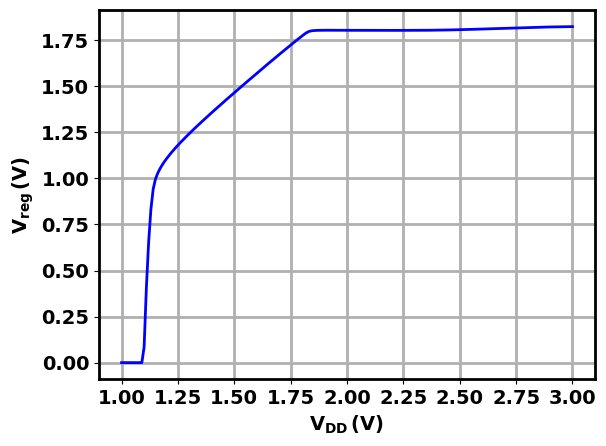

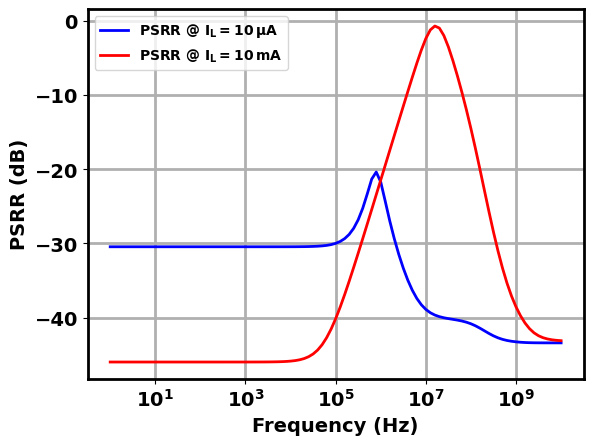

<Figure size 640x480 with 0 Axes>

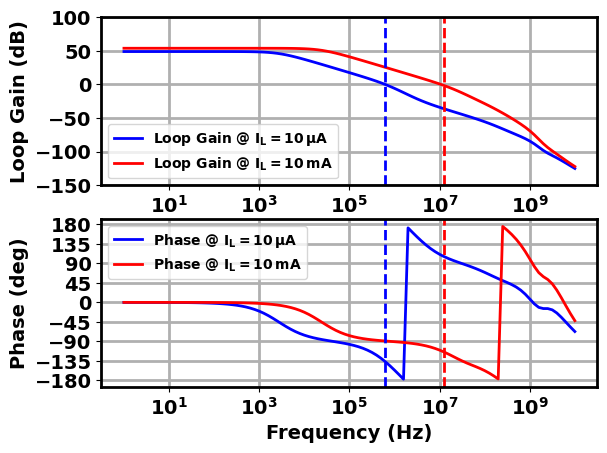

<Figure size 640x480 with 0 Axes>

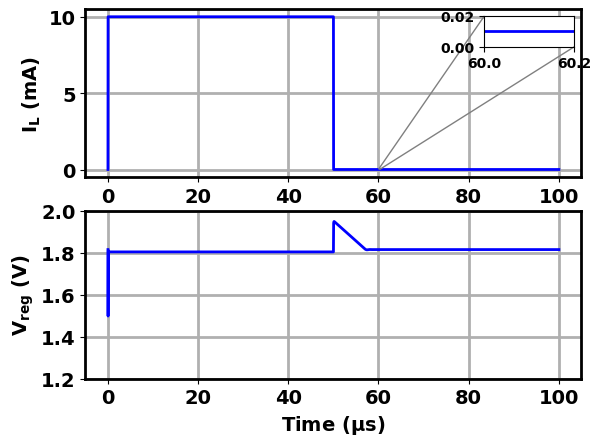

In [ ]:
sim_results = OutputParser(GraphLDOFoldedCascode())
dc_results = sim_results.dc(file_name='ldo_folded_cascode_tb_dc')

# plot DC response
plt.figure('DC')
Vin = dc_results[0]
Vout = [max(dc_results[1][i], 0) for i in range(len(dc_results[1]))]
plt.plot(Vin, Vout, 'b')
plt.xlabel('$\mathbf{V_{DD}\,(V)}$', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('$\mathbf{V_{reg}\,(V)}$', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(linewidth=2)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

# plot PSRR AC response
psrr_results_minload = sim_results.ac(file_name='ldo_folded_cascode_tb_psrr_minload')
psrr_results_maxload = sim_results.ac(file_name='ldo_folded_cascode_tb_psrr_maxload')
freq = psrr_results_minload[0]
psrr_minload = 20*np.log10(psrr_results_minload[1])
psrr_maxload = 20*np.log10(psrr_results_maxload[1])

plt.figure('PSRR')
plt.plot(freq, psrr_minload, 'b', label='PSRR @ $\mathbf{I_{L}=10\,\mu A}$')
plt.plot(freq, psrr_maxload, 'r', label='PSRR @ $\mathbf{I_{L}=10\,mA}$')
plt.xlabel('Frequency (Hz)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('PSRR (dB)', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='upper left', prop=dict(weight='bold'))
plt.grid(linewidth=2)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.set_xscale('log')

# plot loop stability
loop_gain_minload_results = sim_results.ac(file_name='ldo_folded_cascode_tb_loop_gain_minload')
freq = loop_gain_minload_results[0]
loop_gain_minload = 20*np.log10(loop_gain_minload_results[1])
loop_gain_phase_minload = loop_gain_minload_results[2]
loop_gain_maxload_results = sim_results.ac(file_name='ldo_folded_cascode_tb_loop_gain_maxload')
loop_gain_maxload = 20*np.log10(loop_gain_maxload_results[1])
loop_gain_phase_maxload = loop_gain_maxload_results[2]

plt.figure('Loop Gain')
fig, axs = plt.subplots(2)
axs[0].plot(freq, loop_gain_minload, 'b', label='Loop Gain @ $\mathbf{I_{L}=10\,\mu A}$')
axs[0].plot(freq, loop_gain_maxload, 'r', label='Loop Gain @ $\mathbf{I_{L}=10\,mA}$')
axs[0].set_ylabel('Loop Gain (dB)', fontweight='bold', fontsize=14)
axs[0].xaxis.set_tick_params(labelsize='14')
axs[0].yaxis.set_tick_params(labelsize='14')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_linewidth(2)
axs[0].spines['top'].set_linewidth(2)
axs[0].grid(linewidth=2)
axs[0].legend(loc='lower left', prop=dict(weight='bold'))
axs[0].set_yticks(axs[0].get_yticks()[::1])
idx_minload = [i for i in range(len(loop_gain_minload)) if loop_gain_minload[i] <=0][0]
idx_maxload = [i for i in range(len(loop_gain_maxload)) if loop_gain_maxload[i] <=0][0]
axs[0].axvline(x=freq[idx_minload], ls='--', color='b')
axs[0].axvline(x=freq[idx_maxload], ls='--', color='r')
axs[0].set_xscale('log')

axs[1].plot(freq, loop_gain_phase_minload, 'b', label='Phase @ $\mathbf{I_{L}=10\,\mu A}$')
axs[1].plot(freq, loop_gain_phase_maxload, 'r', label='Phase @ $\mathbf{I_{L}=10\,mA}$')
axs[1].set_ylabel('Phase (deg)', fontweight='bold', fontsize=14)
axs[1].xaxis.set_tick_params(labelsize='14')
axs[1].yaxis.set_tick_params(labelsize='14')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_linewidth(2)
axs[1].spines['top'].set_linewidth(2)
axs[1].grid(linewidth=2)
axs[1].legend(loc='upper left', prop=dict(weight='bold'))
axs[1].set_yticks(np.array([-180, -135, -90, -45, 0, 45, 90, 135, 180]))
axs[1].axvline(x=freq[idx_minload], ls='--', color='b')
axs[1].axvline(x=freq[idx_maxload], ls='--', color='r')
axs[1].set_xscale('log')
axs[1].set_xlabel('Frequency (Hz)', fontweight='bold', fontsize=14)

# load regulation
load_reg_results = sim_results.tran(file_name='ldo_folded_cascode_tb_load_reg')
time = 1e6 * np.array(load_reg_results[0])
load_reg = load_reg_results[1]
load_reg_current_results = sim_results.tran(file_name='ldo_folded_cascode_tb_load_reg_current')
load_reg_current = 1e3 * np.array(load_reg_current_results[1])

plt.figure('Load Reg')
fig, axs = plt.subplots(2)
axs[0].plot(time, load_reg_current, 'b', label='Load current')
axs[0].set_ylabel('$\mathbf{I_{L}}$ (mA)', fontweight='bold', fontsize=14)
axs[0].xaxis.set_tick_params(labelsize='14')
axs[0].yaxis.set_tick_params(labelsize='14')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_linewidth(2)
axs[0].spines['top'].set_linewidth(2)
axs[0].grid(linewidth=2)
axins = zoomed_inset_axes(axs[0], 100, loc=1) # zoom = 100
axins.plot(time, load_reg_current, color='b')
axins.set_xlim(60, 60.2) # Limit the region for zoom
axins.set_ylim(0, 0.02)
mark_inset(axs[0], axins, loc1=2, loc2=4, fc="none", ec="0.5")

axs[1].plot(time, load_reg, 'b', label='Vreg')
axs[1].set_ylabel('$\mathbf{V_{reg}}$ (V)', fontweight='bold', fontsize=14)
axs[1].xaxis.set_tick_params(labelsize='14')
axs[1].yaxis.set_tick_params(labelsize='14')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_linewidth(2)
axs[1].spines['top'].set_linewidth(2)
axs[1].grid(linewidth=2)
axs[1].set_yticks(np.array([1.2, 1.4, 1.6, 1.8, 2.0]))
axs[1].set_xlabel('Time ($\mathbf{\mu s}$)', fontweight='bold', fontsize=14)

# line regulation, you can come back to the `ldo_folded_cascode_tb_analysis.spice`
# to enable the line regulation simulations
"""
line_reg_minload_results = sim_results.tran(file_name='ldo_folded_cascode_tb_line_reg_minload')
line_reg_maxload_results = sim_results.tran(file_name='ldo_folded_cascode_tb_line_reg_maxload')
line_reg_Vdd_results = sim_results.tran(file_name='ldo_folded_cascode_tb_line_reg_Vdd')

time = 1e6 * np.array(line_reg_minload_results[0])
load_reg_minload = line_reg_minload_results[1]
load_reg_maxload = line_reg_maxload_results[1]
line_reg_Vdd = line_reg_Vdd_results[1]

plt.figure('Line Reg Minload')
fig, axs = plt.subplots(2)
axs[0].plot(time, line_reg_Vdd, 'b', label='$V_{DD}$')
axs[0].set_ylabel('$\mathbf{V_{DD}}$ (V)', fontweight='bold', fontsize=14)
axs[0].xaxis.set_tick_params(labelsize='14')
axs[0].yaxis.set_tick_params(labelsize='14')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_linewidth(2)
axs[0].spines['top'].set_linewidth(2)
axs[0].grid(linewidth=2)

axs[1].plot(time, load_reg_minload, 'b', label='Vreg')
axs[1].set_ylabel('$\mathbf{V_{reg}}$ (V)', fontweight='bold', fontsize=14)
axs[1].xaxis.set_tick_params(labelsize='14')
axs[1].yaxis.set_tick_params(labelsize='14')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_linewidth(2)
axs[1].spines['top'].set_linewidth(2)
axs[1].grid(linewidth=2)
axs[1].set_xlabel('Time ($\mathbf{\mu s}$)', fontweight='bold', fontsize=14)

plt.figure('Line Reg Maxload')
fig, axs = plt.subplots(2)
axs[0].plot(time, line_reg_Vdd, 'b', label='$V_{DD}$')
axs[0].set_ylabel('$\mathbf{V_{DD}}$ (V)', fontweight='bold', fontsize=14)
axs[0].xaxis.set_tick_params(labelsize='14')
axs[0].yaxis.set_tick_params(labelsize='14')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_linewidth(2)
axs[0].spines['top'].set_linewidth(2)
axs[0].grid(linewidth=2)

axs[1].plot(time, load_reg_maxload, 'b', label='Vreg')
axs[1].set_ylabel('$\mathbf{V_{reg}}$ (V)', fontweight='bold', fontsize=14)
axs[1].xaxis.set_tick_params(labelsize='14')
axs[1].yaxis.set_tick_params(labelsize='14')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_linewidth(2)
axs[1].spines['top'].set_linewidth(2)
axs[1].grid(linewidth=2)
axs[1].set_xlabel('Time ($\mathbf{\mu s}$)', fontweight='bold', fontsize=14)
"""

Write the statistical information for transistor's attributes.

In [ ]:
%%writefile /content/sky130_ldo/simulations/ldo_folded_cascode_tb_op_mean_std.json
{"OP_M_mean": {"gmbs": 0.00014515526208204154, "gm": 0.0004436573217627048, "gds": 0.2544314772372509, "vdsat": 0.3640377154400653, "vth": 0.9680058526367394, "id": 0.00014224362014553747, "ibd": -3.8308973222686575e-12, "ibs": -2.1211844924132667e-13, "gbd": 1.0315118113888922e-10, "gbs": 1.0339143909821776e-10, "isub": 6.283033701521296e-08, "igidl": 3.6536681075634688e-53, "igisl": 5.0234166777332435e-54, "igs": 0.0, "igd": 0.0, "igb": 0.0, "igcs": 0.0, "vbs": -0.21092198614075622, "vgs": 1.3432906221637757, "vds": 0.6465082312862297, "cgg": 9.243676493335032e-12, "cgs": -4.657258751909432e-12, "cgd": -4.280460536877834e-12, "cbg": -5.143191554578905e-13, "cbd": -2.645325806904066e-12, "cbs": -1.1117782462199101e-13, "cdg": -4.343868874872796e-12, "cdd": 4.619947776246429e-12, "cds": 1.1971797555306445e-12, "csg": -4.385488463004358e-12, "csd": 2.305838567535463e-12, "css": 3.5712568210007797e-12, "cgb": -3.0595720454777675e-13, "cdb": -1.473258656904279e-12, "csb": -1.4916069255318852e-12, "cbb": 3.2708227869839447e-12, "capbd": 2.702469459542116e-12, "capbs": 2.733604034853935e-12, "qg": 1.3332574955779457e-11, "qb": -5.218659451913798e-12, "qs": -4.063086440085129e-12, "qinv": 0.0, "qdef": 0.0, "gcrg": 0.0, "gtau": 0.0}, "OP_M_std": {"gmbs": 0.00022158556229445782, "gm": 0.0006900585547095205, "gds": 1.1258934998216428, "vdsat": 0.25452516852253176, "vth": 0.14425282769503445, "id": 0.00035430621773483285, "ibd": 2.6769718469646017e-11, "ibs": 4.1744602196532236e-13, "gbd": 3.470918644583781e-10, "gbs": 3.4779951456068095e-10, "isub": 5.778397213295014e-07, "igidl": 2.77087444073238e-52, "igisl": 8.148187622960704e-53, "igs": 0.0, "igd": 0.0, "igb": 0.0, "igcs": 0.0, "vbs": 0.4162484479530225, "vgs": 0.5381132985766168, "vds": 0.6857839917058667, "cgg": 3.788571773749775e-11, "cgs": 1.9691126747414736e-11, "cgd": 1.882365943861676e-11, "cbg": 4.416381608866872e-12, "cbd": 1.1433417352823115e-11, "cbs": 1.1722404172471315e-12, "cdg": 1.8734842079112248e-11, "cdd": 2.0163064354450963e-11, "cds": 5.113838658089245e-12, "csg": 1.8738233242445893e-11, "csd": 1.007390714151977e-11, "css": 1.509316456984904e-11, "cgb": 4.440273300988256e-12, "cdb": 6.390485422342049e-12, "csb": 6.394700776809361e-12, "cbb": 1.2772017325833921e-11, "capbd": 1.0181955620718219e-11, "capbs": 1.0293258545968247e-11, "qg": 5.493418869100137e-11, "qb": 2.028085428653939e-11, "qs": 1.779398497907873e-11, "qinv": 0.0, "qdef": 0.0, "gcrg": 0.0, "gtau": 0.0}}

Writing /content/sky130_ldo/simulations/ldo_folded_cascode_tb_op_mean_std.json


Define the `gymnasium` environment for the circuit.

In [ ]:
CktGraph = GraphLDOFoldedCascode

class LDOFoldedCascodeEnv(gym.Env, CktGraph, DeviceParams):

    def __init__(self):
        gym.Env.__init__(self)
        CktGraph.__init__(self)
        DeviceParams.__init__(self, self.ckt_hierarchy)

        self.CktGraph = CktGraph()
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.obs_shape, dtype=np.float64)
        self.action_space = spaces.Box(low=-1, high=1, shape=self.action_shape, dtype=np.float64)
        
    def _initialize_simulation(self):
        self.W_M1, self.L_M1, \
        self.W_M3, self.L_M3, \
        self.W_M5, self.L_M5, \
        self.W_M7, self.L_M7, \
        self.W_M9, self.L_M9, \
        self.W_pass, self.L_pass, self.M_pass, \
        self.Vb1, self.Vb2,  \
        self.M_Rfb, \
        self.M_Cfb, \
        self.M_CL = \
        np.array([10, 1, 
                  10, 1,
                  10, 1,
                  10, 1,
                  10, 1,
                  10, 0.5, 1000,
                  1.2, 0.6, 
                  10,
                  10,
                200])

        """Run the initial simulations."""  
        action = np.array([self.W_M1, self.L_M1, \
                self.W_M3, self.L_M3, \
                self.W_M5, self.L_M5, \
                self.W_M7, self.L_M7, \
                self.W_M9, self.L_M9, \
                self.W_pass, self.L_pass, self.M_pass, \
                self.Vb1, self.Vb2, \
                self.M_Rfb, \
                self.M_Cfb, \
                self.M_CL])
        self.do_simulation(action)
        
    def _do_simulation(self, action: np.array):
        W_M1, L_M1, \
        W_M3, L_M3, \
        W_M5, L_M5, \
        W_M7, L_M7, \
        W_M9, L_M9, \
        W_pass, L_pass, M_pass, \
        Vb1, Vb2, \
        M_Rfb, \
        M_Cfb, \
        M_CL = action 
        
        M_pass = int(M_pass)
        M_Rfb = int(M_Rfb)
        M_Cfb = int(M_Cfb)
        M_CL = int(M_CL)
        
        # update netlist
        try:
            # open the netlist of the testbench
            ldo_folded_cascode_tb_vars = open(f'{SPICE_NETLIST_DIR}/ldo_folded_cascode_tb_vars.spice', 'r')
            lines = ldo_folded_cascode_tb_vars.readlines()
            
            lines[0] = f'.param W_M1={W_M1} L_M1={L_M1}\n'
            lines[1] = f'.param W_M2=W_M1 L_M2=L_M1\n'
            lines[2] = f'.param W_M3={W_M3} L_M3={L_M3}\n'
            lines[3] = f'.param W_M4=W_M3 L_M4=L_M3\n'
            lines[4] = f'.param W_M5={W_M5} L_M5={L_M5}\n'
            lines[5] = f'.param W_M6=W_M5 L_M6=L_M5\n'
            lines[6] = f'.param W_M7={W_M7} L_M7={L_M7}\n'
            lines[7] = f'.param W_M8=W_M7 L_M8=L_M7\n'
            lines[8] = f'.param W_M9={W_M9} L_M9={L_M9}\n'
            lines[9] = f'.param W_pass={W_pass} L_pass={L_pass} M_pass={M_pass}\n'
            lines[10] = f'.param Vb1={Vb1}\n'
            lines[11] = f'.param Vb2={Vb2}\n'
            lines[12] = f'.param M_Rfb={M_Rfb}\n'
            lines[13] = f'.param M_Cfb={M_Cfb}\n'
            lines[14] = f'.param M_CL={M_CL}\n'
            
            lines[16] = f'.param Vref={self.Vref}\n'
                    
            ldo_folded_cascode_tb_vars = open(f'{SPICE_NETLIST_DIR}/ldo_folded_cascode_tb_vars.spice', 'w')
            ldo_folded_cascode_tb_vars.writelines(lines)
            ldo_folded_cascode_tb_vars.close()
            
            print('*** Simulations for Loop Stability, load regulation, DC and PSRR ***')
            os.system(f'cd {SPICE_NETLIST_DIR}; ngspice -b -o ldo_folded_cascode_tb.log ldo_folded_cascode_tb.spice')
            print('*** Simulations Done! ***')
        except:
            print('ERROR')

    def do_simulation(self, action):
        self._do_simulation(action)
        self.sim_results = OutputParser(self.CktGraph)
        self.op_results = self.sim_results.dcop(file_name='ldo_folded_cascode_tb_op')

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._initialize_simulation()
        observation = self._get_obs()
        info = self._get_info()
        return observation, info
    
    def close(self):
        return None
    
    def step(self, action):
        action = ActionNormalizer(action_space_low=self.action_space_low, action_space_high = \
                                       self.action_space_high).action(action) # convert [-1.1] range back to normal range
        action = action.astype(object)
        
        print(f"action: {action}")
        
        self.W_M1, self.L_M1, \
        self.W_M3, self.L_M3, \
        self.W_M5, self.L_M5, \
        self.W_M7, self.L_M7, \
        self.W_M9, self.L_M9, \
        self.W_pass, self.L_pass, self.M_pass, \
        self.Vb1, self.Vb2,  \
        self.M_Rfb, \
        self.M_Cfb, \
        self.M_CL = action        
        
        ''' run simulations '''
        self.do_simulation(action)
        
        '''get observation'''
        observation = self._get_obs()
        info = self._get_info()

        reward = self.reward
        
        terminated = False
            
        print(tabulate(
            [
                ['Drop-out voltage (mV)', self.Vdrop*1e3, self.Vdrop_target*1e3],
                ['Load regulation (mV)', self.Vload_reg_delta*1e3, self.Vload_reg_delta_target*1e3],
                
                ['PSRR worst maxload (dB) < 10kHz', 20*np.log10(self.PSRR_maxload_worst_10kHz), 20*np.log10(self.PSRR_target_10kHz)],
                ['PSRR worst maxload (dB) < 1MHz', 20*np.log10(self.PSRR_maxload_worst_1MHz), 20*np.log10(self.PSRR_target_1MHz)],
                ['PSRR worst maxload (dB) > 1MHz', 20*np.log10(self.PSRR_maxload_worst_above_1MHz), 20*np.log10(self.PSRR_target_above_1MHz)],
                
                ['PSRR worst minload (dB) < 10kHz', 20*np.log10(self.PSRR_minload_worst_10kHz), 20*np.log10(self.PSRR_target_10kHz)],
                ['PSRR worst minload (dB) < 1MHz', 20*np.log10(self.PSRR_minload_worst_1MHz), 20*np.log10(self.PSRR_target_1MHz)],
                ['PSRR worst minload (dB) > 1MHz', 20*np.log10(self.PSRR_minload_worst_above_1MHz), 20*np.log10(self.PSRR_target_above_1MHz)],
                
                ['Loop-gain PM (deg) at max load', self.phase_margin_maxload, self.phase_margin_target],
                ['Loop-gain PM (deg) at min load', self.phase_margin_minload, self.phase_margin_target],
                
                ['Iq (uA)', self.Iq*1e6, self.Iq_target*1e6],
                ['CL (pF)', self.op_results['CL']['c']*1e12, ''],
                
                ['Vdrop score', self.Vdrop_score, ''],
                ['Load regulation score', self.load_reg_score, ''],
                
                ['PSRR worst maxload (dB) < 10kHz score', self.PSRR_maxload_worst_10kHz_score, ''],
                ['PSRR worst maxload (dB) < 1MHz score', self.PSRR_maxload_worst_1MHz_score, ''],
                ['PSRR worst maxload (dB) > 1MHz score', self.PSRR_maxload_worst_above_1MHz_score, ''],
                
                ['PSRR worst minload (dB) < 10kHz score', self.PSRR_minload_worst_10kHz_score, ''],
                ['PSRR worst minload (dB) < 1MHz score', self.PSRR_minload_worst_1MHz_score, ''],
                ['PSRR worst minload (dB) > 1MHz score', self.PSRR_minload_worst_above_1MHz_score, ''],
                
                ['PM score minload', self.phase_margin_minload_score, ''],
                ['PM score maxload', self.phase_margin_maxload_score, ''],
                ['Iq score', self.Iq_score, ''],
                
                ['CL area score', self.CL_area_score, ''],
                ['Reward', reward, '']
                ],
            headers=['param', 'num', 'target'], tablefmt='orgtbl', numalign='right', floatfmt=".2f"
            ))

        return observation, reward, terminated, False, info
        
    def _get_obs(self):
        # pick some .OP params from the dict:
        try:
            f = open(f'{SPICE_NETLIST_DIR}/ldo_folded_cascode_tb_op_mean_std.json')
            self.op_mean_std = json.load(f)
            self.op_mean = self.op_mean_std['OP_M_mean']
            self.op_std = self.op_mean_std['OP_M_std']
            self.op_mean = np.array([self.op_mean['id'], self.op_mean['gm'], self.op_mean['gds'], self.op_mean['vth'], self.op_mean['vdsat'], self.op_mean['vds'], self.op_mean['vgs']])
            self.op_std = np.array([self.op_std['id'], self.op_std['gm'], self.op_std['gds'], self.op_std['vth'], self.op_std['vdsat'], self.op_std['vds'], self.op_std['vgs']])
        except:
            print('You need to run <_random_op_sims> to generate mean and std for transistor .OP parameters')
        
        self.OP_M1 = self.op_results['M1']
        self.OP_M1_norm = (np.array([self.OP_M1['id'],
                                self.OP_M1['gm'],
                                self.OP_M1['gds'],
                                self.OP_M1['vth'],
                                self.OP_M1['vdsat'],
                                self.OP_M1['vds'],
                                self.OP_M1['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M2 = self.op_results['M2']
        self.OP_M2_norm = (np.array([self.OP_M2['id'],
                                self.OP_M2['gm'],
                                self.OP_M2['gds'],
                                self.OP_M2['vth'],
                                self.OP_M2['vdsat'],
                                self.OP_M2['vds'],
                                self.OP_M2['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M3 = self.op_results['M3']
        self.OP_M3_norm = (np.abs([self.OP_M3['id'],
                                self.OP_M3['gm'],
                                self.OP_M3['gds'],
                                self.OP_M3['vth'],
                                self.OP_M3['vdsat'],
                                self.OP_M3['vds'],
                                self.OP_M3['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M4 = self.op_results['M4']
        self.OP_M4_norm = (np.abs([self.OP_M4['id'],
                                self.OP_M4['gm'],
                                self.OP_M4['gds'],
                                self.OP_M4['vth'],
                                self.OP_M4['vdsat'],
                                self.OP_M4['vds'],
                                self.OP_M4['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M5 = self.op_results['M5']
        self.OP_M5_norm = (np.abs([self.OP_M5['id'],
                                self.OP_M5['gm'],
                                self.OP_M5['gds'],
                                self.OP_M5['vth'],
                                self.OP_M5['vdsat'],
                                self.OP_M5['vds'],
                                self.OP_M5['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M6 = self.op_results['M6']
        self.OP_M6_norm = (np.array([self.OP_M6['id'],
                                self.OP_M6['gm'],
                                self.OP_M6['gds'],
                                self.OP_M6['vth'],
                                self.OP_M6['vdsat'],
                                self.OP_M6['vds'],
                                self.OP_M6['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M7 = self.op_results['M7']
        self.OP_M7_norm = (np.array([self.OP_M7['id'],
                                self.OP_M7['gm'],
                                self.OP_M7['gds'],
                                self.OP_M7['vth'],
                                self.OP_M7['vdsat'],
                                self.OP_M7['vds'],
                                self.OP_M7['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M8 = self.op_results['M8']
        self.OP_M8_norm = (np.array([self.OP_M8['id'],
                                self.OP_M8['gm'],
                                self.OP_M8['gds'],
                                self.OP_M8['vth'],
                                self.OP_M8['vdsat'],
                                self.OP_M8['vds'],
                                self.OP_M8['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M9 = self.op_results['M9']
        self.OP_M9_norm = (np.array([self.OP_M9['id'],
                                self.OP_M9['gm'],
                                self.OP_M9['gds'],
                                self.OP_M9['vth'],
                                self.OP_M9['vdsat'],
                                self.OP_M9['vds'],
                                self.OP_M9['vgs']
                                ]) - self.op_mean)/self.op_std
        self.OP_M10 = self.op_results['M10']
        self.OP_M10_norm = (np.array([self.OP_M10['id'],
                                self.OP_M10['gm'],
                                self.OP_M10['gds'],
                                self.OP_M10['vth'],
                                self.OP_M10['vdsat'],
                                self.OP_M10['vds'],
                                self.OP_M10['vgs']
                                ]) - self.op_mean)/self.op_std
        
        # it is not straightforward to extract resistance info from sky130 resistor, using the following approximation instead
        # normalize all passive components
        self.Rfb =  self.Rsheet * self.L_Rfb / self.W_Rfb / self.M_Rfb  
        self.OP_Rfb_norm = ActionNormalizer(action_space_low=self.Rfb_low, action_space_high=self.Rfb_high).reverse_action(self.Rfb) # convert to (-1, 1)
        self.OP_Cfb_norm = ActionNormalizer(action_space_low=self.Cfb_low, action_space_high=self.Cfb_high).reverse_action(self.op_results['Cfb']['c']) # convert to (-1, 1)
        self.OP_CL_norm = ActionNormalizer(action_space_low=self.CL_low, action_space_high=self.CL_high).reverse_action(self.op_results['CL']['c']) # convert to (-1, 1)
        
        # state shall be in the order of node (node0, node1, ...)
        observation = np.array([
                               [0,0,0,0,      0,0,0,      self.OP_M1_norm[0],self.OP_M1_norm[1],self.OP_M1_norm[2],self.OP_M1_norm[3],self.OP_M1_norm[4],self.OP_M1_norm[5],self.OP_M1_norm[6]],
                               [0,0,0,0,      0,0,0,      self.OP_M2_norm[0],self.OP_M2_norm[1],self.OP_M2_norm[2],self.OP_M2_norm[3],self.OP_M2_norm[4],self.OP_M2_norm[5],self.OP_M2_norm[6]],
                               [0,0,0,0,      0,0,0,      self.OP_M3_norm[0],self.OP_M3_norm[1],self.OP_M3_norm[2],self.OP_M3_norm[3],self.OP_M3_norm[4],self.OP_M3_norm[5],self.OP_M3_norm[6]],
                               [0,0,0,0,      0,0,0,      self.OP_M4_norm[0],self.OP_M4_norm[1],self.OP_M4_norm[2],self.OP_M4_norm[3],self.OP_M4_norm[4],self.OP_M4_norm[5],self.OP_M4_norm[6]],
                               [0,0,0,0,      0,0,0,      self.OP_M5_norm[0],self.OP_M5_norm[1],self.OP_M5_norm[2],self.OP_M5_norm[3],self.OP_M5_norm[4],self.OP_M5_norm[5],self.OP_M5_norm[6]],
                               [0,0,0,0,      0,0,0,      self.OP_M6_norm[0],self.OP_M6_norm[1],self.OP_M6_norm[2],self.OP_M6_norm[3],self.OP_M6_norm[4],self.OP_M6_norm[5],self.OP_M6_norm[6]],
                               [0,0,0,0,      0,0,0,      self.OP_M7_norm[0],self.OP_M7_norm[1],self.OP_M7_norm[2],self.OP_M7_norm[3],self.OP_M7_norm[4],self.OP_M7_norm[5],self.OP_M7_norm[6]],
                               [0,0,0,0,      0,0,0,      self.OP_M8_norm[0],self.OP_M8_norm[1],self.OP_M8_norm[2],self.OP_M8_norm[3],self.OP_M8_norm[4],self.OP_M8_norm[5],self.OP_M8_norm[6]],
                               [0,0,0,0,      0,0,0,      self.OP_M9_norm[0],self.OP_M9_norm[1],self.OP_M9_norm[2],self.OP_M9_norm[3],self.OP_M9_norm[4],self.OP_M9_norm[5],self.OP_M9_norm[6]],
                               [0,0,0,0,      0,0,0,      self.OP_M10_norm[0],self.OP_M10_norm[1],self.OP_M10_norm[2],self.OP_M10_norm[3],self.OP_M10_norm[4],self.OP_M10_norm[5],self.OP_M10_norm[6]],     
                               
                               [0,0,self.Vb1,0,   0,0,0,    0,0,0,0,0,0,0],
                               [0,0,0,self.Vb2,   0,0,0,    0,0,0,0,0,0,0],
                                                              
                               [0,0,0,0,      self.OP_Rfb_norm,0,0,        0,0,0,0,0,0,0],
                               [0,0,0,0,      0,self.OP_Cfb_norm,0,        0,0,0,0,0,0,0],
                               [0,0,0,0,      0,0,self.OP_CL_norm,       0,0,0,0,0,0,0],

                               [self.Vdd,0,0,0,       0,0,0,      0,0,0,0,0,0,0],
                               [0,self.GND,0,0,       0,0,0,      0,0,0,0,0,0,0],
                               
                               ])
        # clip the obs for better regularization
        observation = np.clip(observation, -5, 5)
        
        return observation
        
    def _get_info(self):
        '''Evaluate the performance'''
        ''' DC performance '''
        self.dc_results = self.sim_results.dc(file_name='ldo_folded_cascode_tb_dc')
        idx = int(self.Vdd/0.01 - 1/0.01) # since I sweep Vdc from 1V - 3V to avoid some bad DC points 
        self.Vdrop =  abs(self.Vdd - self.dc_results[1][idx])
        
        self.Vdrop_score = np.min([(self.Vdrop_target - self.Vdrop) / (self.Vdrop_target + self.Vdrop), 0])
    
        """ Load regulation """
        _, self.load_reg = self.sim_results.tran(file_name='ldo_folded_cascode_tb_load_reg')
        idx_1 = int(len(self.load_reg)/4)
        idx_2 = len(self.load_reg) - 1
        self.Vload_reg_delta = abs(self.load_reg[idx_2] - self.load_reg[idx_1])
        
        self.load_reg_score = np.min([(self.Vload_reg_delta_target - self.Vload_reg_delta) / (self.Vload_reg_delta_target + self.Vload_reg_delta), 0])   
    
        ''' PSRR performance at max load current '''
        self.psrr_results_maxload = self.sim_results.ac(file_name='ldo_folded_cascode_tb_psrr_maxload')
        freq = self.psrr_results_maxload[0]
        # @ 10 kHz
        idx_10kHz = int(10 * np.log10(self.PSRR_10kHz))
        # @ 1 MHz
        idx_1MHz = int(10 * np.log10(self.PSRR_1MHz))
        self.PSRR_maxload_worst_10kHz = max(self.psrr_results_maxload[1][:idx_10kHz]) # in linear scale
        self.PSRR_maxload_worst_1MHz = max(self.psrr_results_maxload[1][:idx_1MHz]) # in linear scale
        self.PSRR_maxload_worst_above_1MHz = max(self.psrr_results_maxload[1][idx_1MHz:]) # in linear scale
        
        # @ 10 kHz
        if 20*np.log10(self.PSRR_maxload_worst_10kHz) > 0:
            self.PSRR_maxload_worst_10kHz_score = -1
        else:
            self.PSRR_maxload_worst_10kHz_score =  np.min([(self.PSRR_target_10kHz - self.PSRR_maxload_worst_10kHz) / (self.PSRR_maxload_worst_10kHz + self.PSRR_target_10kHz), 0])
            self.PSRR_maxload_worst_10kHz_score =  self.PSRR_maxload_worst_10kHz_score * 0.5 # give a weights

        # @ 1MHz
        if 20*np.log10(self.PSRR_maxload_worst_1MHz) > 0:
            self.PSRR_maxload_worst_1MHz_score = -1
        else:
            self.PSRR_maxload_worst_1MHz_score =  np.min([(self.PSRR_target_1MHz - self.PSRR_maxload_worst_1MHz) / (self.PSRR_maxload_worst_1MHz + self.PSRR_target_1MHz), 0])
    
        # beyond 1 MHz
        if 20*np.log10(self.PSRR_maxload_worst_above_1MHz) > 0:
            self.PSRR_maxload_worst_above_1MHz_score = -1
        else:
            self.PSRR_maxload_worst_above_1MHz_score =  np.min([(self.PSRR_target_above_1MHz - self.PSRR_maxload_worst_above_1MHz) / (self.PSRR_maxload_worst_above_1MHz + self.PSRR_target_above_1MHz), 0])
        
        ''' PSRR performance at min load current '''
        self.psrr_results_minload = self.sim_results.ac(file_name='ldo_folded_cascode_tb_psrr_minload')
        freq = self.psrr_results_minload[0]
        # @ 10 kHz
        idx_10kHz = int(10 * np.log10(self.PSRR_10kHz))
        # @ 1 MHz
        idx_1MHz = int(10 * np.log10(self.PSRR_1MHz))
        self.PSRR_minload_worst_10kHz = max(self.psrr_results_minload[1][:idx_10kHz]) # in linear scale
        self.PSRR_minload_worst_1MHz = max(self.psrr_results_minload[1][:idx_1MHz]) # in linear scale
        self.PSRR_minload_worst_above_1MHz = max(self.psrr_results_minload[1][idx_1MHz:]) # in linear scale
    
        # @ 10 kHz
        if 20*np.log10(self.PSRR_minload_worst_10kHz) > 0:
            self.PSRR_minload_worst_10kHz_score = -1
        else:
            self.PSRR_minload_worst_10kHz_score =  np.min([(self.PSRR_target_10kHz - self.PSRR_minload_worst_10kHz) / (self.PSRR_minload_worst_10kHz + self.PSRR_target_10kHz), 0])
            self.PSRR_minload_worst_10kHz_score =  self.PSRR_minload_worst_10kHz_score * 0.5 # give a weights

        # @ 1MHz
        if 20*np.log10(self.PSRR_minload_worst_1MHz) > 0:
            self.PSRR_minload_worst_1MHz_score = -1
        else:
            self.PSRR_minload_worst_1MHz_score =  np.min([(self.PSRR_target_1MHz - self.PSRR_minload_worst_1MHz) / (self.PSRR_minload_worst_1MHz + self.PSRR_target_1MHz), 0])
    
        # beyond 1 MHz
        if 20*np.log10(self.PSRR_minload_worst_above_1MHz) > 0:
            self.PSRR_minload_worst_above_1MHz_score = -1
        else:
            self.PSRR_minload_worst_above_1MHz_score =  np.min([(self.PSRR_target_above_1MHz - self.PSRR_minload_worst_above_1MHz) / (self.PSRR_minload_worst_above_1MHz + self.PSRR_target_above_1MHz), 0])
    
        ''' Loop-gain phase margin at max load current'''
        self.loop_gain_results_maxload = self.sim_results.ac(file_name='ldo_folded_cascode_tb_loop_gain_maxload')
        freq = self.loop_gain_results_maxload[0]
        self.loop_gain_mag_maxload = 20*np.log10(self.loop_gain_results_maxload[1])
        self.loop_gain_phase_maxload = self.loop_gain_results_maxload[2] # in degree
        if self.loop_gain_mag_maxload[0] < 0: # if DC gain is smaller than 0 dB
            self.phase_margin_maxload = 0 # phase margin becomes meaningless 
        else:  
            try:
                idx = [i for i,j in enumerate(self.loop_gain_mag_maxload[:-1] * self.loop_gain_mag_maxload[1:]) if j<0][0]+1 
                phase_margin_maxload = np.min(self.loop_gain_phase_maxload[:idx]) + 180
            except: # this rarely happens: unity gain is larger than the frequency sweep
                idx = len(self.loop_gain_phase_maxload)
                phase_margin_maxload = np.min(self.loop_gain_phase_maxload[:idx]) + 180
            if phase_margin_maxload > 180 or phase_margin_maxload < 0:
                self.phase_margin_maxload = 0
            else:
                self.phase_margin_maxload = phase_margin_maxload
        
        ''' Loop-gain phase margin at min load current'''
        self.loop_gain_results_minload = self.sim_results.ac(file_name='ldo_folded_cascode_tb_loop_gain_minload')
        freq = self.loop_gain_results_minload[0]
        self.loop_gain_mag_minload = 20*np.log10(self.loop_gain_results_minload[1])
        self.loop_gain_phase_minload = self.loop_gain_results_minload[2] # in degree
        if self.loop_gain_mag_minload[0] < 0: # if DC gain is smaller than 0 dB
            self.phase_margin_minload = 0 # phase margin becomes meaningless 
        else:  
            try:
                idx = [i for i,j in enumerate(self.loop_gain_mag_minload[:-1] * self.loop_gain_mag_minload[1:]) if j<0][0]+1 
                phase_margin_minload = np.min(self.loop_gain_phase_minload[:idx]) + 180
            except: # this rarely happens: unity gain is larger than the frequency sweep
                idx = len(self.loop_gain_phase_minload)
                phase_margin_minload = np.min(self.loop_gain_phase_minload[:idx]) + 180
            if phase_margin_minload > 180 or phase_margin_minload < 0:
                self.phase_margin_minload = 0
            else:
                self.phase_margin_minload = phase_margin_minload
        
        if self.phase_margin_minload < 45:
            self.phase_margin_minload_score = -2 # fight against PSRR
        else:
            self.phase_margin_minload_score = np.min([(self.phase_margin_minload - self.phase_margin_target) / (self.phase_margin_minload + self.phase_margin_target), 0]) # larger PM is better    
            
        if self.phase_margin_maxload < 45:
            self.phase_margin_maxload_score = -2
        else:
            self.phase_margin_maxload_score = np.min([(self.phase_margin_maxload - self.phase_margin_target) / (self.phase_margin_maxload + self.phase_margin_target), 0]) # larger PM is better
    
        """ Quiescent current exclude load current """
        self.Iq = self.OP_M3['id'] + self.OP_M4['id']
        self.Iq_score = np.min([(self.Iq_target - self.Iq) / (self.Iq_target + self.Iq), 0]) # smaller iq is better
        
        """ Decap score """
        self.CL_area_score = (self.CL_low - self.op_results['CL']['c']) / (self.CL_low + self.op_results['CL']['c'])
    
        """ Total reward """
        self.reward = self.PSRR_maxload_worst_10kHz_score +  self.PSRR_maxload_worst_1MHz_score + self.PSRR_maxload_worst_above_1MHz_score + \
            self.PSRR_minload_worst_10kHz_score +  self.PSRR_minload_worst_1MHz_score + self.PSRR_minload_worst_above_1MHz_score + \
                self.phase_margin_minload_score + self.phase_margin_maxload_score + \
                self.Iq_score + self.load_reg_score
        
        if self.reward >= 0:
            self.reward = self.reward + self.CL_area_score + 10
                    
        return {
                'Drop-out voltage (mV)': self.Vdrop*1e3,
                'Load regulation (mV)': self.Vload_reg_delta*1e3,
                
                'PSRR worst maxload (dB) < 10kHz': 20*np.log10(self.PSRR_maxload_worst_10kHz),
                'PSRR worst maxload (dB) < 1MHz': 20*np.log10(self.PSRR_maxload_worst_1MHz),
                'PSRR worst maxload (dB) > 1MHz': 20*np.log10(self.PSRR_maxload_worst_above_1MHz),
                
                'PSRR worst minload (dB) < 10kHz': 20*np.log10(self.PSRR_minload_worst_10kHz),
                'PSRR worst minload (dB) < 1MHz': 20*np.log10(self.PSRR_minload_worst_1MHz),
                'PSRR worst minload (dB) > 1MHz': 20*np.log10(self.PSRR_minload_worst_above_1MHz),
                
                'Loop-gain PM (deg) at max load': self.phase_margin_maxload, 
                'Loop-gain PM (deg) at min load': self.phase_margin_minload, 
                'Iq (uA)': self.Iq*1e6, 
                'CL (pF)': self.op_results['CL']['c']*1e12
            }


    def _init_random_sim(self, max_sims=100):
        '''
        
        This is NOT the same as the random step in the agent, here is basically 
        doing some completely random design variables selection for generating
        some device parameters for calculating the mean and variance for each
        .OP device parameters (getting a statistical idea of, how each ckt parameter's range is like'), 
        so that you can do the normalization for the state representations later.
    
        '''

        random_op_count = 0
        OP_M_lists = []
        OP_R_lists = []
        OP_C_lists = []
        OP_V_lists = []
        
        while random_op_count <= max_sims :
            print(f'* simulation #{random_op_count} *')
            action = np.random.uniform(self.action_space_low, self.action_space_high, self.action_dim) 
            print(f'action: {action}')
            self._do_simulation(action)
    
            sim_results = OutputParser(self.CktGraph)
            op_results = sim_results.dcop(file_name='ldo_folded_cascode_tb_op')
            
            OP_M_list = []
            OP_R_list = []
            OP_C_list = []
            OP_V_list = []

            for key in list(op_results):
                if key[0] == 'M' or key[0] == 'm':
                    OP_M = np.array([op_results[key][f'{item}'] for item in list(op_results[key])])    
                    OP_M_list.append(OP_M)
                elif key[0] == 'R' or key[0] == 'r':
                    OP_R = np.array([op_results[key][f'{item}'] for item in list(op_results[key])])    
                    OP_R_list.append(OP_R)
                elif key[0] == 'C' or key[0] == 'c':
                    OP_C = np.array([op_results[key][f'{item}'] for item in list(op_results[key])])    
                    OP_C_list.append(OP_C)   
                elif key[0] == 'V' or key[0] == 'v':
                    OP_V = np.array([op_results[key][f'{item}'] for item in list(op_results[key])])    
                    OP_V_list.append(OP_V)   
                else:
                    None
                    
            OP_M_list = np.array(OP_M_list)
            OP_R_list = np.array(OP_R_list)
            OP_C_list = np.array(OP_C_list)
            OP_V_list = np.array(OP_V_list)
                        
            OP_M_lists.append(OP_M_list)
            OP_R_lists.append(OP_R_list)
            OP_C_lists.append(OP_C_list)
            OP_V_lists.append(OP_V_list)
            
            random_op_count = random_op_count + 1

        OP_M_lists = np.array(OP_M_lists)
        OP_R_lists = np.array(OP_R_lists)
        OP_C_lists = np.array(OP_C_lists)
        OP_V_lists = np.array(OP_V_lists)
        
        if OP_M_lists.size != 0:
            OP_M_mean = np.mean(OP_M_lists.reshape(-1, OP_M_lists.shape[-1]), axis=0)
            OP_M_std = np.std(OP_M_lists.reshape(-1, OP_M_lists.shape[-1]),axis=0)
            OP_M_mean_dict = {}
            OP_M_std_dict = {}
            for idx, key in enumerate(self.params_mos):
                OP_M_mean_dict[key] = OP_M_mean[idx]
                OP_M_std_dict[key] = OP_M_std[idx]
        
        if OP_R_lists.size != 0:
            OP_R_mean = np.mean(OP_R_lists.reshape(-1, OP_R_lists.shape[-1]), axis=0)
            OP_R_std = np.std(OP_R_lists.reshape(-1, OP_R_lists.shape[-1]),axis=0)
            OP_R_mean_dict = {}
            OP_R_std_dict = {}
            for idx, key in enumerate(self. params_r):
                OP_R_mean_dict[key] = OP_R_mean[idx]
                OP_R_std_dict[key] = OP_R_std[idx]
                
        if OP_C_lists.size != 0:
            OP_C_mean = np.mean(OP_C_lists.reshape(-1, OP_C_lists.shape[-1]), axis=0)
            OP_C_std = np.std(OP_C_lists.reshape(-1, OP_C_lists.shape[-1]),axis=0)
            OP_C_mean_dict = {}
            OP_C_std_dict = {}
            for idx, key in enumerate(self.params_c):
                OP_C_mean_dict[key] = OP_C_mean[idx]
                OP_C_std_dict[key] = OP_C_std[idx]     
                
        if OP_V_lists.size != 0:
            OP_V_mean = np.mean(OP_V_lists.reshape(-1, OP_V_lists.shape[-1]), axis=0)
            OP_V_std = np.std(OP_V_lists.reshape(-1, OP_V_lists.shape[-1]),axis=0)
            OP_V_mean_dict = {}
            OP_V_std_dict = {}
            for idx, key in enumerate(self.params_v):
                OP_V_mean_dict[key] = OP_V_mean[idx]
                OP_V_std_dict[key] = OP_V_std[idx]

        self.OP_M_mean_std = {
            'OP_M_mean': OP_M_mean_dict,         
            'OP_M_std': OP_M_std_dict
            }

        with open(f'{SPICE_NETLIST_DIR}/ldo_folded_cascode_tb_op_mean_std.json','w') as file:
            json.dump(self.OP_M_mean_std, file)

Register the environment to `gymnasium`.

In [ ]:
env_id = 'sky130ldo_folded_cascode-v0'
env_dict = gym.envs.registration.registry.copy()

for env in env_dict:
    if env_id in env:
        print("Remove {} from registry".format(env))
        del gym.envs.registration.registry[env]

print("Register the environment")
register(
        id = env_id,
        entry_point = '__main__:LDOFoldedCascodeEnv',
        max_episode_steps = 50,
        )
env = gym.make(env_id)  

Register the environment


/usr/local/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (17, 14)
  logger.warn(


Run the training. Noted that we have decrease the decaying rate of the noise volume, to accomodate the search space of extra transistors. Therefore, you may need to run for 10000 steps to see significant improvement of the reward.

In [ ]:
# parameters
num_steps = 5 # change this to 10000 for your own experiments
memory_size = 100000
batch_size = 128
noise_sigma = 2 # noise volume
noise_sigma_min = 0.01
noise_sigma_decay = 0.9995 # if 1 means no decay
initial_random_steps = 0
noise_type = 'truncnorm' 

agent = DDPGAgent(
    env, 
    CktGraph(),
    memory_size, 
    batch_size,
    noise_sigma,
    noise_sigma_min,
    noise_sigma_decay,
    initial_random_steps=initial_random_steps,
    noise_type=noise_type, 
)

agent.train(num_steps)

""" Replay the best results """
memory = agent.memory
rews_buf = memory.rews_buf[:num_steps]
best_design = np.argmax(rews_buf)
best_action = memory.acts_buf[best_design]
best_reward = np.max(rews_buf)
agent.env.step(best_action) # run the simulations

cpu
*** Simulations for Loop Stability, load regulation, DC and PSRR ***


/usr/local/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


*** Simulations Done! ***
*** Step: 1 | Episode: 0 ***
*** Actions with Noise sigma = 2 ***
 truncated normal distribution noise 
selected action: [ 0.4302789   0.38172939 -0.22261718 -0.24057209  0.86349344 -0.31581265
 -0.52247804 -0.14258799 -0.36462891 -0.05229238  0.09968072  0.65957886
  0.39298266  0.7074762   0.9670701   0.29917955 -0.74173361 -0.30317843]
action: [71.79880541563034 1.536297045648098 39.48044963181019 1.069570928812027
 93.24292540550232 1.0131405144929886 24.637336820364 1.1430590078234673
 32.45086890459061 1.210780717432499 59.485632479190826 0.9148947149515152
 1423.333528637886 1.326869049668312 0.9835350513458252 13.34220576286316
 13.784186273813248 111.03912770748138]
*** Simulations for Loop Stability, load regulation, DC and PSRR ***
*** Simulations Done! ***
| param                                 |    num | target            |
|---------------------------------------+--------+-------------------|
| Drop-out voltage (mV)                 |   2.76 | 22

(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.37456975, -0.36469624, -0.22598126,
          0.6833727 , -1.17351981,  0.27389542, -0.56218661],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.37748692, -0.39368254, -0.22598132,
          0.68337181, -1.18035976,  0.28614076, -0.57280221],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.31647685, -0.04147188, -0.22597549,
          0.21094879, -0.94616006, -0.35840974, -0.41514398],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.31664744, -0.04272519, -0.22597539,
          0.21094879, -0.94616006, -0.37065507, -0.41514398],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.34337796, -0.32665946, -0.22598042,
          1.

Again, we provide you the RGCN network for actor, critic, and also the reward buffer to view the improvement.

In [ ]:
# download the trained actor neural network
url = 'https://drive.google.com/uc?id=1BHUr40zxalRN8zXNM_qShMJyMraoHxX4'
output = '/content/sky130_ldo/saved_weights/Actor_LDOFoldedCascode.pth'
gdown.download(url, output, quiet=False)

# download the trained actor neural network
url = 'https://drive.google.com/uc?id=1IsNu1_STeVALXslLqdkf9HrlKl4v_cND'
output = '/content/sky130_ldo/saved_weights/Critic_LDOFoldedCascode.pth'
gdown.download(url, output, quiet=False)

# download the memory buffer of the training process, was saved by using pickle
url = 'https://drive.google.com/uc?id=1I1psnzXw6drJjnwDKtfxUQhPMljPlDSg'
output = '/content/sky130_ldo/saved_memories/rews_buf_LDOFoldedCascode.npy'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1BHUr40zxalRN8zXNM_qShMJyMraoHxX4
To: /content/sky130_ldo/saved_weights/Actor_LDOFoldedCascode.pth
100%|██████████| 323k/323k [00:00<00:00, 64.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IsNu1_STeVALXslLqdkf9HrlKl4v_cND
To: /content/sky130_ldo/saved_weights/Critic_LDOFoldedCascode.pth
100%|██████████| 381k/381k [00:00<00:00, 72.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I1psnzXw6drJjnwDKtfxUQhPMljPlDSg
To: /content/sky130_ldo/saved_memories/rews_buf_LDOFoldedCascode.npy
100%|██████████| 40.1k/40.1k [00:00<00:00, 26.5MB/s]


'/content/sky130_ldo/saved_memories/rews_buf_LDOFoldedCascode.npy'

View our reward buffer.

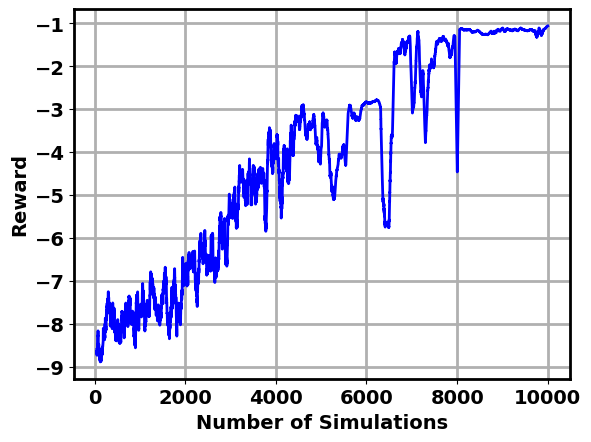

In [ ]:
""" Load reward buffer to plot reward vs simulations """
num_steps = 10000

with open('/content/sky130_ldo/saved_memories/rews_buf_LDOFoldedCascode.npy', 'rb') as memory_file:
    rews_buf = np.load(memory_file)
    
rews_buf = rews_buf[:num_steps]

""" Result visualizations and save these as pictures """
# plot average reward
window = 50
avg_rewards=[]
for k in range(len(rews_buf)):
    if k >= window:
        avg_reward = np.mean(rews_buf[k-window:k])
    else:
        avg_reward = np.inf
    avg_rewards.append(avg_reward)
    
plt.figure('Reward')
plt.plot(avg_rewards, 'b')
plt.xlabel('Number of Simulations', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('Reward', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(linewidth=2)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)